In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

In [3]:
# this allows changing the code in external packages and having the changes take effect in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

In [4]:
from smart_fuel_acquisitons.data import create_features_and_targets, \
    create_features_and_targets_on_days_for_month, \
    create_features_and_targets_for_month, \
    predict_until_end, \
    create_features_for_month, create_range_until_month_end, \
    predict_until_month_end, predict_month_avg

# Tratamento de Dados

In [5]:
# Arquivo Excel
from pathlib import Path
file_path = Path('Dados') / 'ISEG_Bloomberg' / 'Dados.xlsx'


In [6]:
# Função para ler e limpar dados de uma folha específica, tratando colunas extras
def read_sheet(sheet_name, col_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=6)
    data = data.iloc[:, [0, 1]]  # Seleciona apenas as duas primeiras colunas relevantes
    data.columns = ['Date', col_name]
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna().set_index('Date')
    data = data.shift(1).dropna()  # Desloca os preços uma linha para baixo
    return data

Relativamente aos dados presentes em cada folha de Excel deslocou-se uma linha para baixo (close price), porque quando os dados foram extraídos da Bloomberg no dia 17/07/2024 e o dia ainda não tinha terminado, ou seja, o close price do dia 17/07 era o close price do dia anterior e assim sucessivamente, até ao close price mais antigo.

In [7]:
# Ler os dados das várias folhas com os nomes das colunas corrigidos (removendo Brent)
wti_data = read_sheet('WTI Crude Oil', 'WTI Crude Oil Prices')
sp500_data = read_sheet('S&P500', 'S&P500')
gold_data = read_sheet('Gold', 'Gold')
silver_data = read_sheet('Silver', 'Silver')
eurusd_data = read_sheet('EURUSD', 'EUR/USD')
eurrub_data = read_sheet('EURRUB', 'EUR/RUB')

Depois de ter usado todas as variáveis extraídas da Bloomberg e de as ter correlacionado decidi optar apenas por estas, tendo como variável dependente o WTI Crude Oil. O Jet Fuel NWE CIF Cargoes tem, tal como o Brent e como era de esperar, uma correlação de 0.99 com o WTI, no entanto, tem dados apenas desde 2008. A Bitcoin tem dados desde 2010 e tinha uma correlação de 0.10. A taxa de câmbio USD/RUB não tinha dados a partir de 2022 e ambas as moedas estão expostas ao EUR que mostra uma correlação considerável, daí ter optado por retirar do modelo. Por fim, as variáveis total crude oil supply & demand foram retiradas porque, apesar de terem uma correlação aparentemente considerável, têm apenas dados mensais e trimestrais.

In [8]:
# Combinar todas as folhas em um único DataFrame
combined_data = wti_data.join([sp500_data, gold_data, silver_data, eurusd_data, eurrub_data], how='outer')
combined_data.dropna(inplace=True)

## Closing Prices das 6 variáveis s/ Brent

In [9]:
# Exibir os primeiros 5 registros
print(combined_data.head())

            WTI Crude Oil Prices  S&P500    Gold  Silver  EUR/USD  EUR/RUB
Date                                                                      
1994-01-04                 14.67  466.89  393.85    5.24   1.1246   1.1088
1994-01-05                 15.34  467.55  391.20    5.09   1.1252   1.1154
1994-01-06                 15.42  467.12  388.90    5.12   1.1252   1.1189
1994-01-07                 15.32  469.90  387.10    5.01   1.1293   1.1148
1994-01-10                 14.67  475.27  384.60    5.04   1.1269   1.1305


## Dados (1994-2024)

In [10]:
# Filtrar os dados entre as datas de 1994 e 2024
start_date = '1994-01-04'
end_date = '2024-07-15'
filtered_data = combined_data[(combined_data.index >= start_date) & (combined_data.index <= end_date)]

In [11]:
# Função para plotar cada variável
def plot_variable(data, variable_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[variable_name], label=variable_name)
    plt.title(f'{variable_name} (1994 - 2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

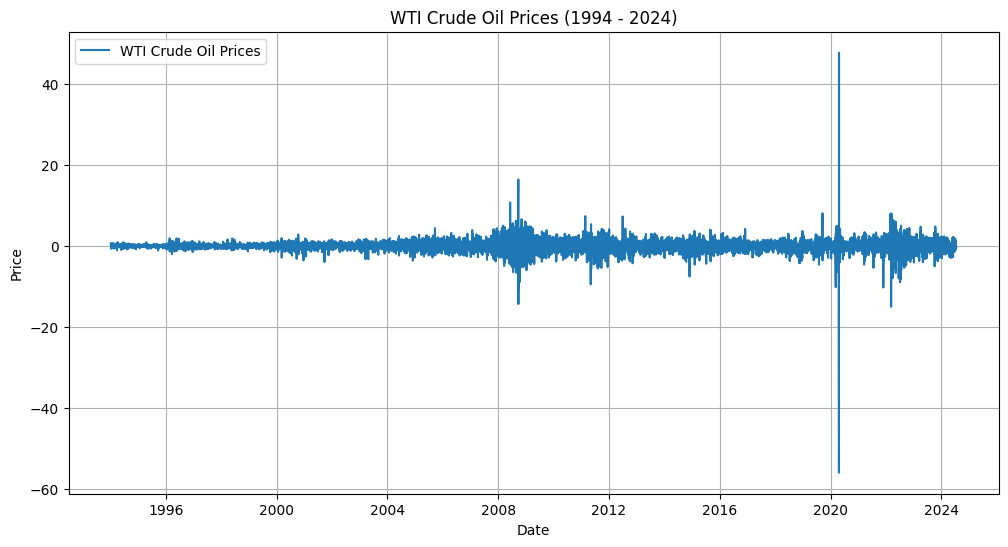

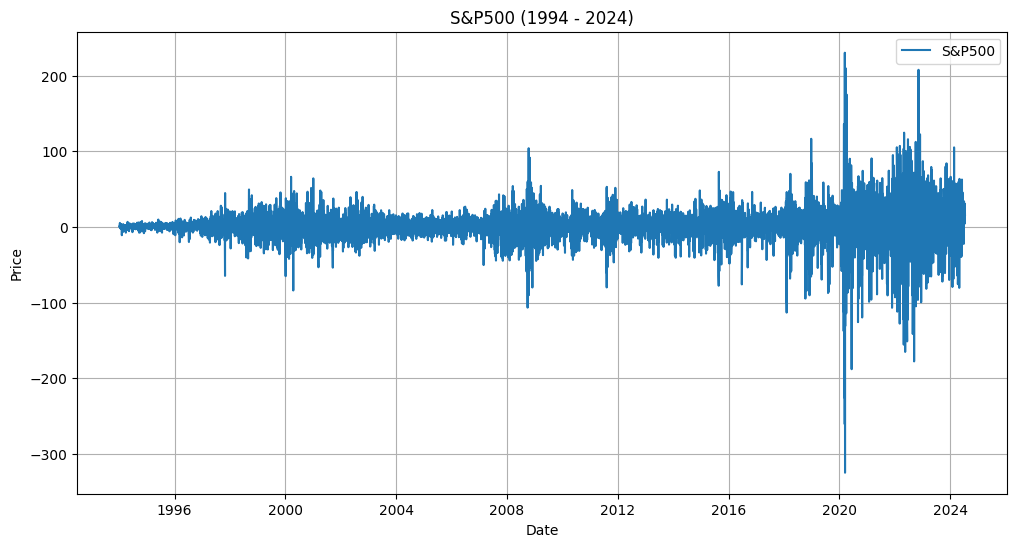

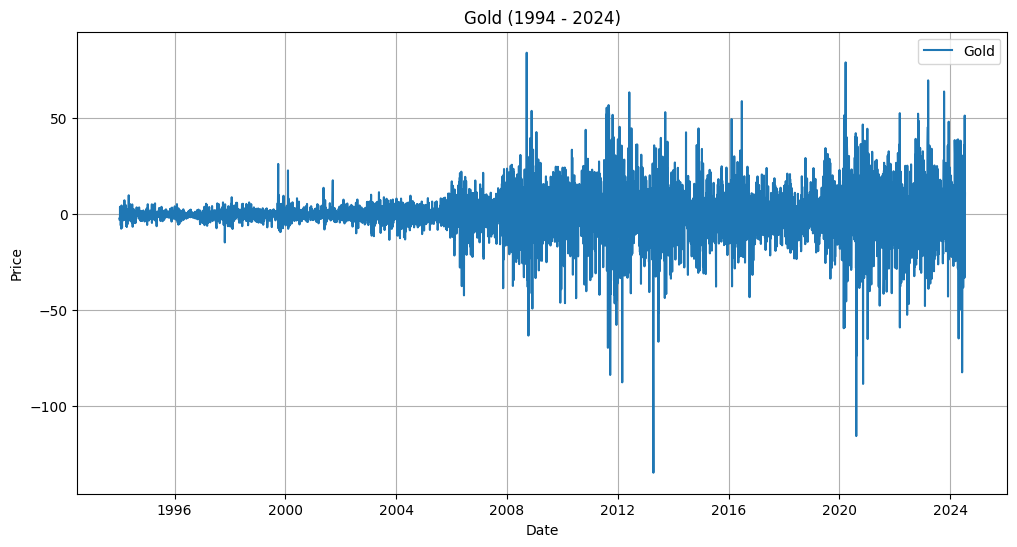

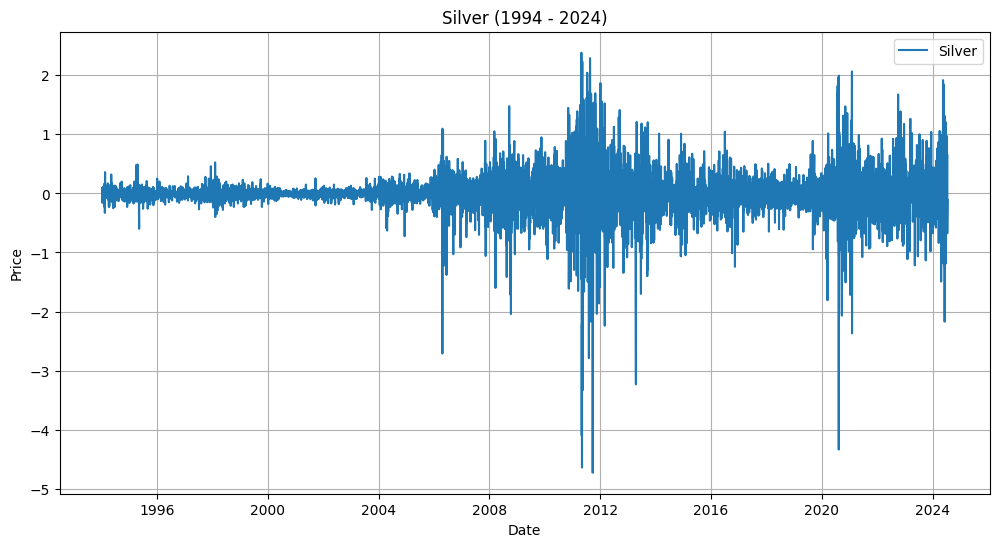

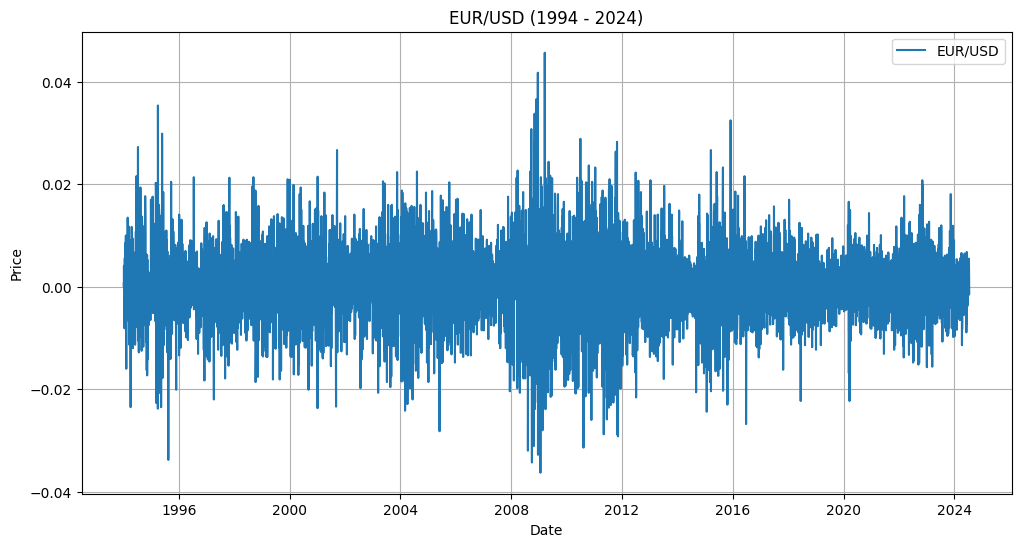

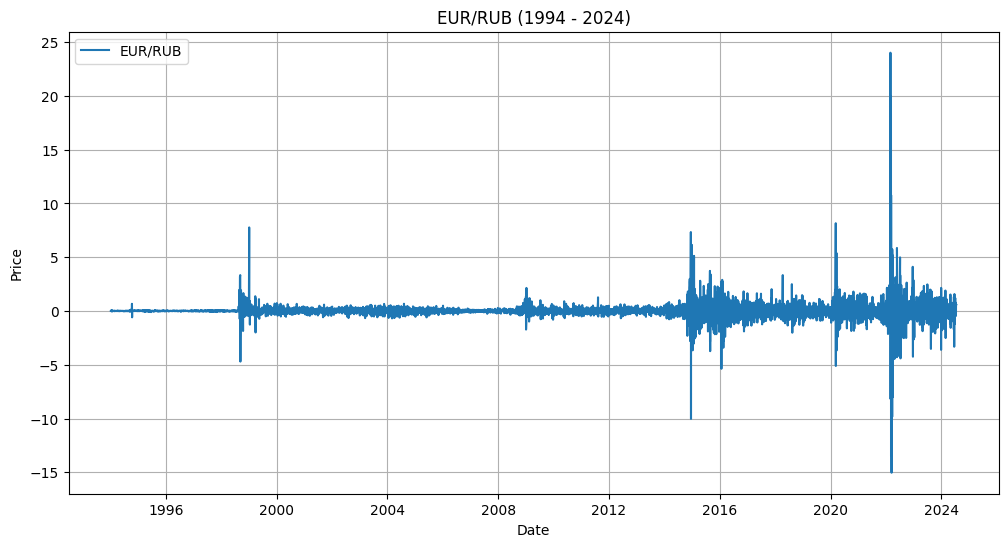

In [12]:
dif_data = filtered_data.diff().dropna()
for col in dif_data.columns:
    plot_variable(dif_data, col)


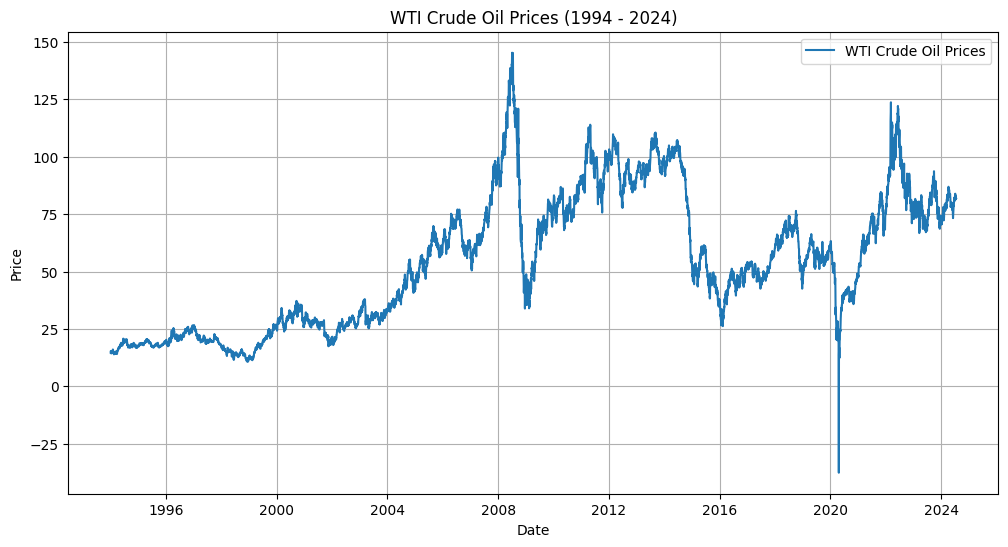

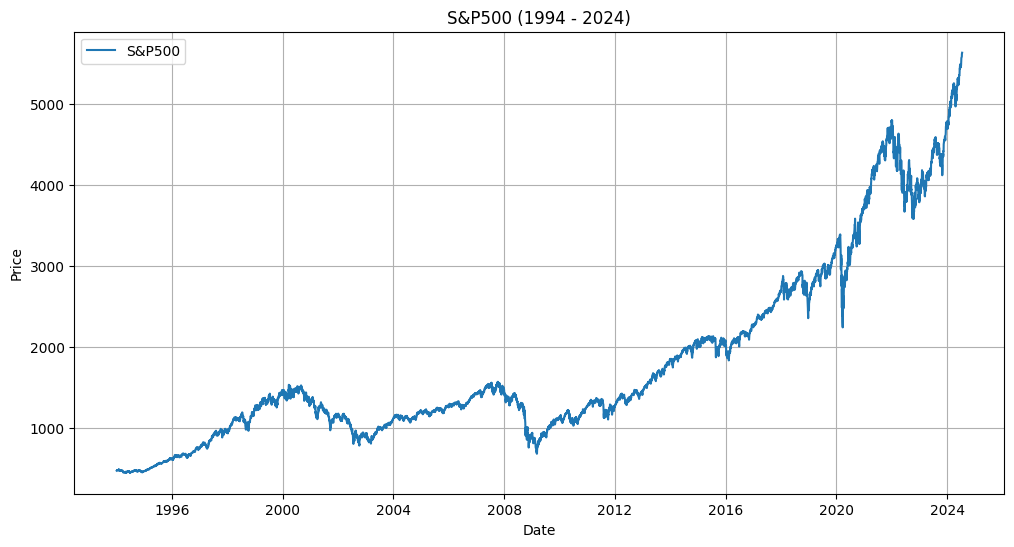

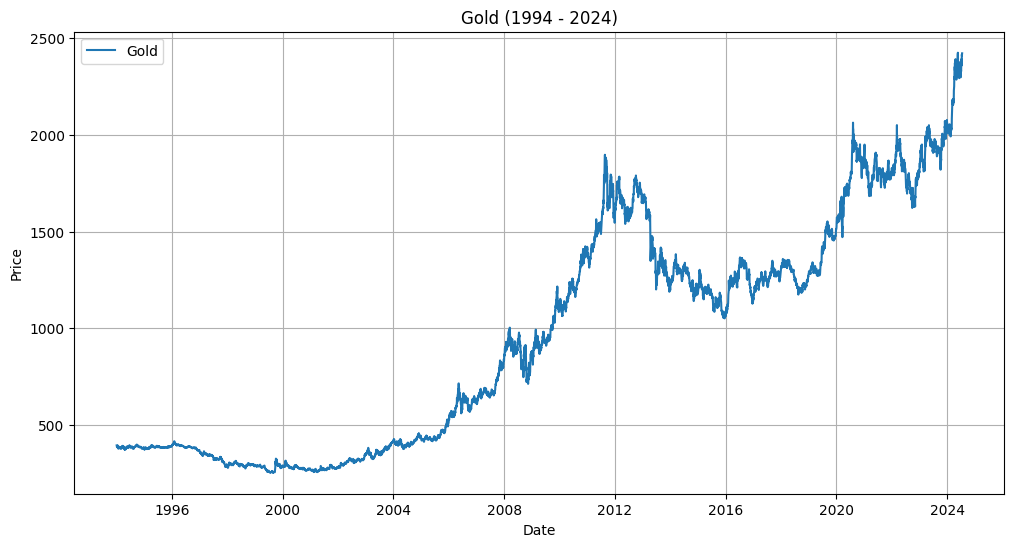

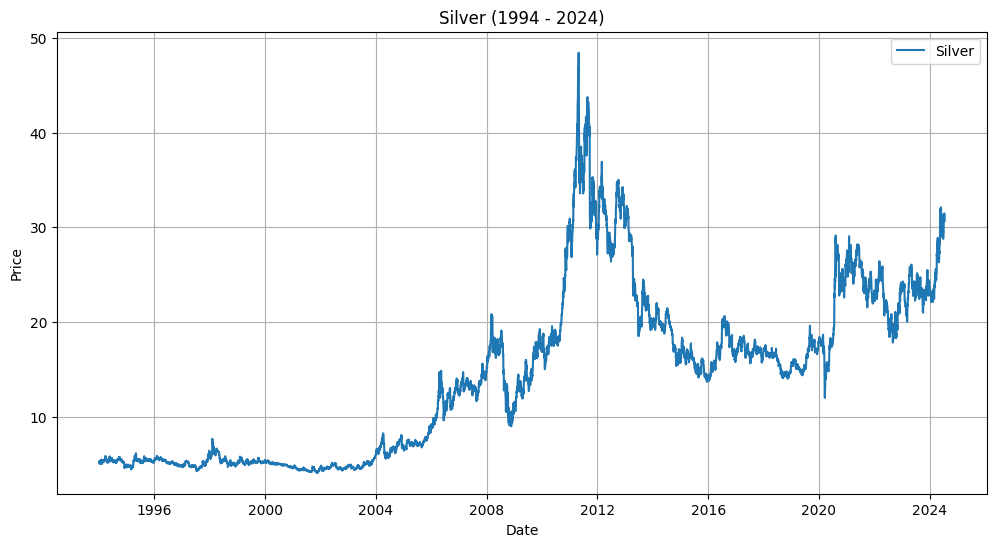

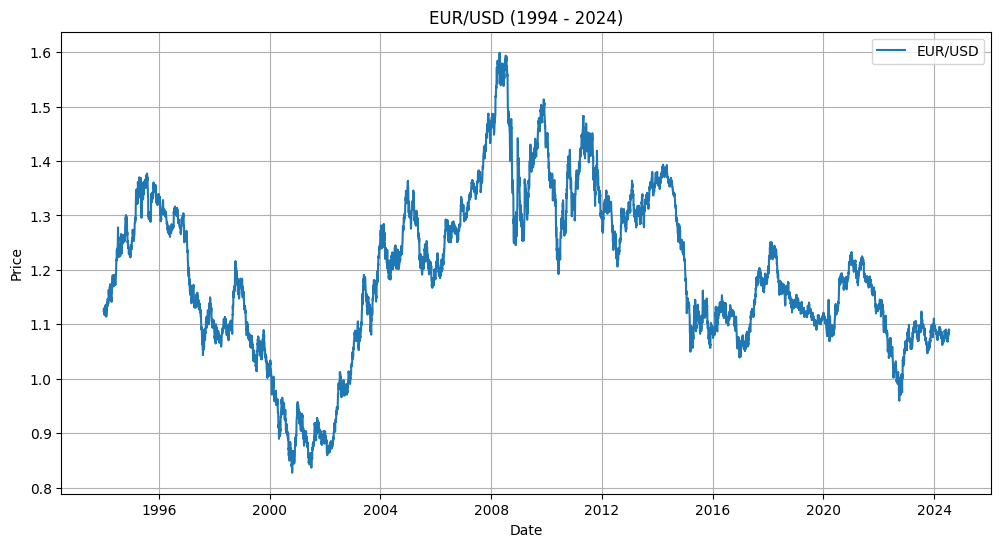

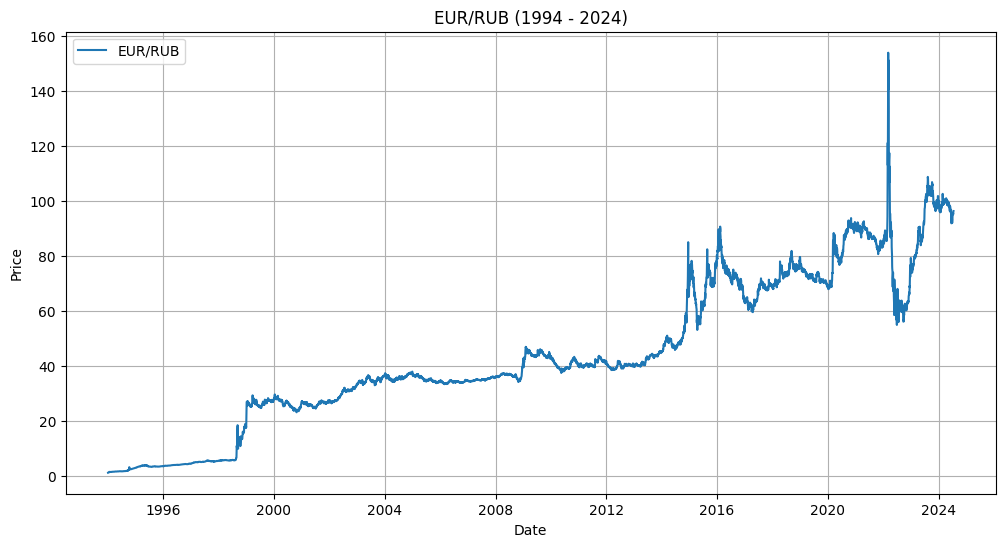

In [13]:
for col in filtered_data.columns:
    plot_variable(filtered_data, col)

## Gráficos das variáveis

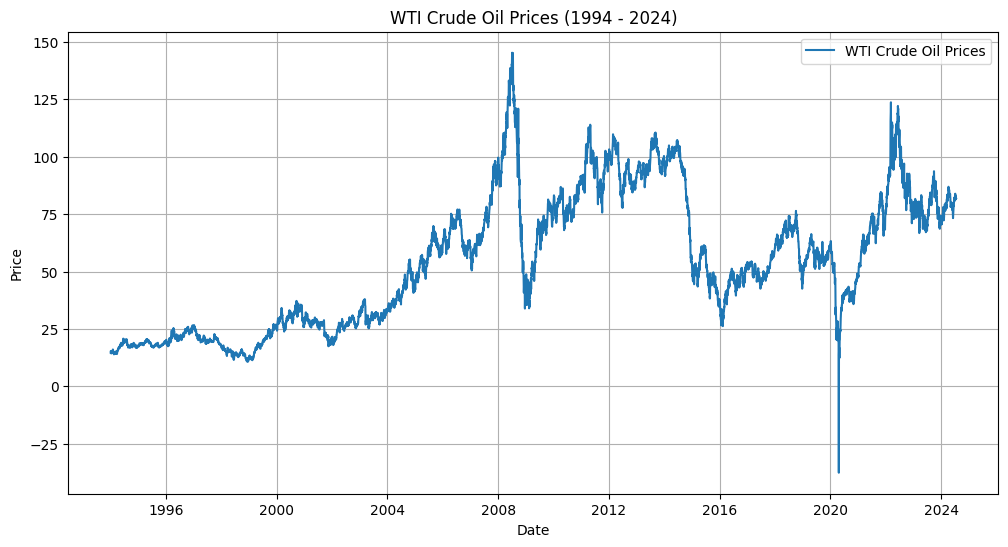

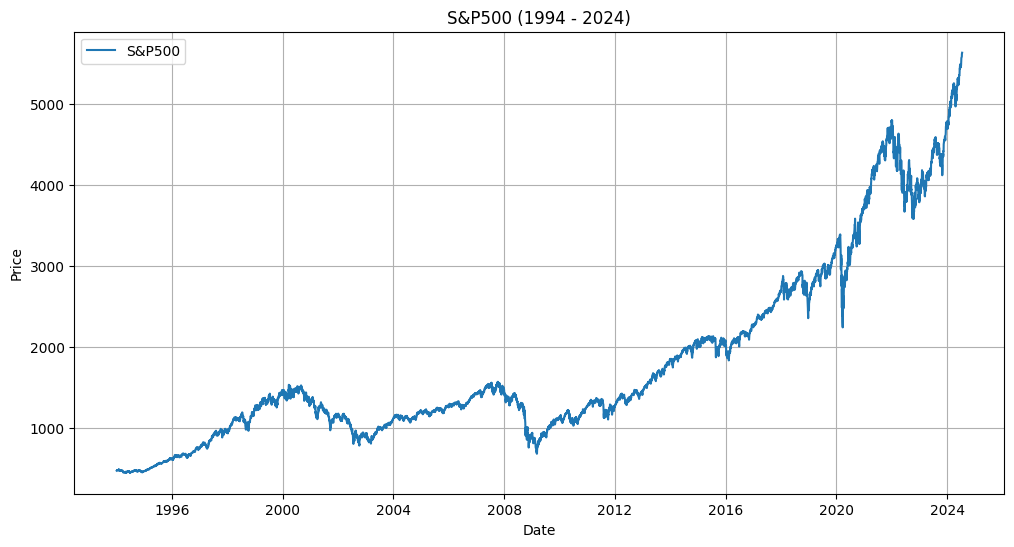

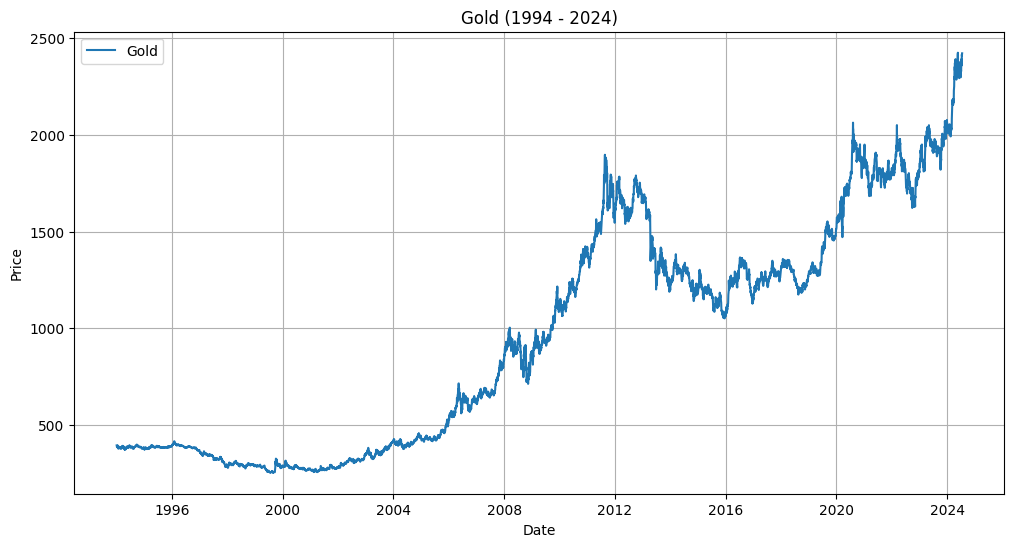

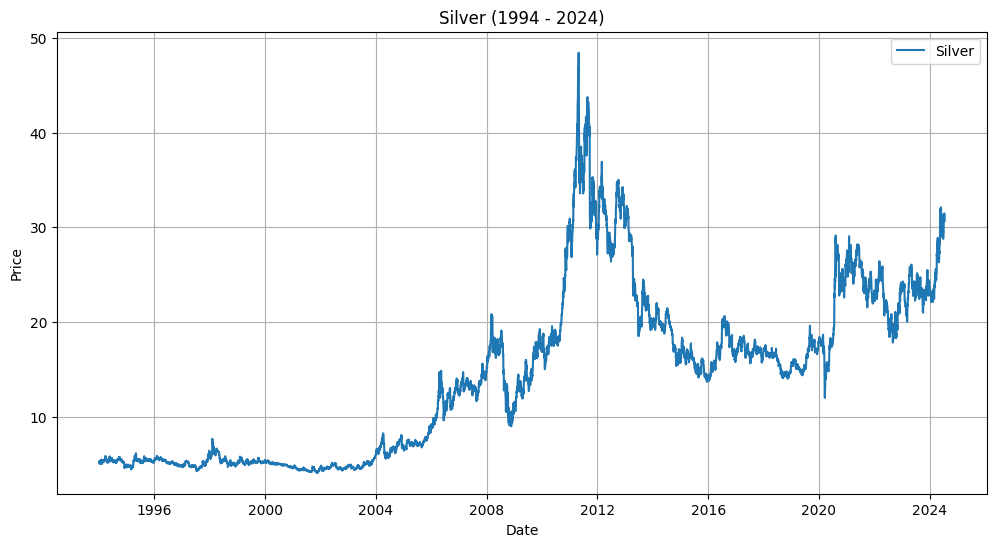

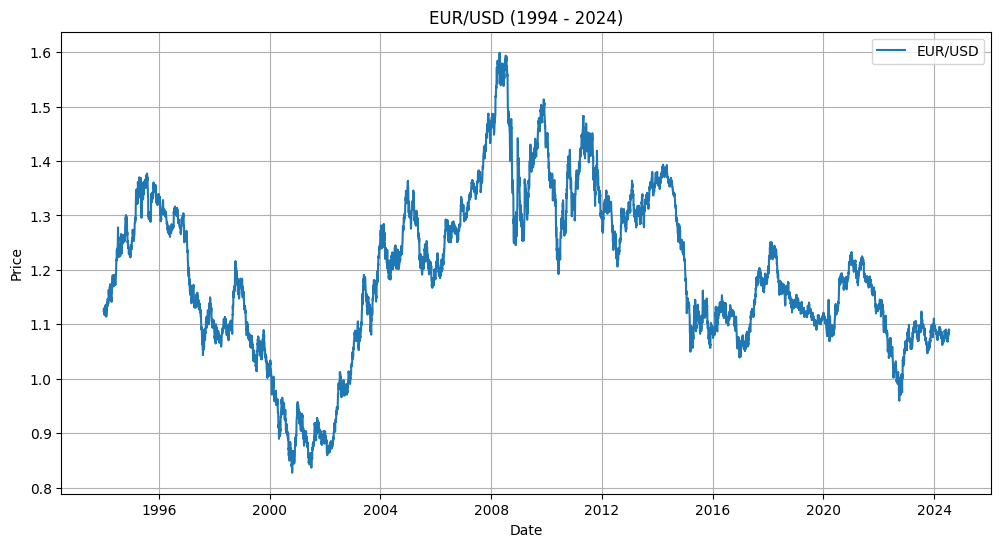

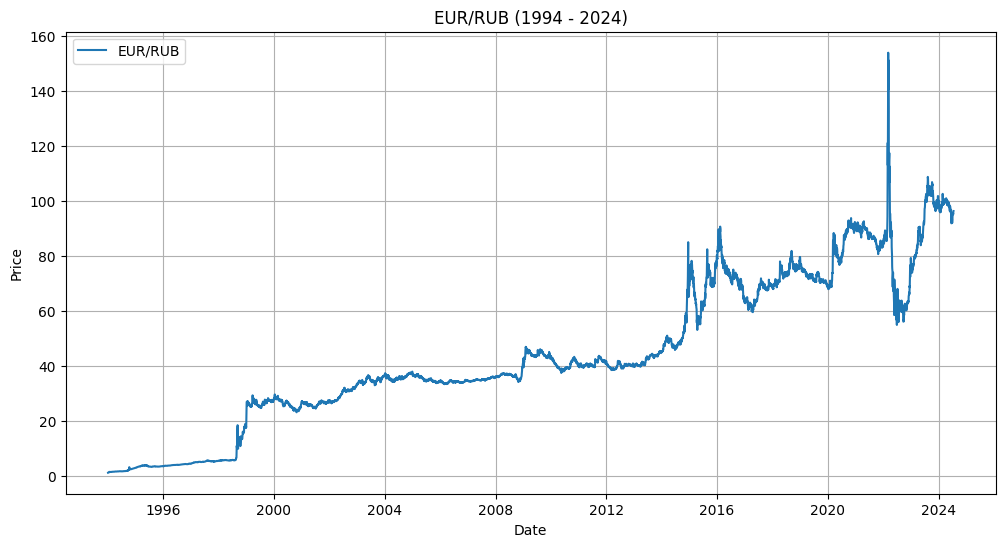

In [14]:
# Plotar gráficos para cada variável
variables = ['WTI Crude Oil Prices', 'S&P500', 'Gold', 'Silver', 'EUR/USD', 'EUR/RUB']
for var in variables:
    plot_variable(filtered_data, var)

## Describe das variáveis

In [15]:
# Descrever as variáveis
description = combined_data.describe()
print(tabulate(description, headers='keys', tablefmt='psql'))

+-------+------------------------+----------+----------+------------+-------------+-----------+
|       |   WTI Crude Oil Prices |   S&P500 |     Gold |     Silver |     EUR/USD |   EUR/RUB |
|-------+------------------------+----------+----------+------------+-------------+-----------|
| count |              7639      |  7639    | 7639     | 7639       | 7639        | 7639      |
| mean  |                54.8555 |  1806.76 |  961.095 |   14.2966  |    1.19128  |   44.1691 |
| std   |                29.0853 |  1144.45 |  587.185 |    8.81271 |    0.148147 |   26.8482 |
| min   |               -37.63   |   441.49 |  252.55  |    4.06    |    0.8272   |    1.1088 |
| 25%   |                27.585  |  1092.2  |  382.5   |    5.32    |    1.0916   |   27.3287 |
| 50%   |                53.01   |  1344.78 |  944     |   14.5     |    1.1815   |   38.9688 |
| 75%   |                77.475  |  2208.47 | 1370.28  |   19.6391  |    1.30285  |   68.7597 |
| max   |               145.29   |  5631

## Matriz de Correlação (Heatmap)

In [16]:
# Calcular a matriz de correlação
correlation_matrix = combined_data.corr()

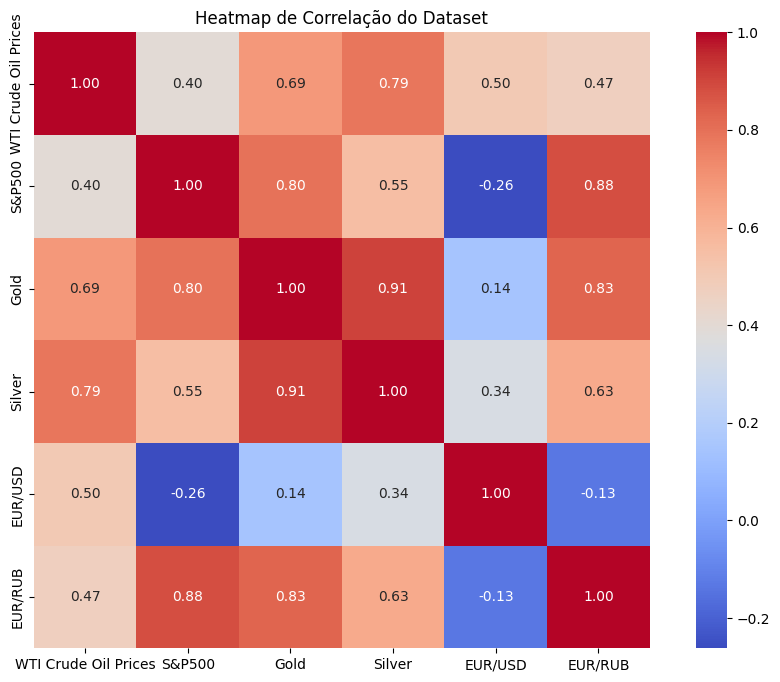

In [17]:
# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

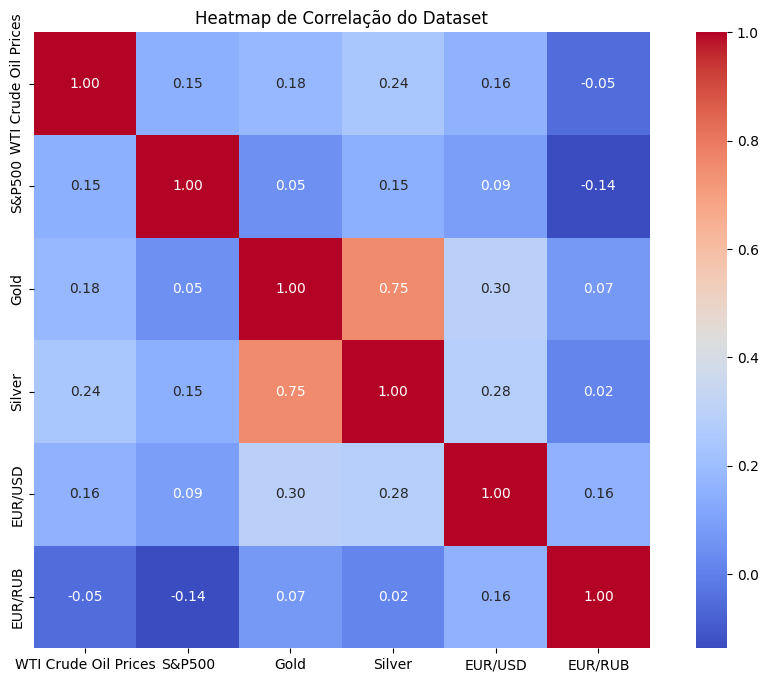

In [18]:
# Plotar o heatmap
correlation_matrix = dif_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

# Modelagem

## Creating Features and Target Variables

A variável a estudar é o WTI Crude Oil, com preços 1994 a 2024, e vamos definir um único horizonte
temporal, h=1 ou seja, prever o preço do WTI para o dia seguinte, usando um daily dataframe e uma window_size de 30 dias.

In [209]:
config = {
    "MAX_HORIZON": 15,
    "MAX_LAG": 30,
    "SCALER_TYPE": StandardScaler,
    "target_col": 0,
    "models": [
        "Linear",
        "Ridge",
        "Lasso",
        # "Elastic Net",
        # "Random Forest",
        # "XGBoost",
        "SVR"
    ]
}

## Train-Test Split

In [20]:
src_df = filtered_data.copy()

train_df = src_df.loc[:"2019-01-01"]
test_df = src_df.loc["2019-01-01":]

#scaled_data = X_scaler.fit_transform(filtered_data)
#scaled_y = y_scaler.fit_transform(filtered_data['WTI Crude Oil Prices'].values.reshape(-1, 1))

# train_df_enc = pd.DataFrame(data=X_scaler.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
# train_df_enc.iloc[:,config["target_col"]] = y_scaler.fit_transform(train_df.iloc[:,config["target_col"]].values.reshape(-1, 1))


# test_df_enc = pd.DataFrame(data=X_scaler.transform(test_df), columns=test_df.columns, index=test_df.index)
# test_df_enc.iloc[:,config["target_col"]] = y_scaler.transform(test_df.iloc[:,config["target_col"]].values.reshape(-1, 1))

train_df_enc = train_df
test_df_enc = test_df

# scaled
Xha, yha, Ha = create_features_and_targets(train_df_enc, config["MAX_HORIZON"], config["MAX_LAG"],  config["target_col"])
Xht, yht, Ht = create_features_and_targets(test_df_enc, config["MAX_HORIZON"], config["MAX_LAG"],  config["target_col"])

In [21]:
# for each month, select the 2nd to last wednesday
filtered_data['year'] = filtered_data.index.year
filtered_data['month'] = filtered_data.index.month
filtered_data['day'] = filtered_data.index.day

filtered_data['Monthly Average'] = filtered_data['WTI Crude Oil Prices'].resample('ME').transform('mean')
filtered_data['Monthly Average'] = filtered_data['Monthly Average'].ffill()


wed_mask = filtered_data.index.weekday == 2
test_mask = (filtered_data.index > '2020-01-01') & (filtered_data.index < '2024-06-01') & wed_mask

filtered_data[test_mask].groupby(['year', 'month']).nth(-2)

WTI Crude Oil Prices   S&P500     Gold   Silver  EUR/USD  \
Date                                                                   
2020-01-22                 56.74  3321.75  1558.78  17.8397   1.1093   
2020-02-19                 53.29  3386.15  1611.70  18.4320   1.0805   
2020-03-18                 20.37  2398.10  1486.05  11.9810   1.0915   
2020-04-22                 13.78  2799.31  1714.08  15.0970   1.0823   
2020-05-20                 33.49  2971.61  1748.18  17.5567   1.0980   
2020-06-17                 37.96  3113.49  1726.95  17.5050   1.1244   
2020-07-22                 41.90  3276.02  1871.41  22.9960   1.1570   
2020-08-19                 42.93  3374.85  1928.98  26.7005   1.1838   
2020-09-23                 39.93  3236.92  1863.34  22.7784   1.1660   
2020-10-21                 40.03  3435.56  1924.33  25.0472   1.1861   
2020-11-18                 41.82  3567.79  1872.24  24.3365   1.1853   
2020-12-23                 48.12  3690.01  1872.89  25.5420   1.2187   
2021-01-20                 53.24  3851.85  1871.84  25.8425   1.2106   
2021-02-17                 61.14  3931.33  1776.13  27.3829   1.2038   
2021-03-24                 61.18  3889.14  1734.69  25.0948   1.1813   
2021-04-21                 61.35  4173.42  1793.79  26.5538   1.2035   
2021-05-19                 63.36  4115.68  1869.62  27.7366   1.2175   
2021-06-23                 73.08  4241.84  1778.68  25.8914   1.1926   
2021-07-21                 70.30  4358.69  1803.66  25.2612   1.1794   
2021-08-18                 65.46  4400.27  1787.82  23.5090   1.1711   
2021-09-22                 72.23  4395.64  1768.16  22.6963   1.1687   
2021-10-20                 83.87  4536.19  1782.08  24.2920   1.1651   
2021-11-17                 78.36  4688.67  1867.48  25.0858   1.1319   
2021-12-22                 72.76  4696.56  1803.67  22.8110   1.1326   
2022-01-19                 86.96  4532.76  1840.54  24.1385   1.1343   
2022-02-16                 93.66  4475.01  1869.80  23.5975   1.1373   
2022-03-23                114.93  4456.24  1943.86  25.1110   1.1004   
2022-04-20                102.75  4459.45  1957.77  25.2045   1.0853   
2022-05-18                109.59  3923.68  1816.60  21.4230   1.0464   
2022-06-22                106.19  3759.89  1837.72  21.4187   1.0566   
2022-07-20                102.26  3959.90  1696.58  18.6789   1.0180   
2022-08-24                 94.89  4140.77  1751.19  19.1125   0.9967   
2022-09-21                 82.94  3789.93  1673.89  19.5684   0.9837   
2022-10-19                 85.55  3695.16  1629.44  18.4638   0.9773   
2022-11-23                 77.94  4027.26  1749.68  21.5380   1.0397   
2022-12-21                 78.29  3878.44  1814.39  23.9655   1.0605   
2023-01-18                 79.48  3928.86  1904.11  23.4645   1.0794   
2023-02-15                 78.59  4147.60  1836.01  21.6264   1.0689   
2023-03-22                 70.90  3936.97  1970.11  22.9896   1.0856   
2023-04-19                 79.16  4154.52  1994.93  25.2915   1.0955   
2023-05-24                 74.34  4115.24  1957.16  23.0560   1.0750   
2023-06-21                 72.53  4365.69  1932.55  22.6364   1.0986   
2023-07-19                 75.35  4565.72  1976.64  25.1452   1.1201   
2023-08-23                 78.89  4436.01  1915.48  24.3108   1.0863   
2023-09-20                 90.28  4402.20  1930.30  23.2387   1.0661   
2023-10-18                 88.32  4314.60  1947.55  22.8415   1.0536   
2023-11-22                 77.10  4556.62  1990.17  23.6316   1.0888   
2023-12-20                 74.22  4698.35  2031.39  24.1473   1.0942   
2024-01-24                 75.09  4868.55  2013.89  22.6675   1.0885   
2024-02-21                 77.91  4981.80  2025.99  22.8860   1.0819   
2024-03-20                 81.68  5224.62  2186.39  25.5824   1.0922   
2024-04-17                 82.69  5022.21  2361.02  28.2233   1.0673   
2024-05-22                 77.57  5307.01  2378.85  30.7902   1.0823   

             EUR/RUB  year  month  day  Monthly Ave

In [22]:
assert Xha.shape[1] == Xht.shape[1], 'Erro no número de amostras de treino'

No train-test split usou-se um rácio de 80/20

In [186]:
# Treinar e avaliar os modelos
valid_models = {
    "Linear": {
        "callable": LinearRegression,
        "params": {},
        },
    "Ridge": {
        "callable": Ridge,
        "params": {"alpha": 0.01},
        },
    "Lasso": {
        "callable": Lasso,
        "params": {"alpha": 0.01},
        },
    "Elastic Net": {
        "callable": ElasticNet,
        "params": {"alpha": 0.01, "l1_ratio": 0.5},
        },
    "Random Forest": {
        "callable": RandomForestRegressor,
        "params": {
            "n_estimators": 100,
            "max_depth": 20,
            "bootstrap": True,
        },
        },
    "XGBoost": {
        "callable": XGBRegressor,
        "params": {},
        },
    "SVR": {
        "callable": SVR,
        "params": {"kernel": 'rbf'},
        }
}

# check that all models in config are valid
assert all(model in valid_models for model in config["models"]), 'Invalid models in config'

## Métricas usadas (RMSE, MAPE, R^2 e MSE)

In [172]:
import time

In [210]:
# filter models based on config
models = {k: v for k, v in valid_models.items() if k in config["models"]}

results = {horizon: {name: {} for name in models.keys()} for horizon in yha.keys()}
results2 = []

ScalerType = config["SCALER_TYPE"]

for horizon in results.keys():
    X_train = Xha
    X_test = Xht
    y_train = yha[horizon]
    y_test = yht[horizon]
    for name, mdict in models.items():
        print(f"H={horizon} | Model={name} | ", end="")

        # create the regressor model, add a scaling to X before feeding data to the model, add scaling to targets too
        model = mdict["callable"](**mdict["params"])
        pipeline = Pipeline([('scaler', ScalerType()), ('model', model)])
        final_model = TransformedTargetRegressor(regressor=pipeline, transformer=ScalerType())

        t_start = time.time()
        trained_model = final_model.fit(X_train, y_train)
        t_training = time.time() - t_start

        y_pred = final_model.predict(X_test)

        rmse = root_mean_squared_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        res_dict = {
            "horizon": horizon,
            "name": name,
            "model": final_model,
            "training_time": t_training,
            "RMSE": rmse,
            "MSE": mse,
            "MAPE": mape,
            "R2": r2,
            "y_pred": y_pred,
        }

        results[horizon][name] = res_dict
        results2.append(res_dict)
        
        print(f"Took {t_training:.2f} seconds | ", end="")
        # print metrics
        print(f"RMSE: {rmse:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}")

# specifiy every model, add a key is_best if that model is the best in that horizon
for horizon in results.keys():
    best_model = min(results[horizon].keys(), key=lambda x: results[horizon][x]["RMSE"])
    results[horizon][best_model]["is_best"] = True

H=0 | Model=Linear | Took 0.05 seconds | RMSE: 2.77, MSE: 7.69, MAPE: 0.03, R2: 0.98
H=0 | Model=Ridge | Took 0.04 seconds | RMSE: 2.77, MSE: 7.68, MAPE: 0.03, R2: 0.98
H=0 | Model=Lasso | Took 0.24 seconds | RMSE: 2.66, MSE: 7.09, MAPE: 0.03, R2: 0.98
H=0 | Model=SVR | Took 0.14 seconds | RMSE: 16.00, MSE: 255.94, MAPE: 0.21, R2: 0.37
H=1 | Model=Linear | Took 0.03 seconds | RMSE: 3.45, MSE: 11.92, MAPE: 0.04, R2: 0.97
H=1 | Model=Ridge | Took 0.02 seconds | RMSE: 3.45, MSE: 11.91, MAPE: 0.04, R2: 0.97
H=1 | Model=Lasso | Took 0.21 seconds | RMSE: 3.31, MSE: 10.95, MAPE: 0.03, R2: 0.97
H=1 | Model=SVR | Took 0.17 seconds | RMSE: 16.44, MSE: 270.16, MAPE: 0.21, R2: 0.33
H=2 | Model=Linear | Took 0.02 seconds | RMSE: 3.91, MSE: 15.32, MAPE: 0.04, R2: 0.96
H=2 | Model=Ridge | Took 0.02 seconds | RMSE: 3.91, MSE: 15.31, MAPE: 0.04, R2: 0.96
H=2 | Model=Lasso | Took 0.21 seconds | RMSE: 3.77, MSE: 14.22, MAPE: 0.04, R2: 0.96
H=2 | Model=SVR | Took 0.20 seconds | RMSE: 16.94, MSE: 286.94, M

# Modelos de Machine Learning

## Resultados

Inicialmente foram usados 4 modelos (Linear, Ridge, Lasso e Elastic Net Regressions) para testar o daily dataframe com h=1. Seguidamente, foram adicionados o Random Forest, XGBoost e o SVR com a RBF de Kernel.

In [215]:
res_df = pd.DataFrame(results2)
res_df.drop(columns=['model', "y_pred"], inplace=True)
res_df

horizon    name  training_time       RMSE         MSE      MAPE        R2  \
0         0  Linear       0.047266   2.773029    7.689689  0.027527  0.980942   
1         0   Ridge       0.040894   2.771247    7.679810  0.027494  0.980967   
2         0   Lasso       0.236499   2.663567    7.094588  0.025338  0.982417   
3         0     SVR       0.142862  15.998119  255.939811  0.206096  0.365694   
4         1  Linear       0.030472   3.452408   11.919121  0.036421  0.970458   
..      ...     ...            ...        ...         ...       ...       ...   
59       14     SVR       0.373750  21.993219  483.701692  0.292814 -0.197999   
60       15  Linear       0.024705   7.335512   53.809732  0.087263  0.866733   
61       15   Ridge       0.027961   7.334738   53.798378  0.087253  0.866762   
62       15   Lasso       0.208896   6.886489   47.423728  0.086612  0.882549   
63       15     SVR       0.379979  22.002310  484.101641  0.295253 -0.198939   

   is_best  
0      NaN  
1      NaN  
2     True  
3      NaN  
4      NaN  
..     ...  
59     NaN  
60     NaN  
61     NaN  
62    True  
63     NaN  

[64 rows x 8 columns]

In [212]:
print("best model by RMSE")
res_df.groupby('horizon').apply(lambda x: x[x['RMSE'] == x['RMSE'].min()])

best model by RMSE


/tmp/ipykernel_18548/1177628181.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res_df.groupby('horizon').apply(lambda x: x[x['RMSE'] == x['RMSE'].min()])


horizon   name  training_time      RMSE        MSE      MAPE  \
horizon                                                                    
0       2         0  Lasso       0.236499  2.663567   7.094588  0.025338   
1       6         1  Lasso       0.210194  3.308388  10.945431  0.034119   
2       10        2  Lasso       0.212315  3.770810  14.219009  0.040569   
3       14        3  Lasso       0.201386  4.139361  17.134313  0.044931   
4       18        4  Lasso       0.201503  4.469729  19.978481  0.049705   
5       22        5  Lasso       0.204167  4.766148  22.716165  0.054159   
6       26        6  Lasso       0.222513  5.026677  25.267478  0.058138   
7       30        7  Lasso       0.210780  5.266326  27.734189  0.061946   
8       34        8  Lasso       0.213433  5.501896  30.270865  0.065294   
9       38        9  Lasso       0.223399  5.716314  32.676250  0.068465   
10      42       10  Lasso       0.203502  5.882252  34.600894  0.071583   
11      46       11  Lasso       0.214857  6.039884  36.480204  0.074678   
12      50       12  Lasso       0.215578  6.232227  38.840656  0.077607   
13      54       13  Lasso       0.212574  6.448356  41.581291  0.080499   
14      58       14  Lasso       0.194819  6.656595  44.310264  0.083702   
15      62       15  Lasso       0.208896  6.886489  47.423728  0.086612   

                  R2 is_best  
horizon                       
0       2   0.982417    True  
1       6   0.972871    True  
2       10  0.964757    True  
3       14  0.957531    True  
4       18  0.950483    True  
5       22  0.943701    True  
6       26  0.937382    True  
7       30  0.931274    True  
8       34  0.924992    True  
9       38  0.919045    True  
10      42  0.914289    True  
11      46  0.909636    True  
12      50  0.903791    True  
13      54  0.897010    True  
14      58  0.890255    True  
15      62  0.882549    True

In [216]:
print("best model by R2")
res_df.groupby('horizon').apply(lambda x: x[x['R2'] == x['R2'].max()])

best model by R2


/tmp/ipykernel_18548/1238221970.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res_df.groupby('horizon').apply(lambda x: x[x['R2'] == x['R2'].max()])


horizon   name  training_time      RMSE        MSE      MAPE  \
horizon                                                                    
0       2         0  Lasso       0.236499  2.663567   7.094588  0.025338   
1       6         1  Lasso       0.210194  3.308388  10.945431  0.034119   
2       10        2  Lasso       0.212315  3.770810  14.219009  0.040569   
3       14        3  Lasso       0.201386  4.139361  17.134313  0.044931   
4       18        4  Lasso       0.201503  4.469729  19.978481  0.049705   
5       22        5  Lasso       0.204167  4.766148  22.716165  0.054159   
6       26        6  Lasso       0.222513  5.026677  25.267478  0.058138   
7       30        7  Lasso       0.210780  5.266326  27.734189  0.061946   
8       34        8  Lasso       0.213433  5.501896  30.270865  0.065294   
9       38        9  Lasso       0.223399  5.716314  32.676250  0.068465   
10      42       10  Lasso       0.203502  5.882252  34.600894  0.071583   
11      46       11  Lasso       0.214857  6.039884  36.480204  0.074678   
12      50       12  Lasso       0.215578  6.232227  38.840656  0.077607   
13      54       13  Lasso       0.212574  6.448356  41.581291  0.080499   
14      58       14  Lasso       0.194819  6.656595  44.310264  0.083702   
15      62       15  Lasso       0.208896  6.886489  47.423728  0.086612   

                  R2 is_best  
horizon                       
0       2   0.982417    True  
1       6   0.972871    True  
2       10  0.964757    True  
3       14  0.957531    True  
4       18  0.950483    True  
5       22  0.943701    True  
6       26  0.937382    True  
7       30  0.931274    True  
8       34  0.924992    True  
9       38  0.919045    True  
10      42  0.914289    True  
11      46  0.909636    True  
12      50  0.903791    True  
13      54  0.897010    True  
14      58  0.890255    True  
15      62  0.882549    True

## Tabelas c/ modelos, horizontes e métricas

# Previsões

In [217]:
# Função para plotar previsões vs valores reais com valores desescalados
def plot_predictions(y_test, y_pred, model_name, horizon, x_axis=None):
    # y_test_descaled = inverse_transform(y_scaler, np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)), y_test)
    # y_pred_descaled = inverse_transform(y_scaler, np.zeros((y_pred.shape[0], scaled_data.shape[1] - 1)), y_pred)
    
    plt.figure(figsize=(12, 6))
    if x_axis is None:
        x_axis = range(len(y_test))
    plt.plot(x_axis, y_test, label='True', color='blue')
    plt.plot(x_axis, y_pred, label=model_name, color='orange')
    plt.title(f'Predição do modelo {model_name} para horizonte de {horizon} dias')
    plt.xlabel('Observations')
    plt.ylabel('WTI Crude Oil Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

Horizonte: 0 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


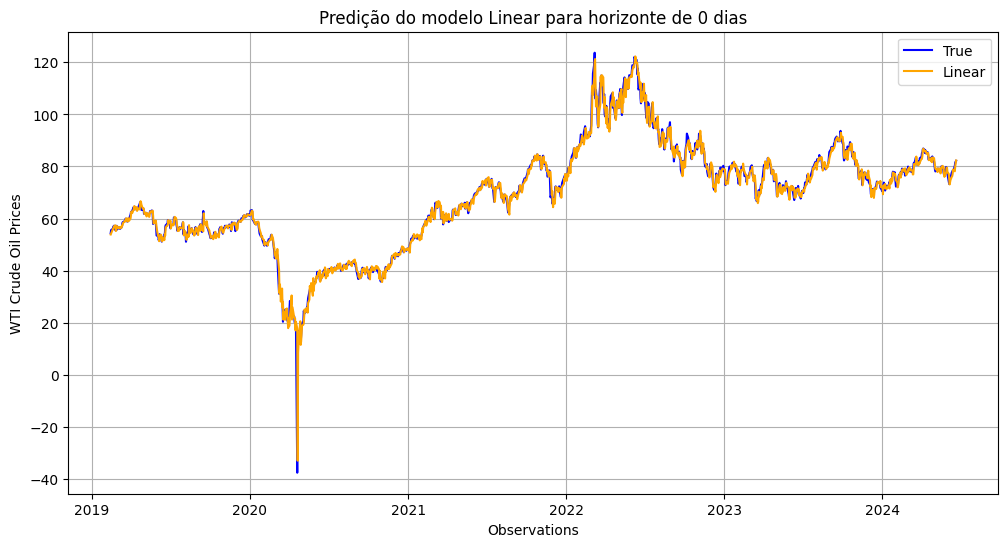

Modelo: Ridge - Tamanho de y_pred: 1344


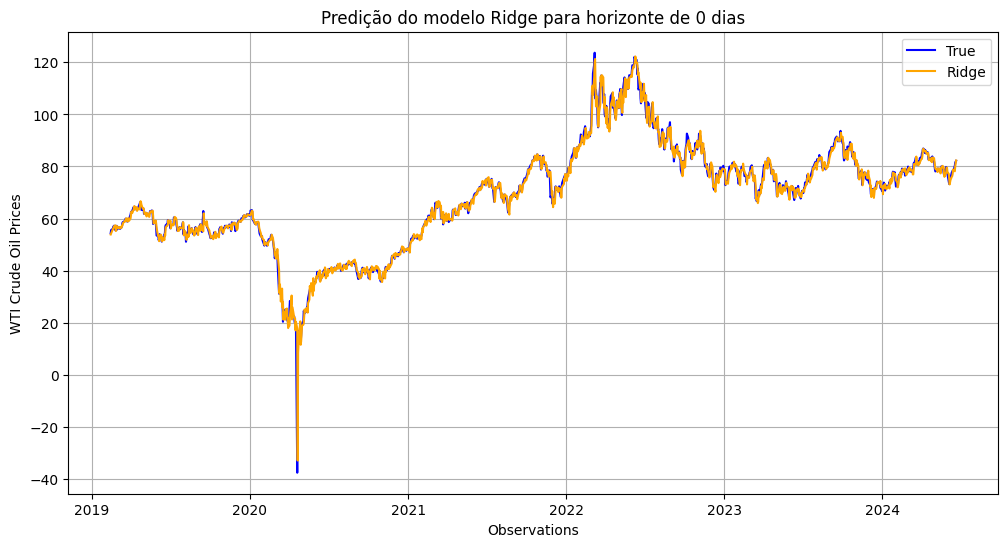

Modelo: Lasso - Tamanho de y_pred: 1344


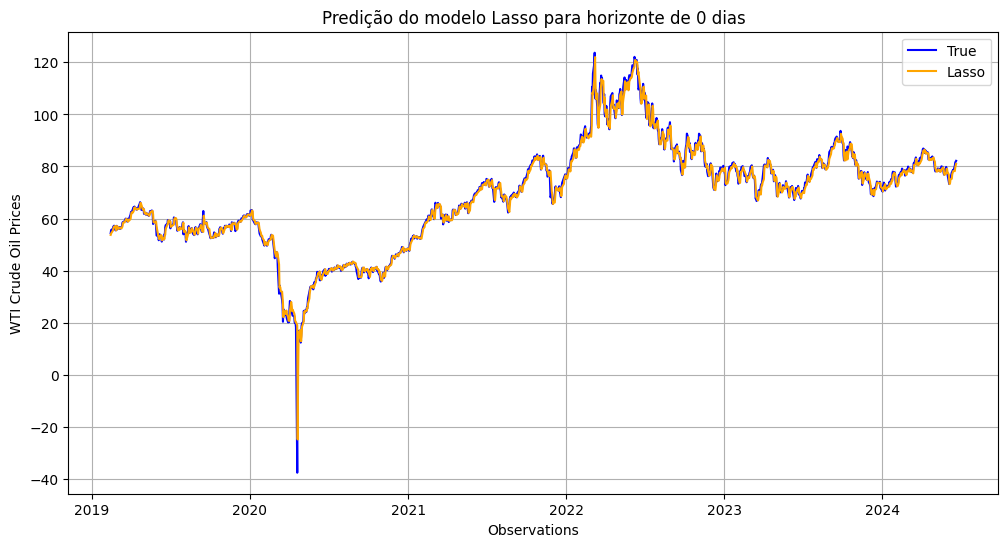

Modelo: SVR - Tamanho de y_pred: 1344


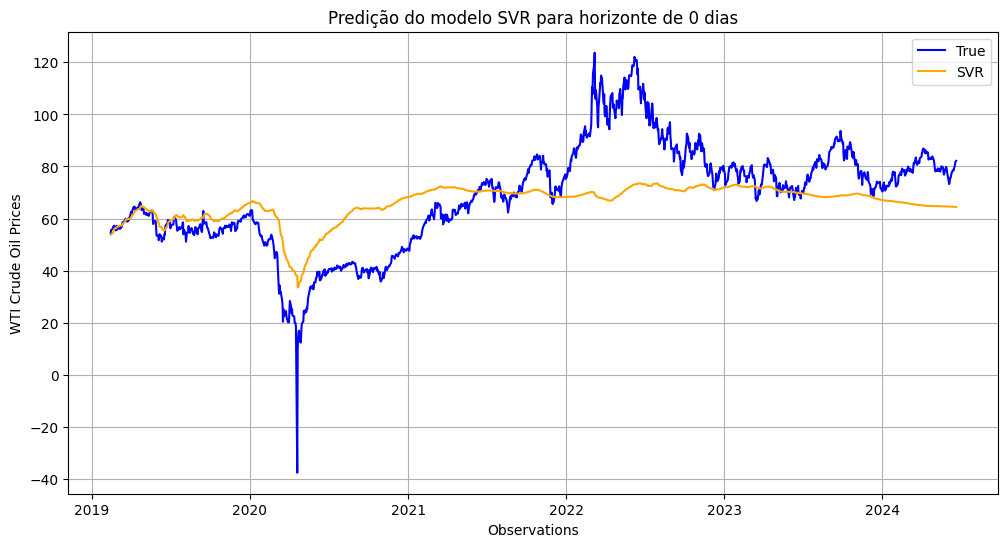

Horizonte: 1 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


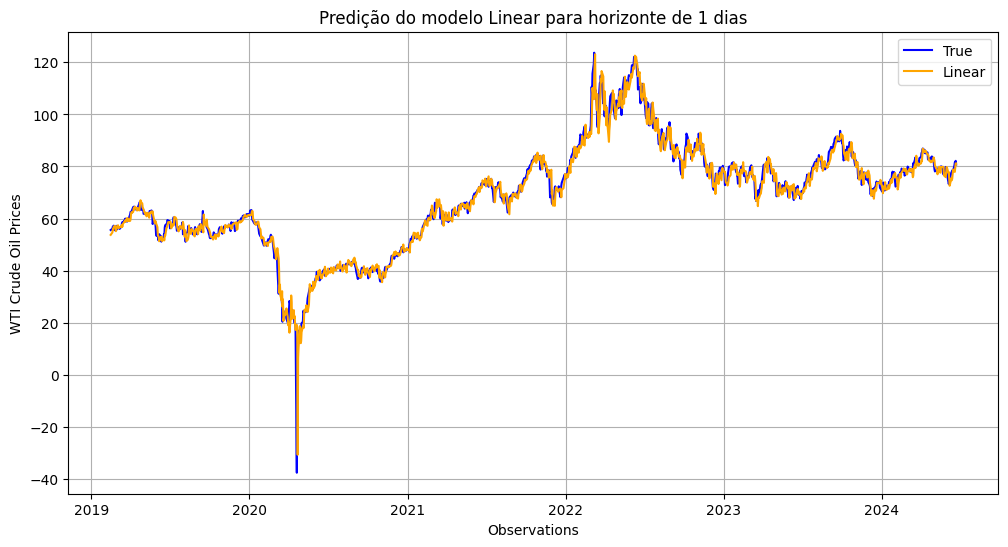

Modelo: Ridge - Tamanho de y_pred: 1344


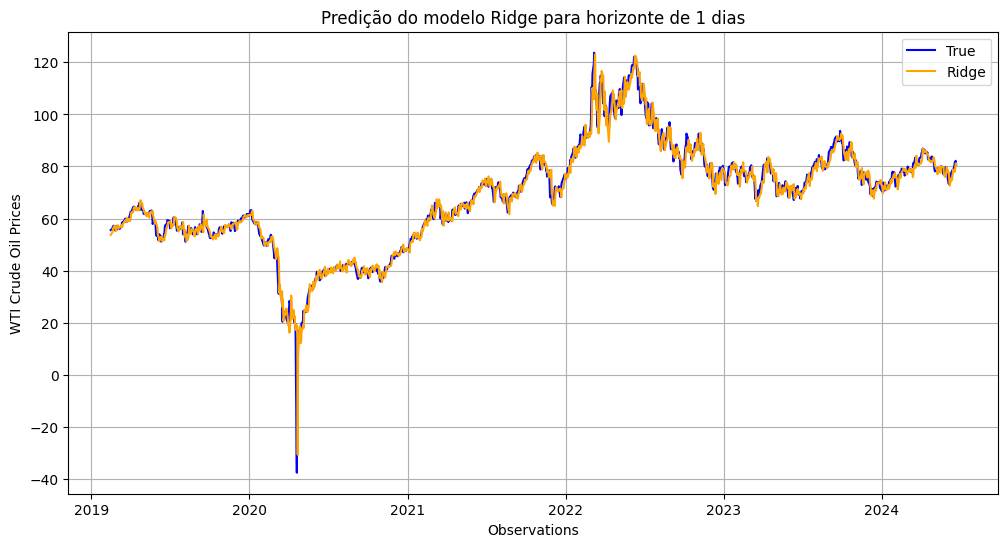

Modelo: Lasso - Tamanho de y_pred: 1344


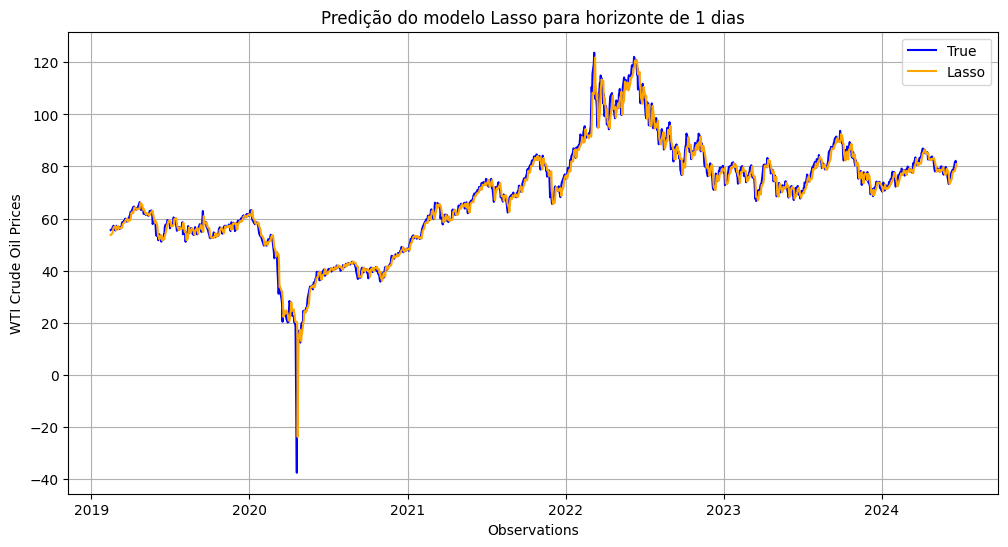

Modelo: SVR - Tamanho de y_pred: 1344


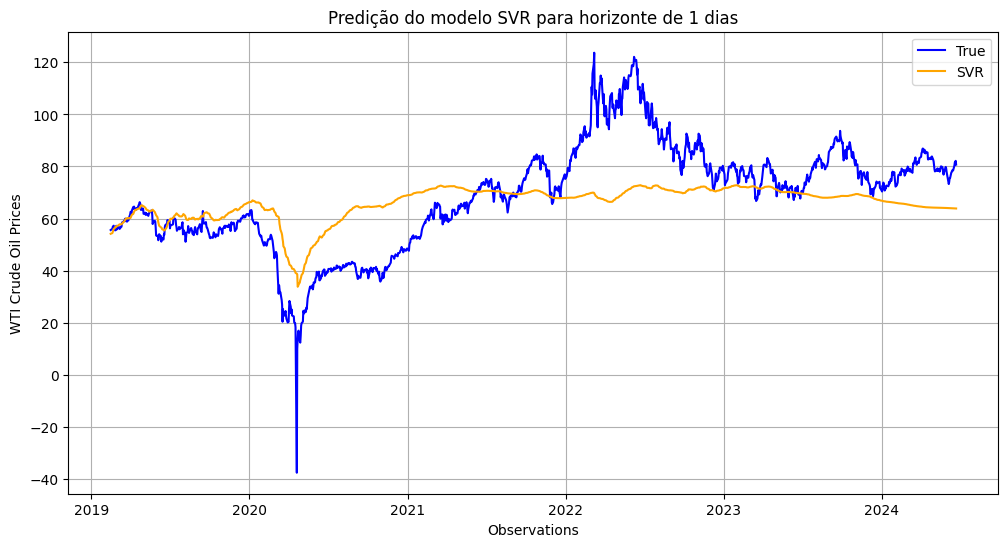

Horizonte: 2 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


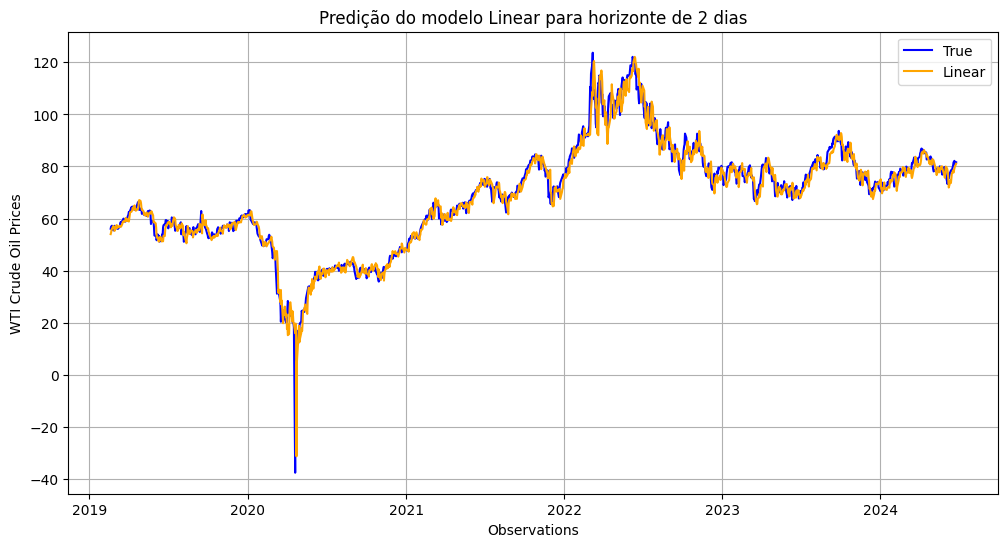

Modelo: Ridge - Tamanho de y_pred: 1344


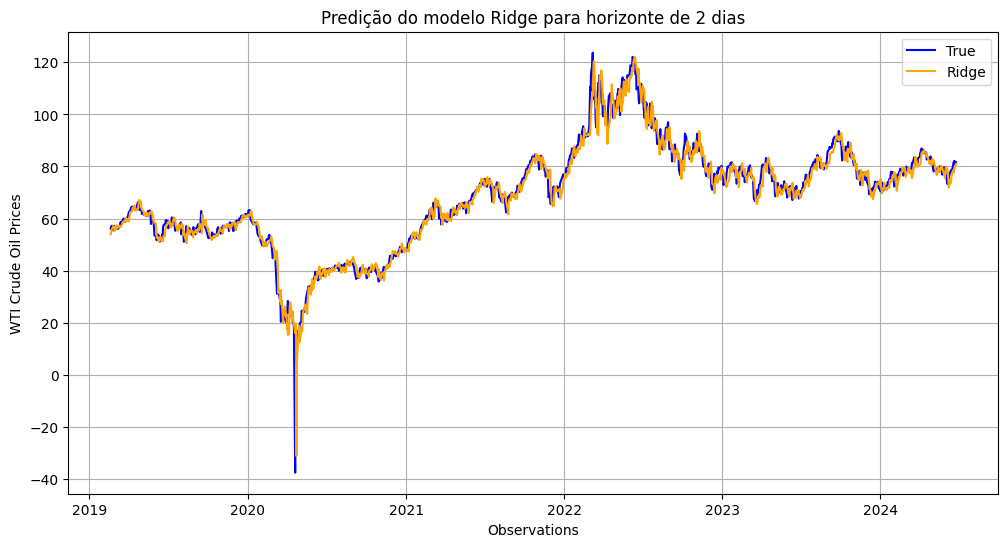

Modelo: Lasso - Tamanho de y_pred: 1344


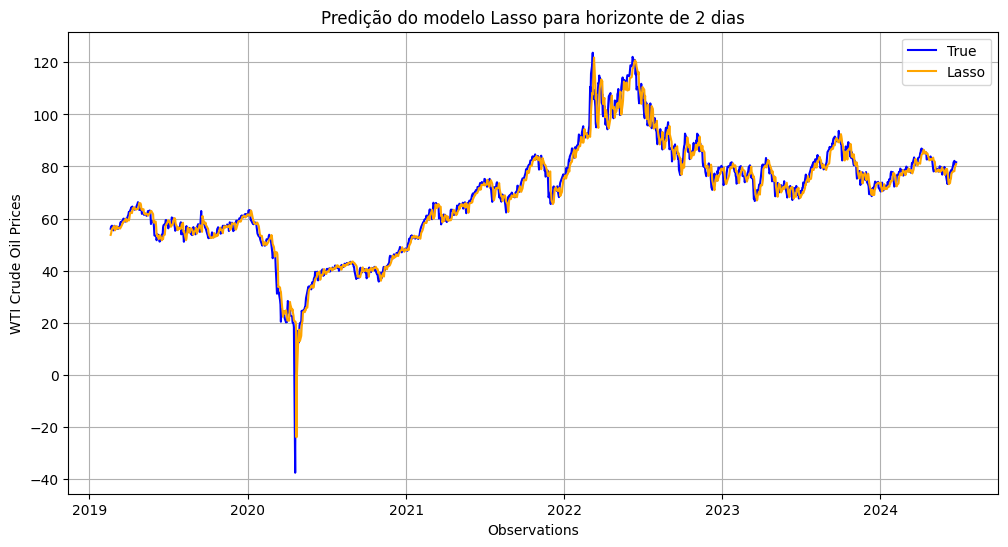

Modelo: SVR - Tamanho de y_pred: 1344


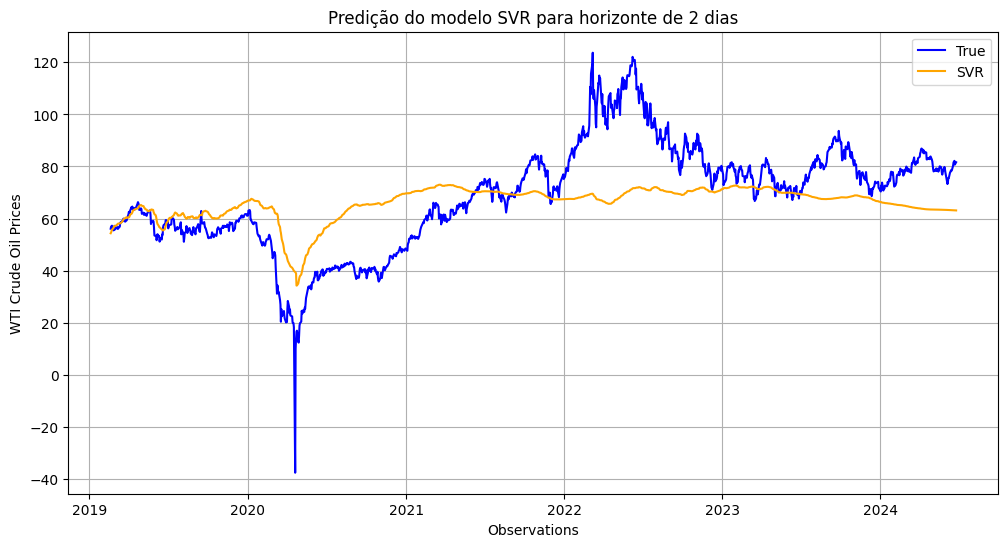

Horizonte: 3 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


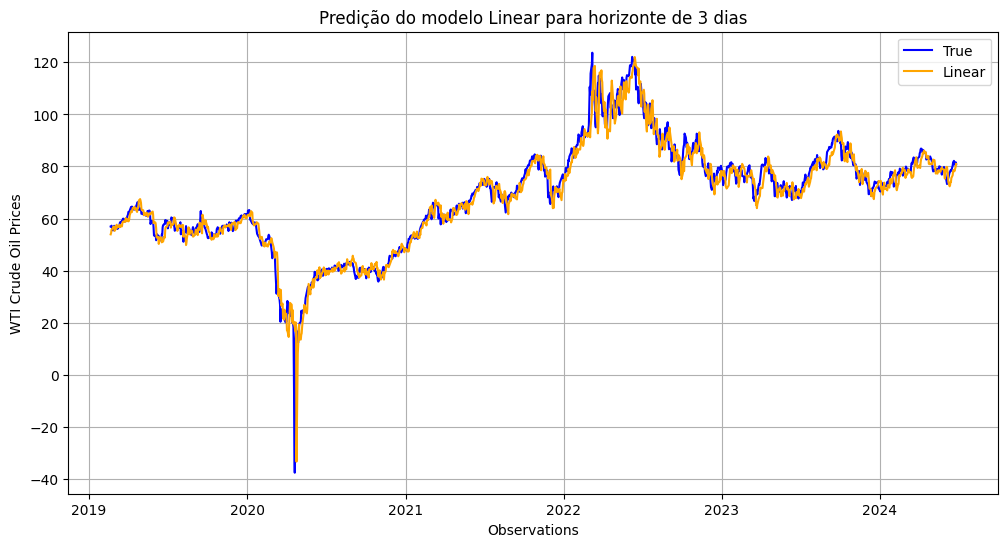

Modelo: Ridge - Tamanho de y_pred: 1344


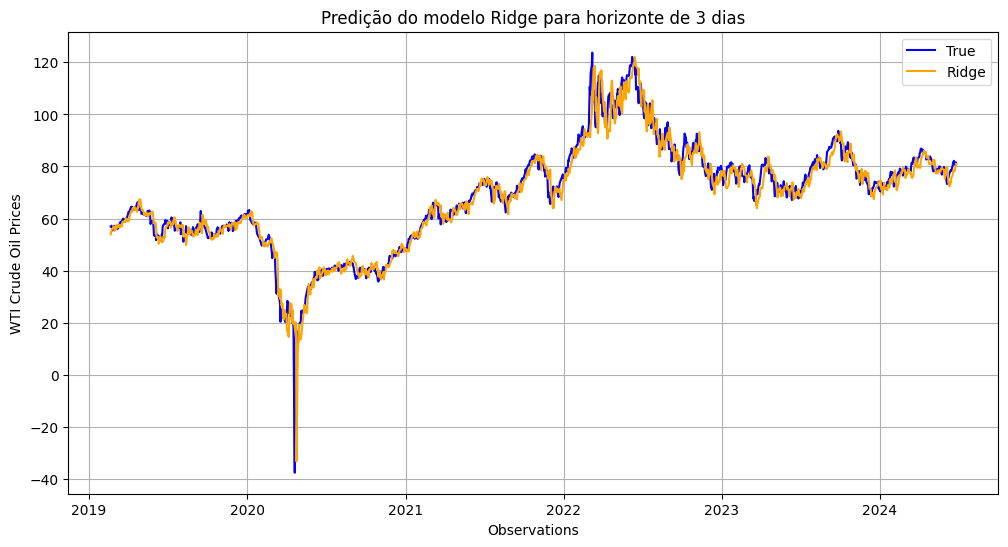

Modelo: Lasso - Tamanho de y_pred: 1344


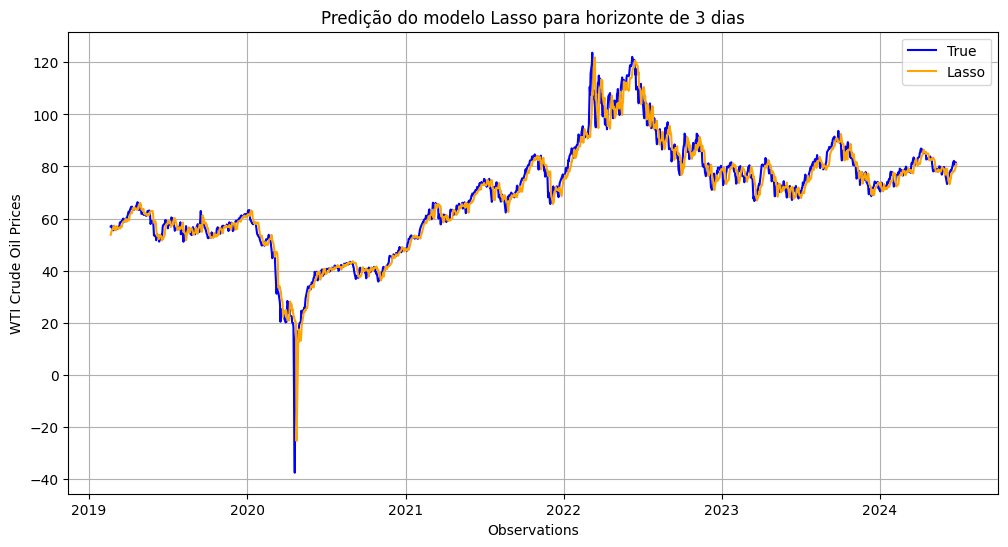

Modelo: SVR - Tamanho de y_pred: 1344


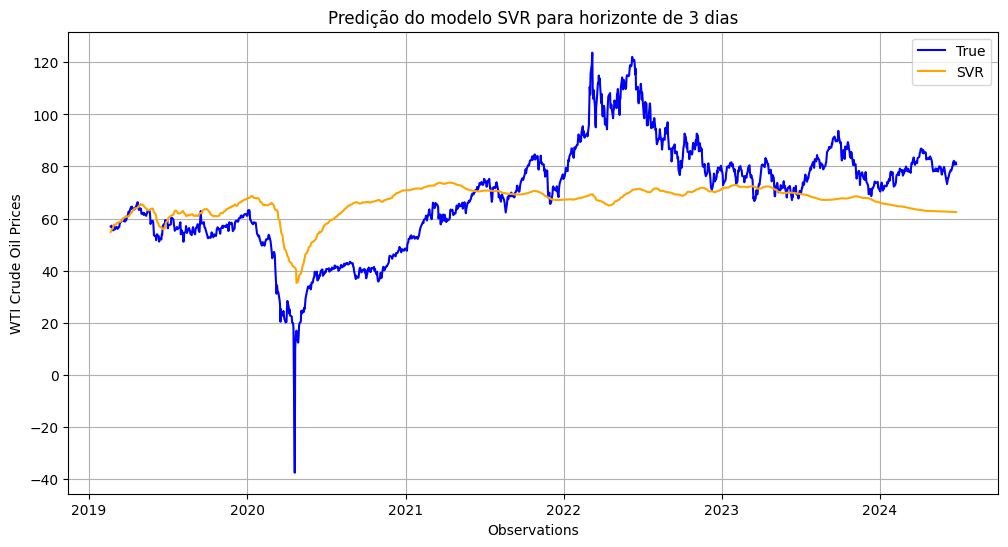

Horizonte: 4 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


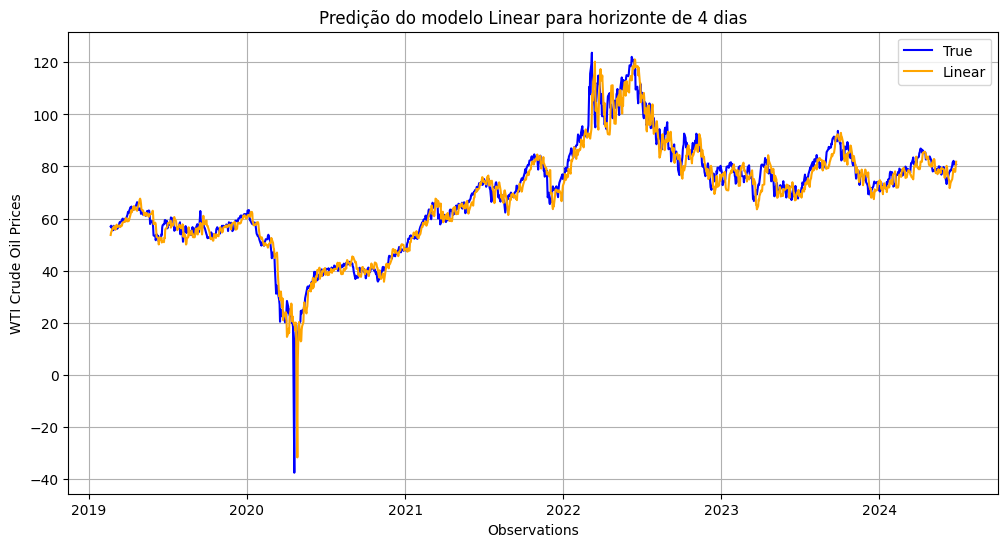

Modelo: Ridge - Tamanho de y_pred: 1344


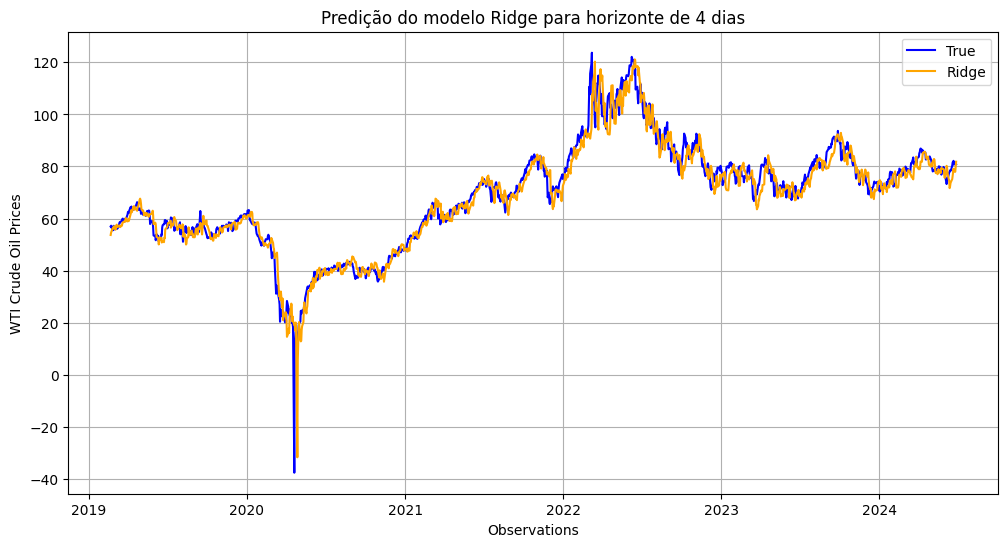

Modelo: Lasso - Tamanho de y_pred: 1344


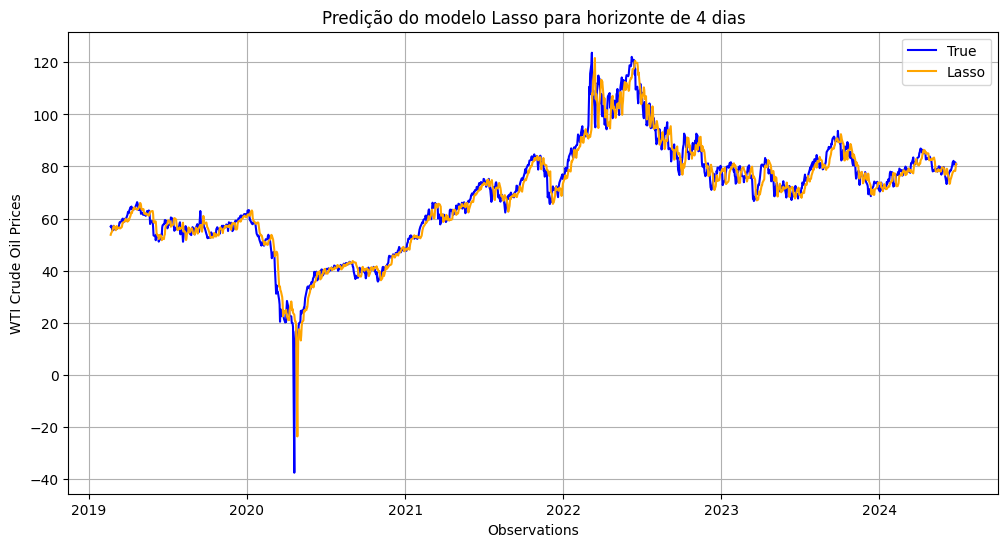

Modelo: SVR - Tamanho de y_pred: 1344


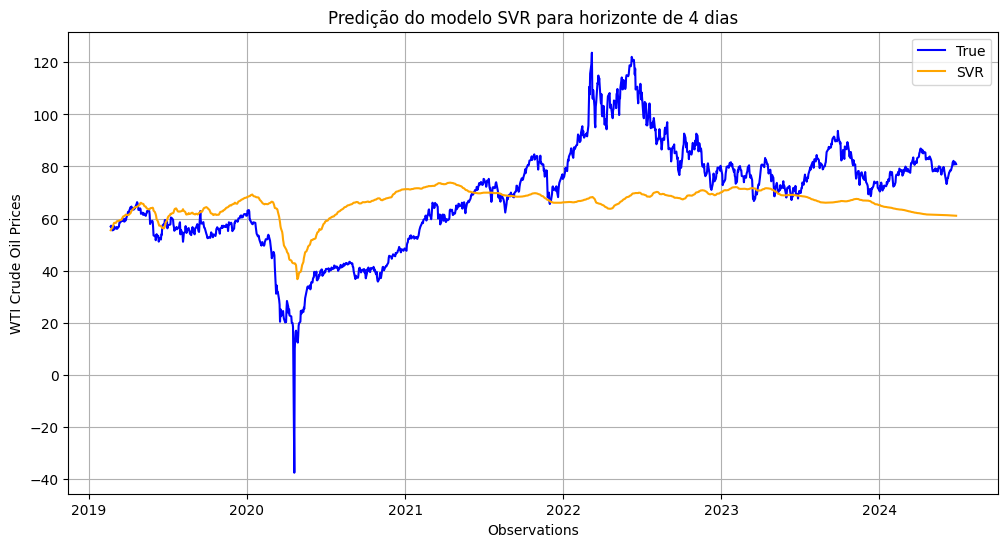

Horizonte: 5 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


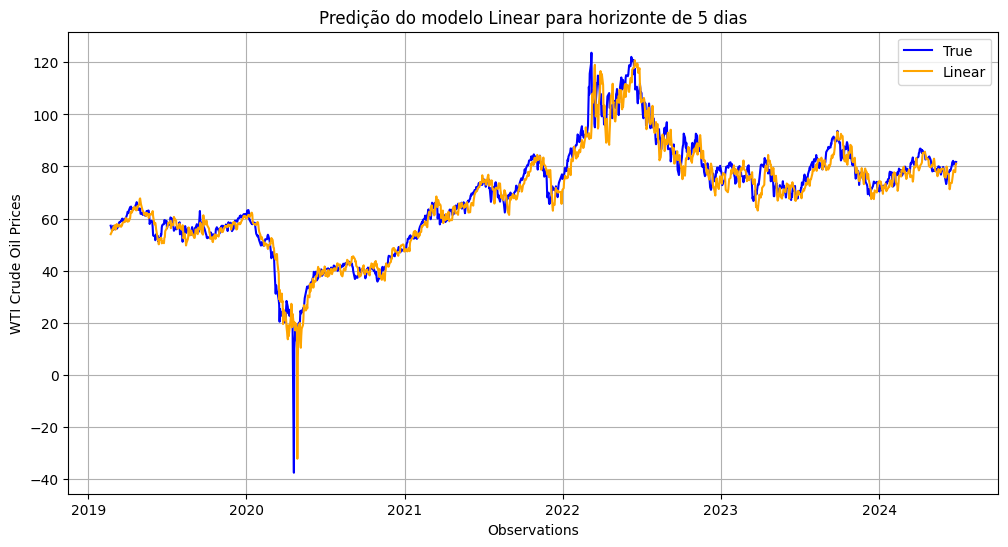

Modelo: Ridge - Tamanho de y_pred: 1344


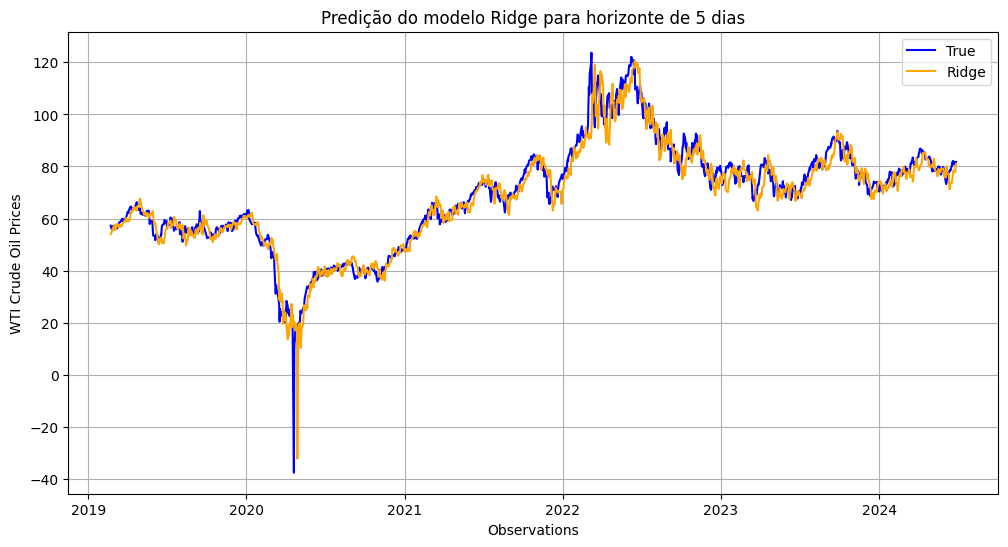

Modelo: Lasso - Tamanho de y_pred: 1344


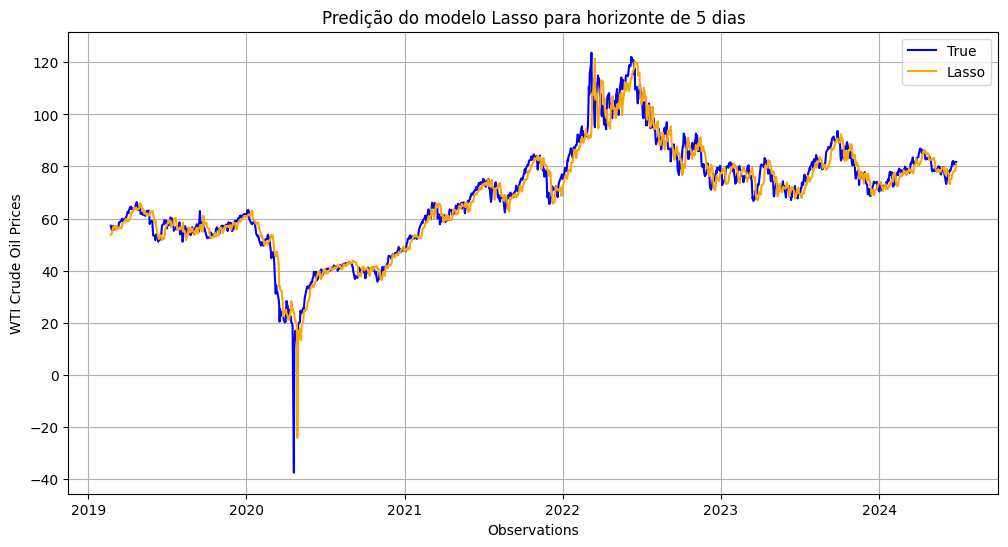

Modelo: SVR - Tamanho de y_pred: 1344


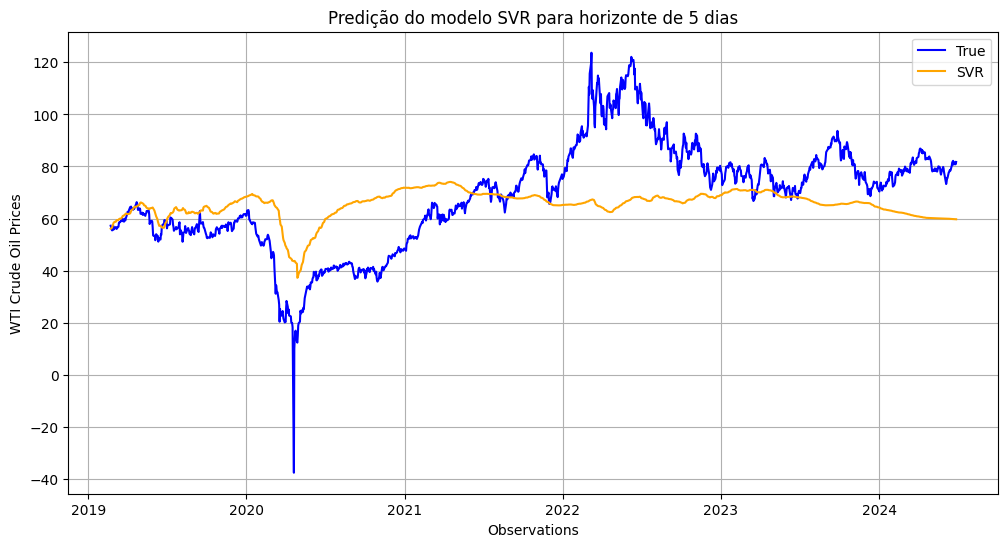

Horizonte: 6 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


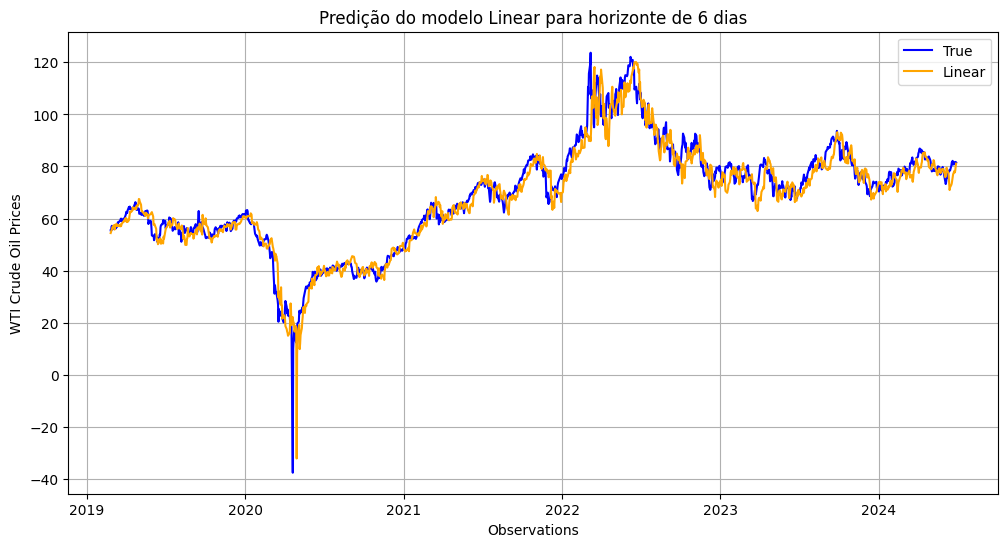

Modelo: Ridge - Tamanho de y_pred: 1344


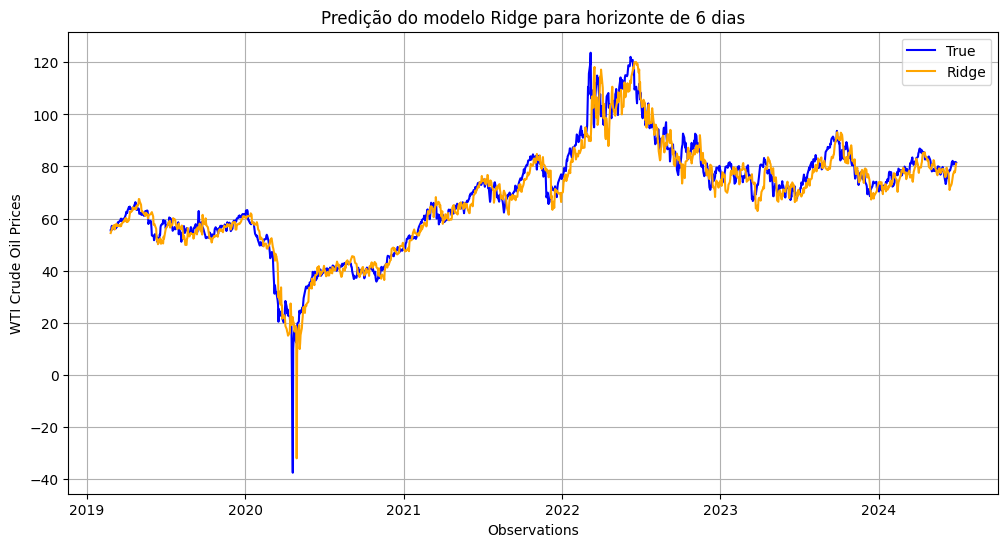

Modelo: Lasso - Tamanho de y_pred: 1344


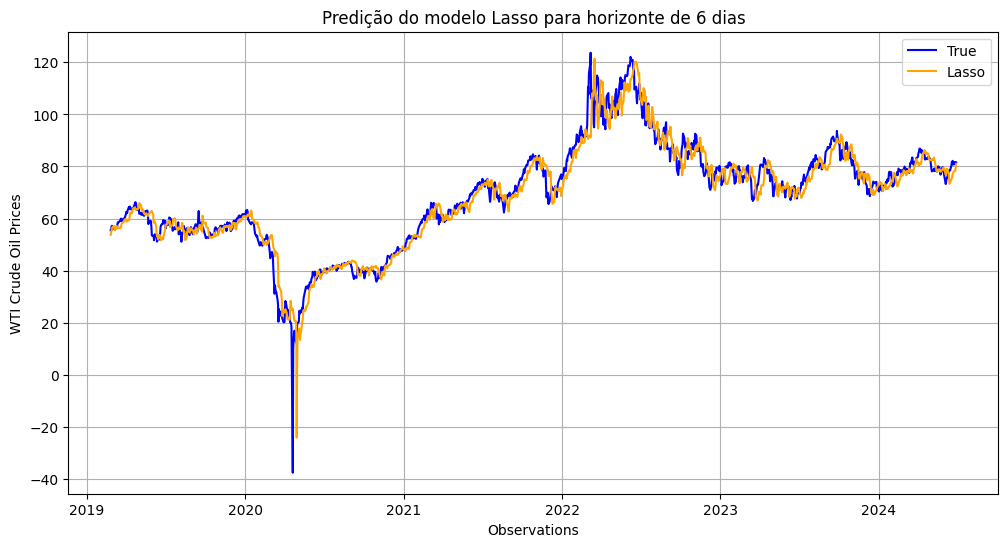

Modelo: SVR - Tamanho de y_pred: 1344


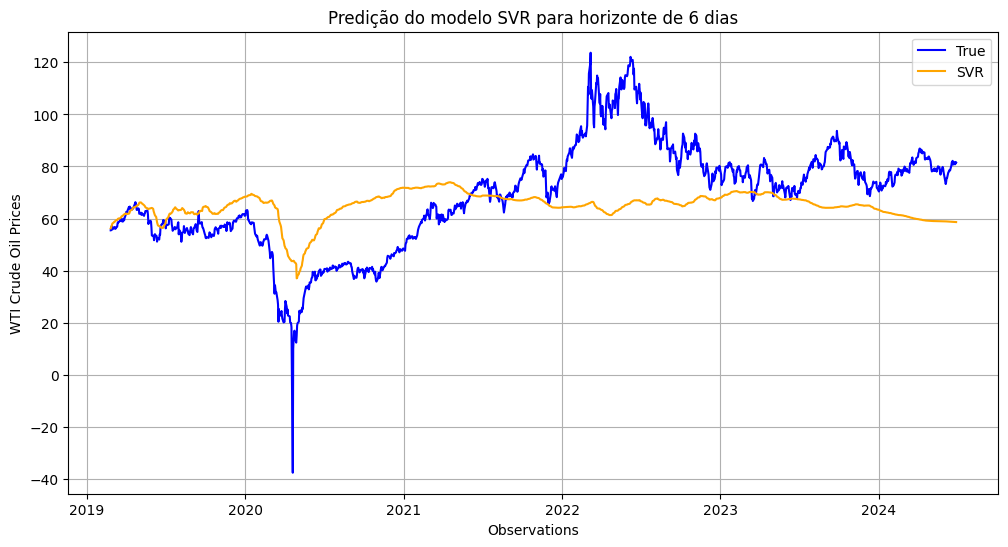

Horizonte: 7 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


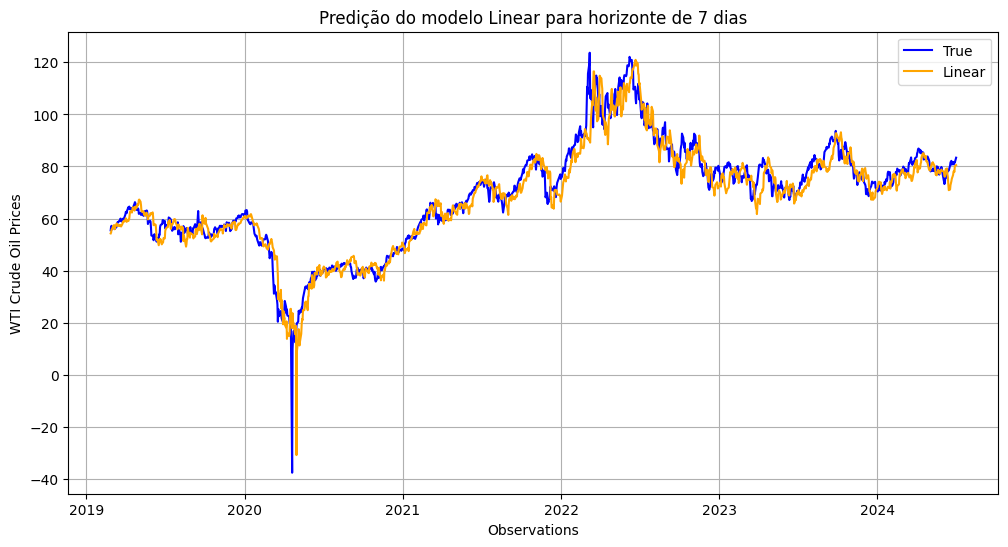

Modelo: Ridge - Tamanho de y_pred: 1344


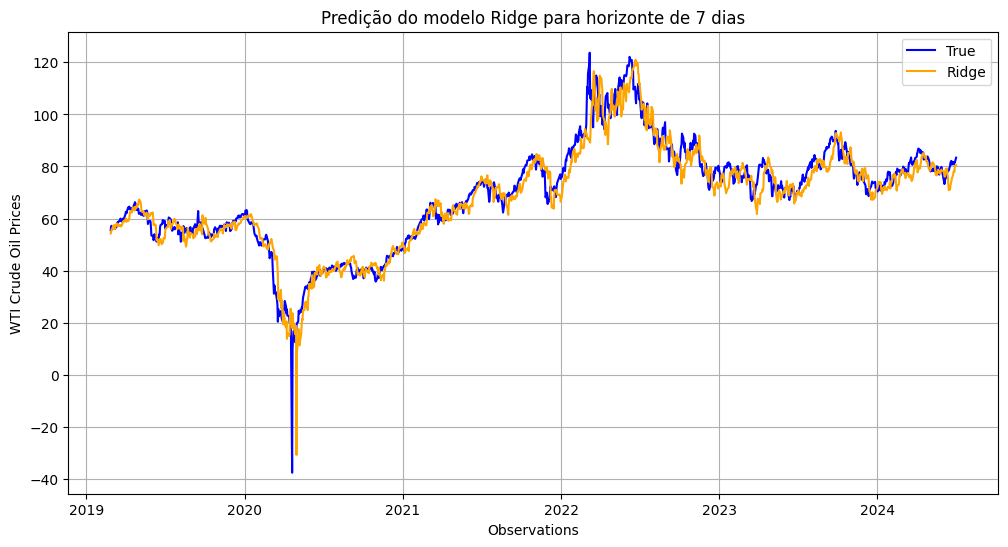

Modelo: Lasso - Tamanho de y_pred: 1344


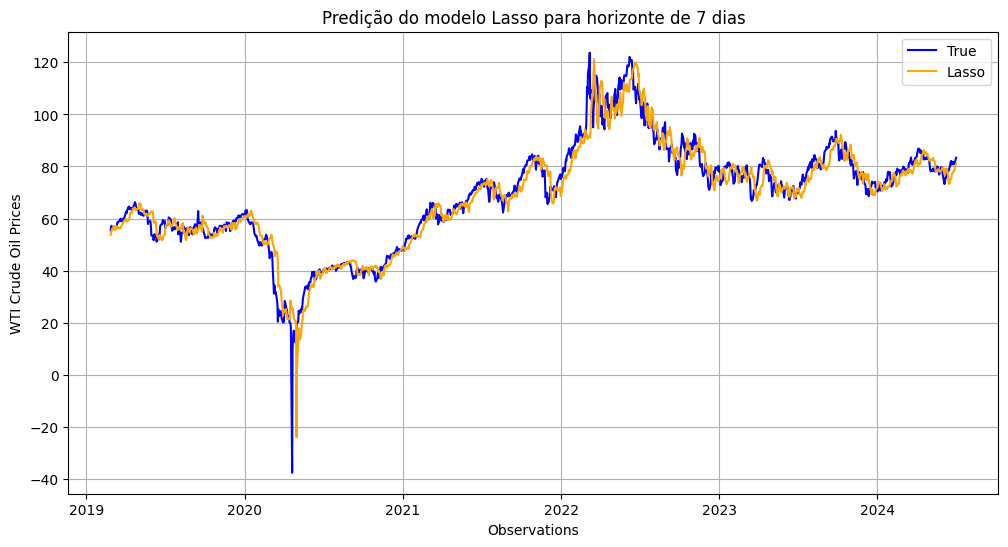

Modelo: SVR - Tamanho de y_pred: 1344


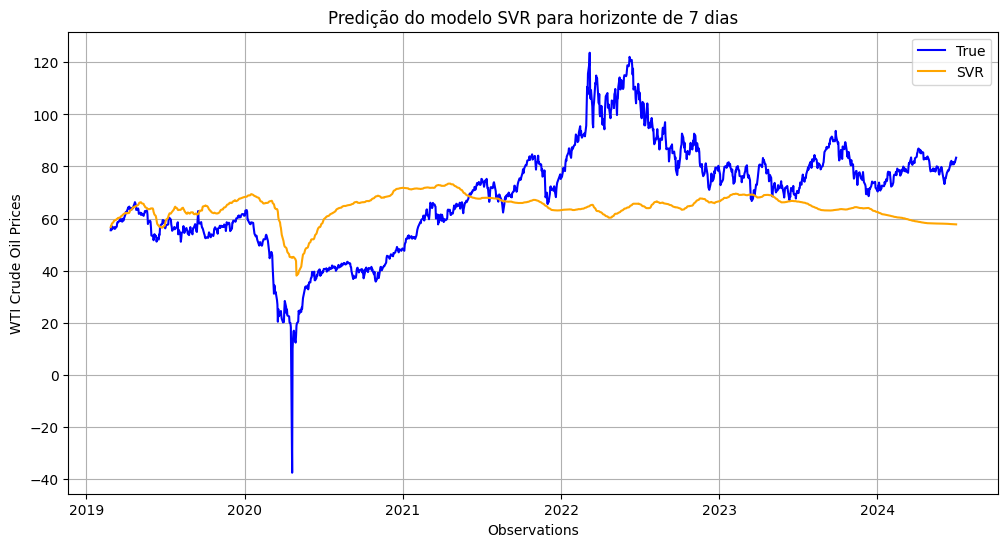

Horizonte: 8 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


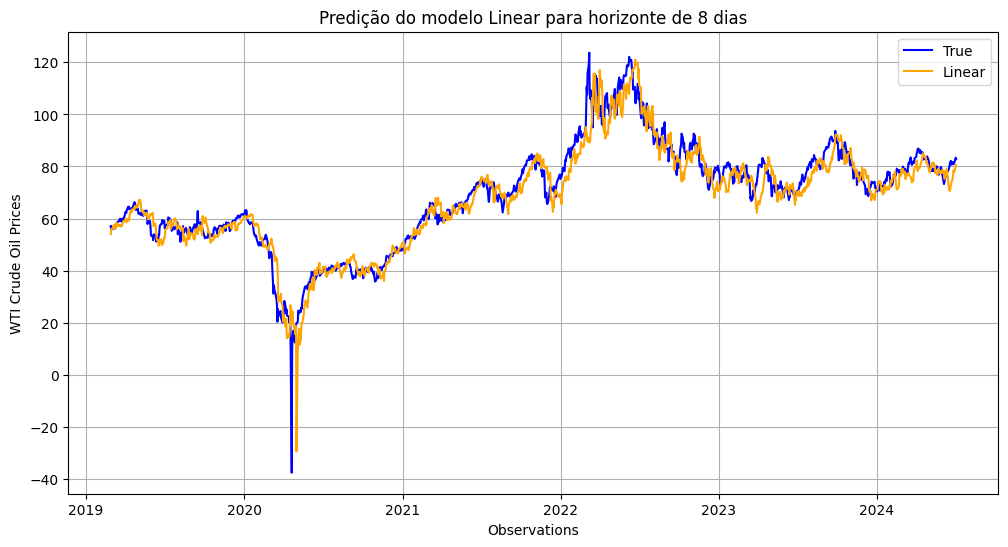

Modelo: Ridge - Tamanho de y_pred: 1344


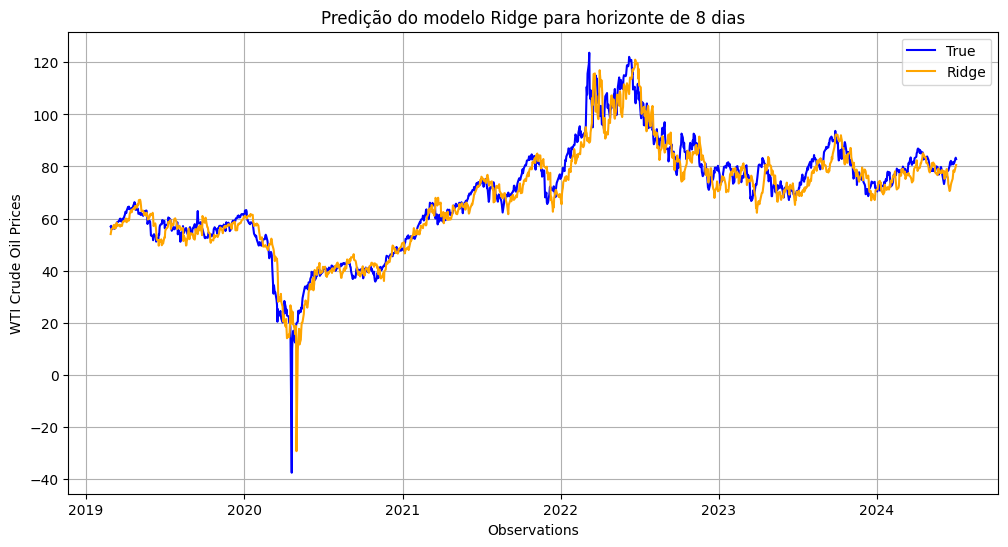

Modelo: Lasso - Tamanho de y_pred: 1344


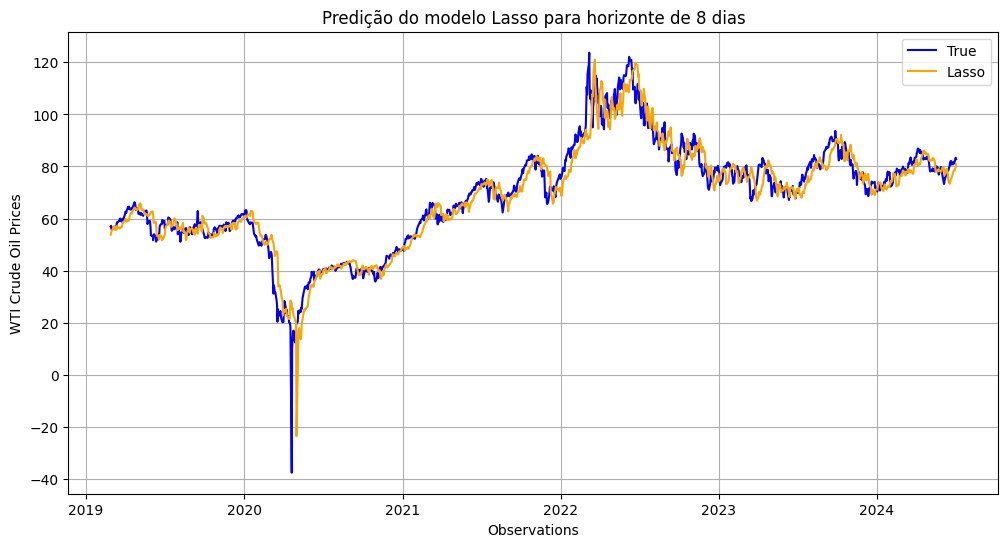

Modelo: SVR - Tamanho de y_pred: 1344


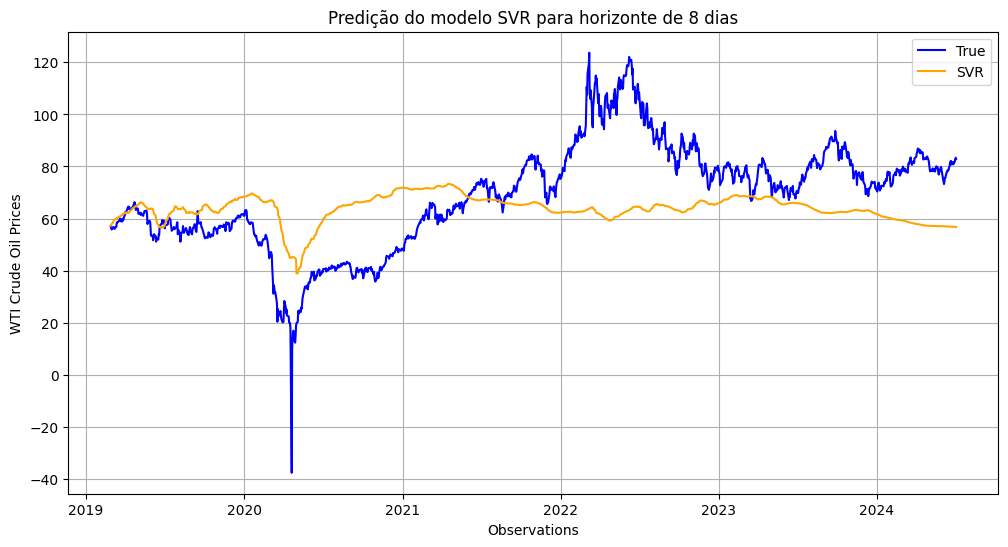

Horizonte: 9 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


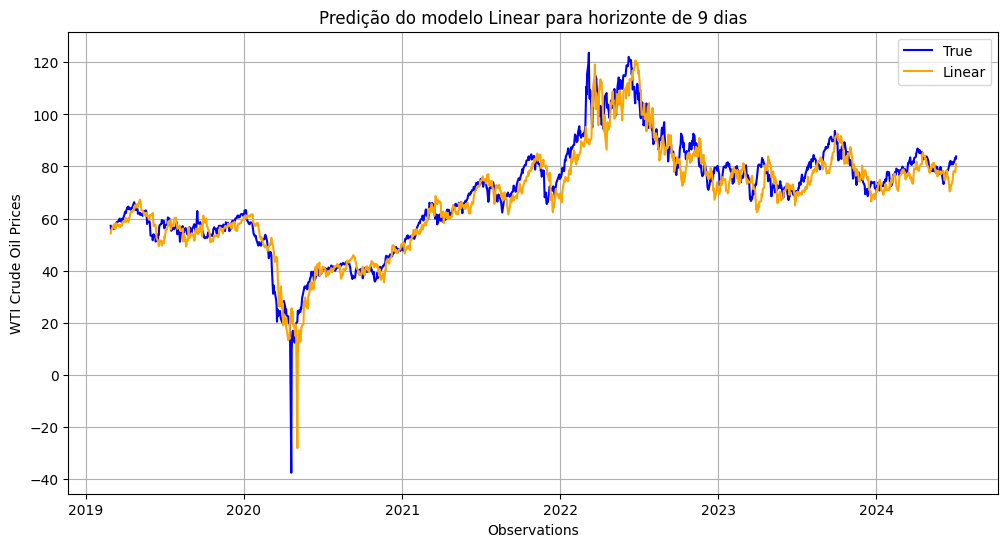

Modelo: Ridge - Tamanho de y_pred: 1344


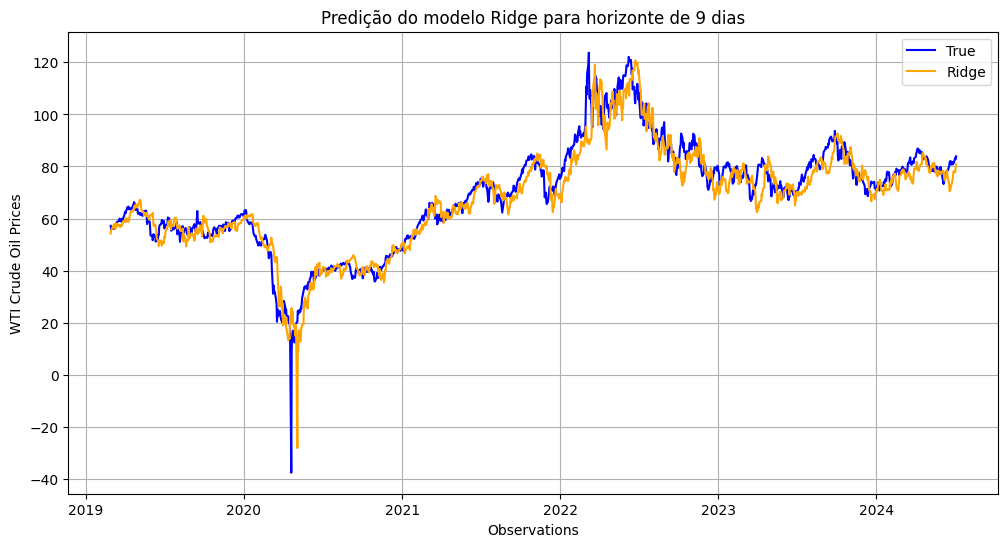

Modelo: Lasso - Tamanho de y_pred: 1344


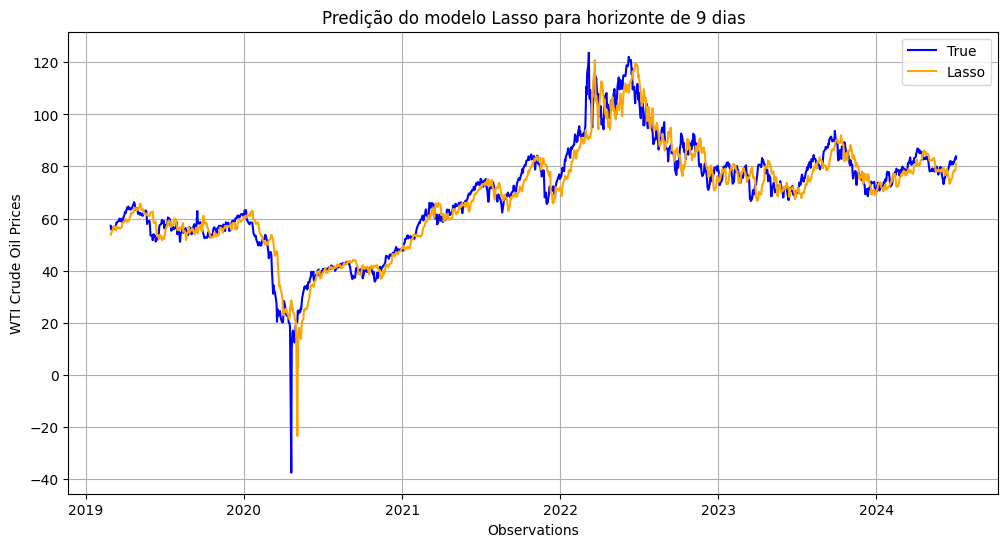

Modelo: SVR - Tamanho de y_pred: 1344


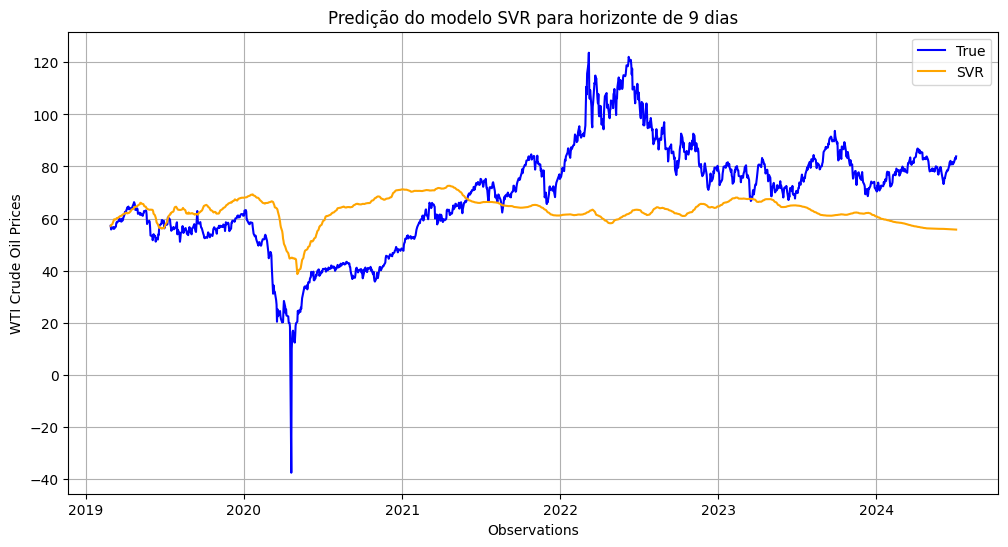

Horizonte: 10 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


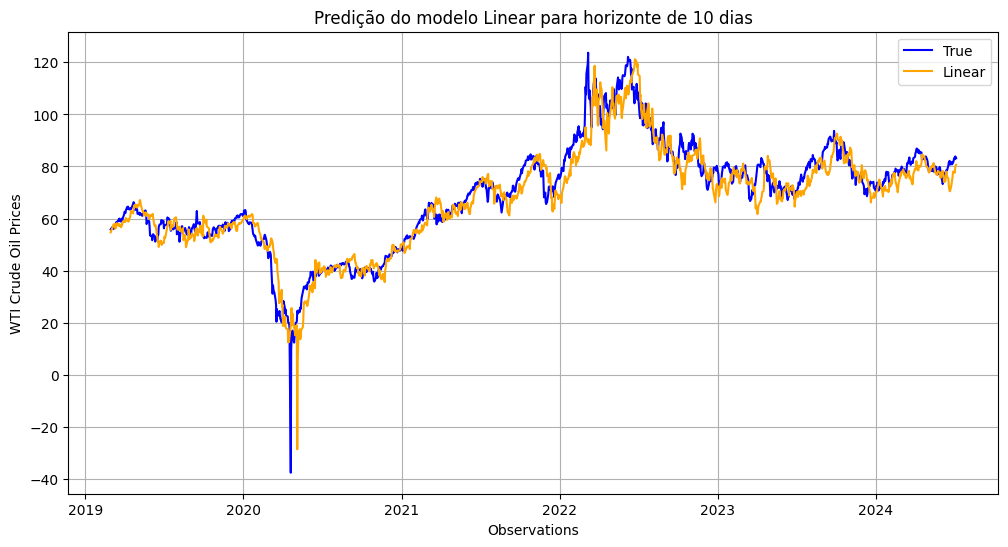

Modelo: Ridge - Tamanho de y_pred: 1344


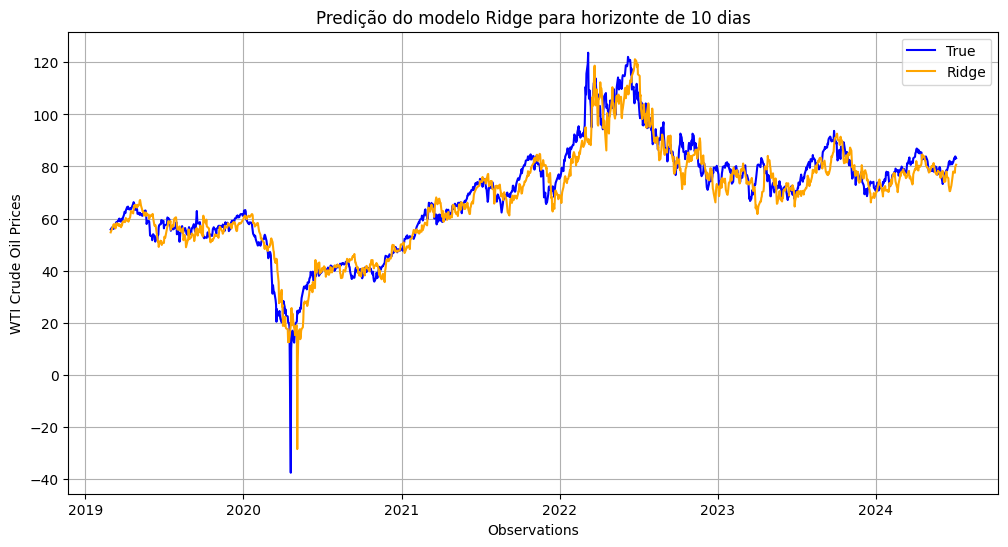

Modelo: Lasso - Tamanho de y_pred: 1344


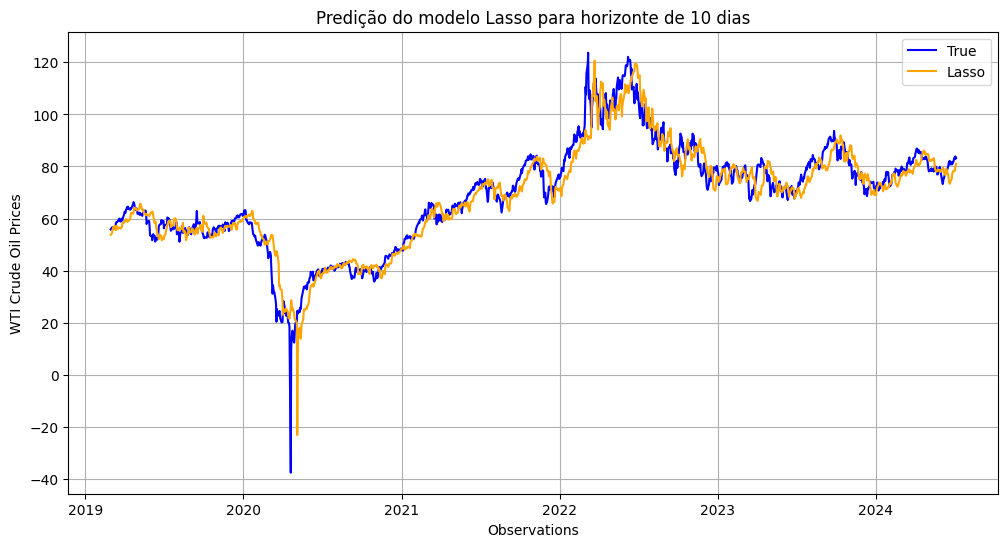

Modelo: SVR - Tamanho de y_pred: 1344


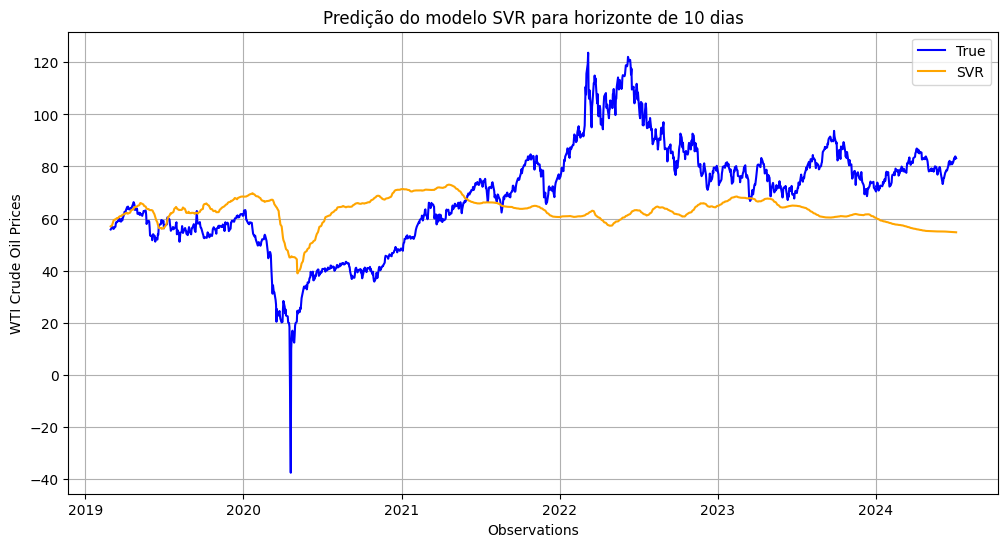

Horizonte: 11 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


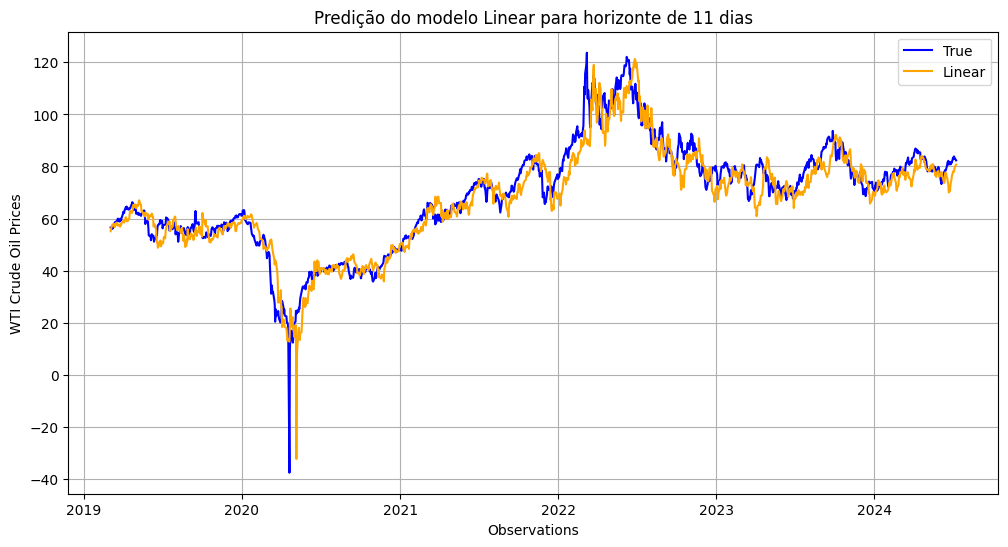

Modelo: Ridge - Tamanho de y_pred: 1344


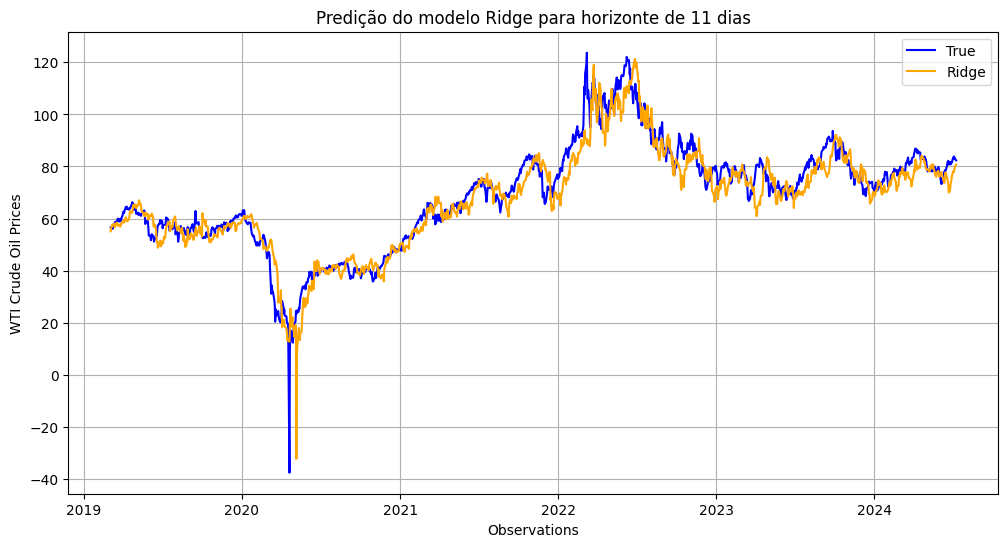

Modelo: Lasso - Tamanho de y_pred: 1344


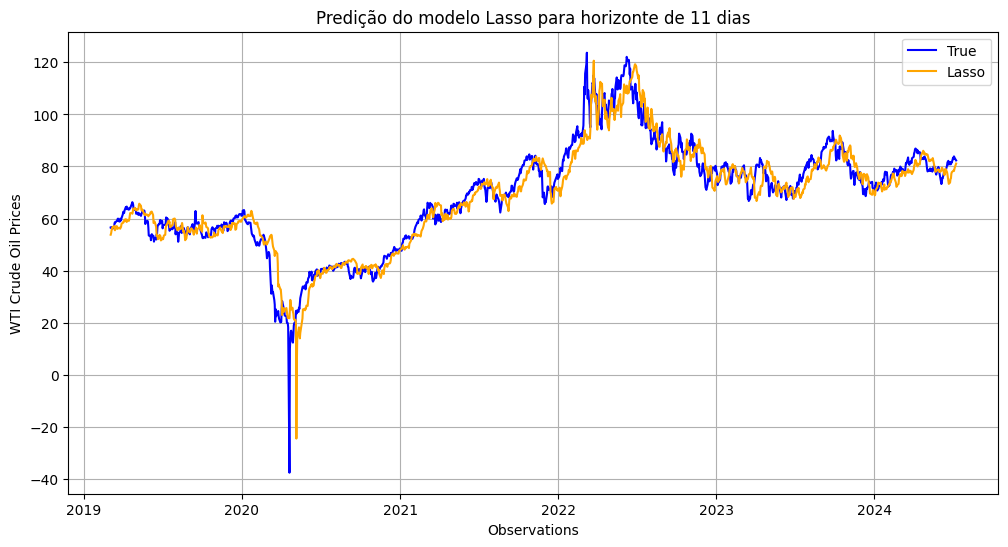

Modelo: SVR - Tamanho de y_pred: 1344


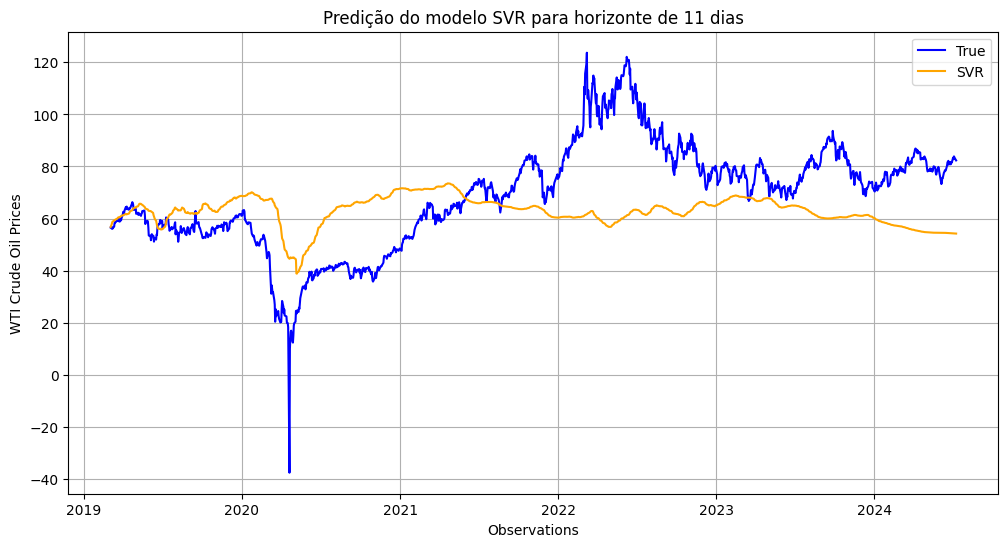

Horizonte: 12 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


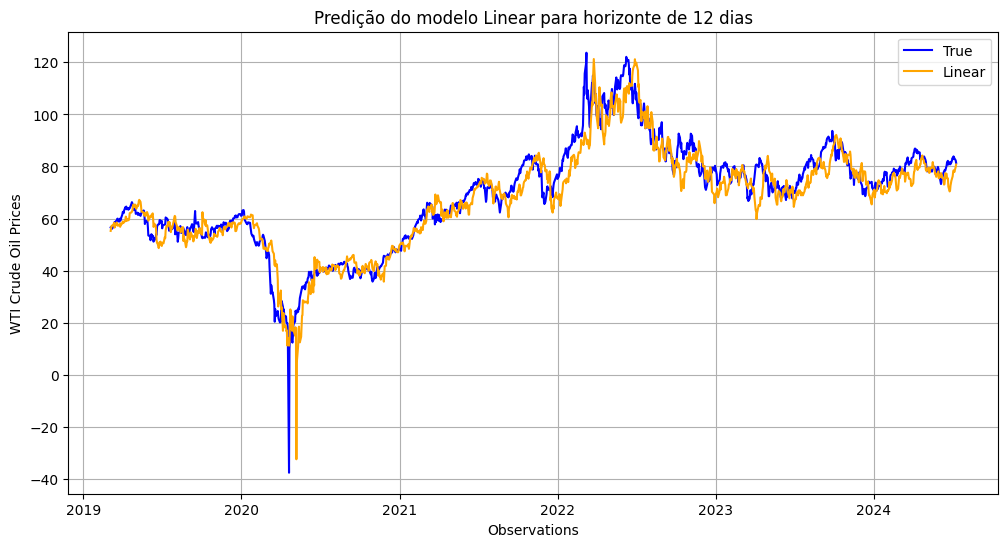

Modelo: Ridge - Tamanho de y_pred: 1344


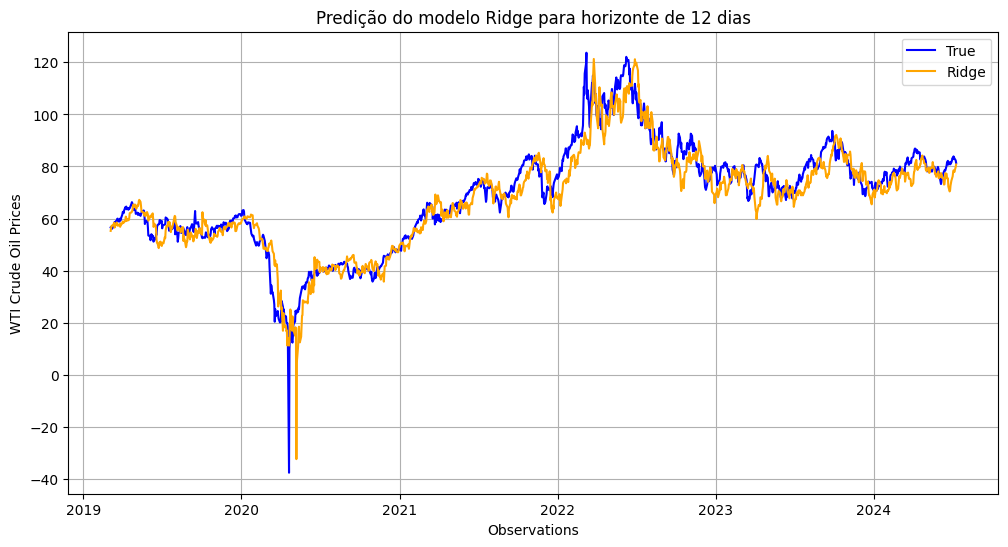

Modelo: Lasso - Tamanho de y_pred: 1344


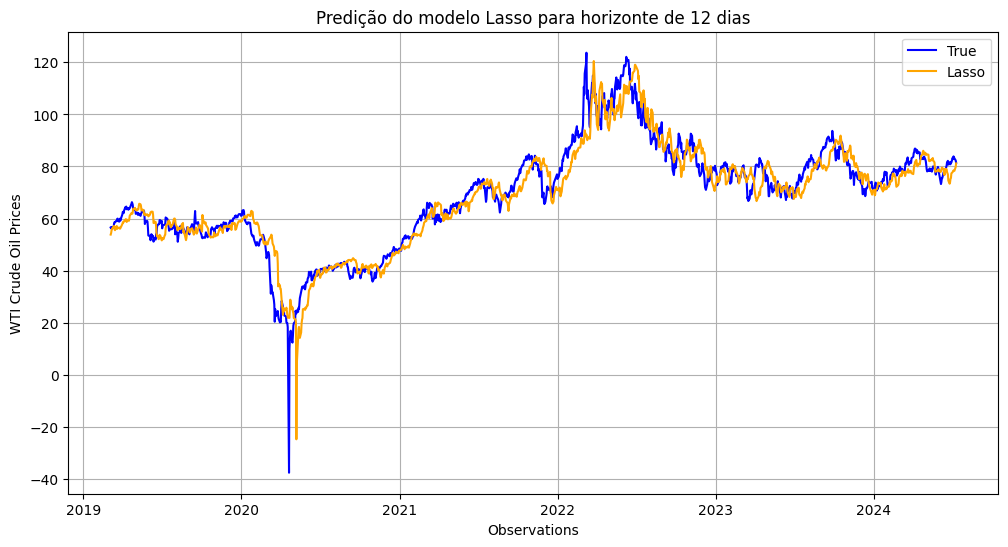

Modelo: SVR - Tamanho de y_pred: 1344


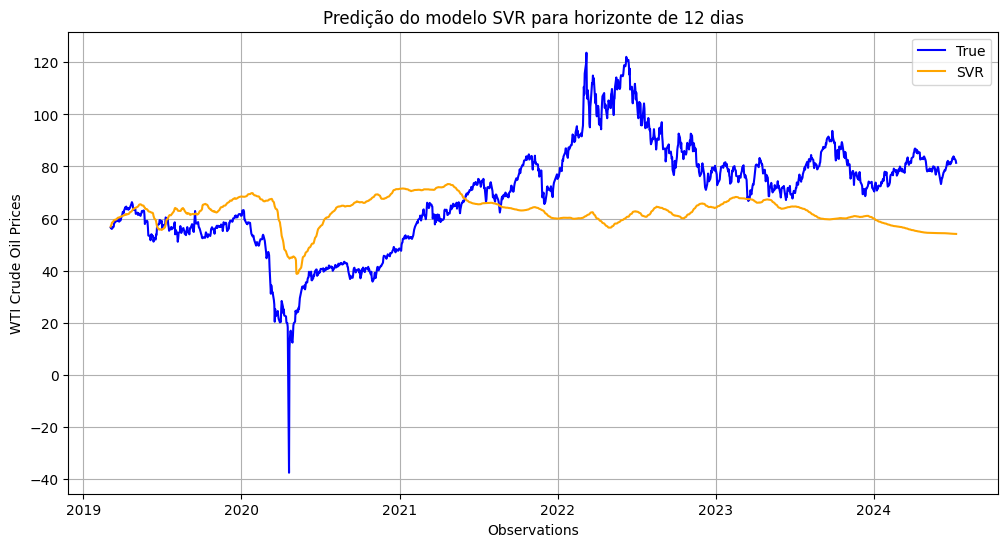

Horizonte: 13 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


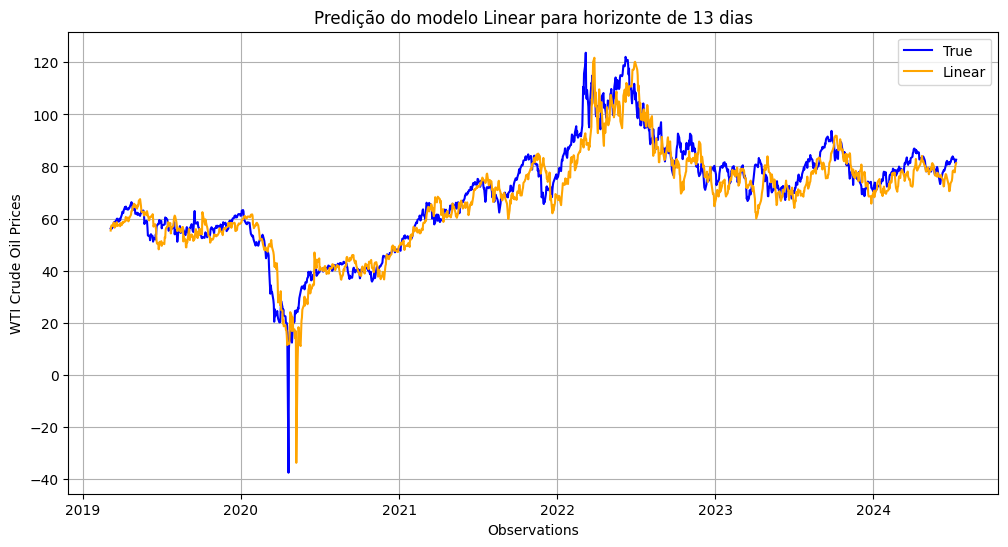

Modelo: Ridge - Tamanho de y_pred: 1344


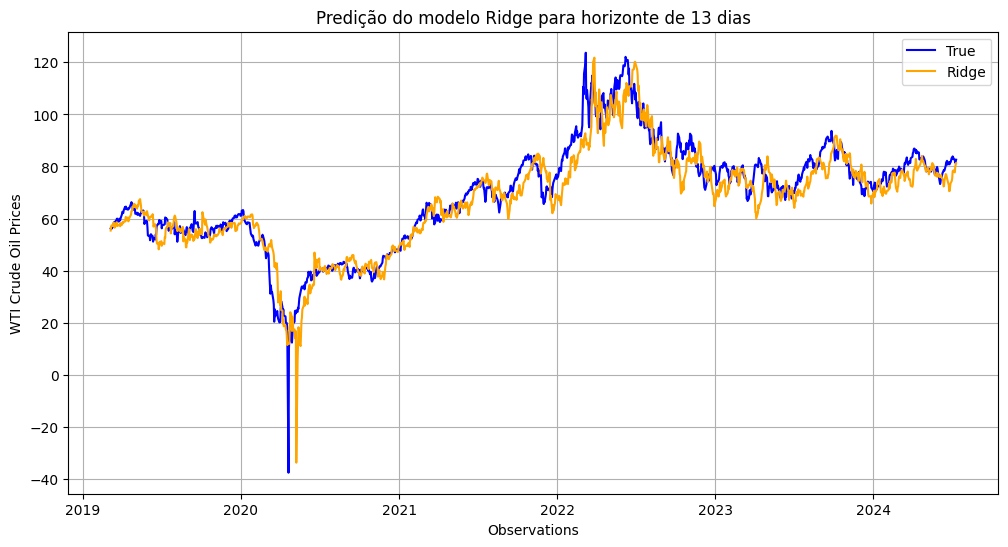

Modelo: Lasso - Tamanho de y_pred: 1344


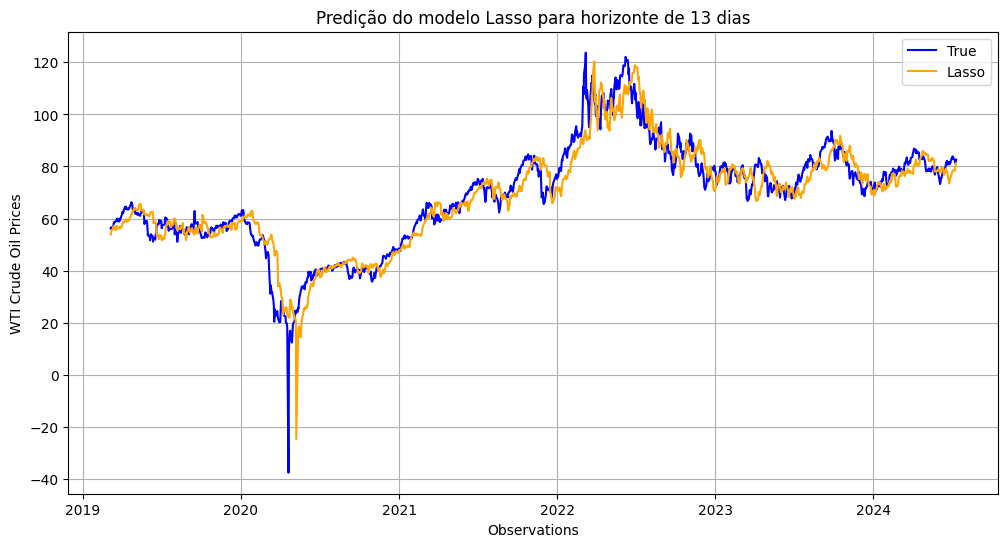

Modelo: SVR - Tamanho de y_pred: 1344


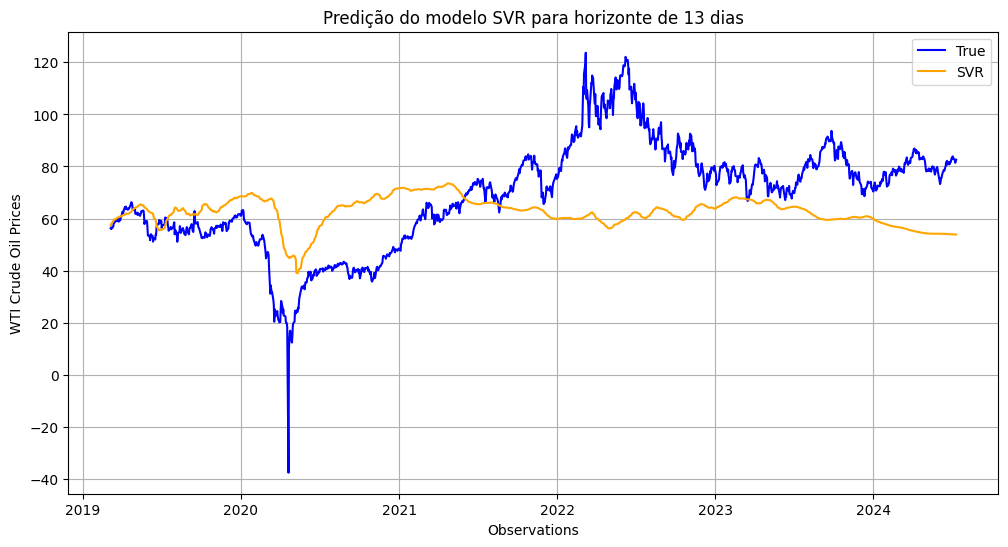

Horizonte: 14 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


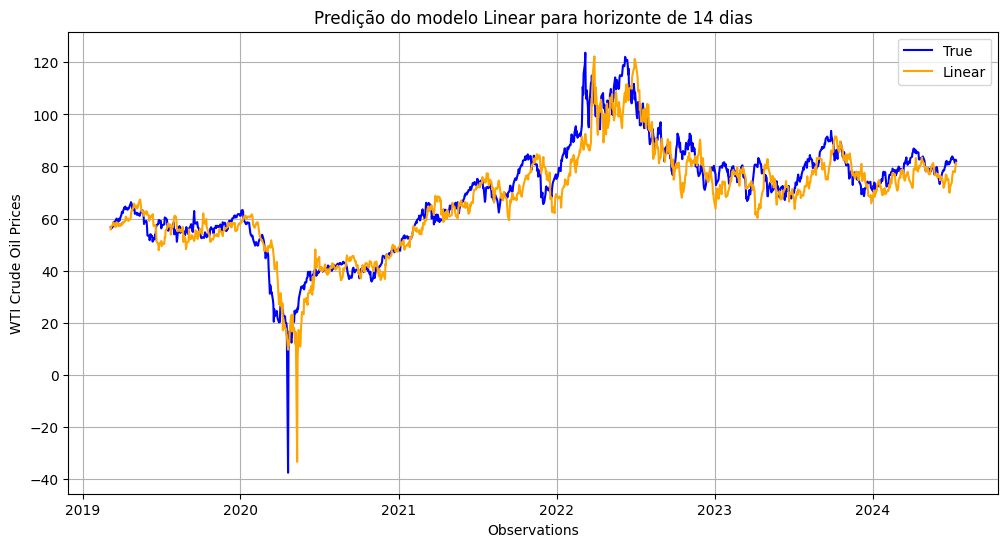

Modelo: Ridge - Tamanho de y_pred: 1344


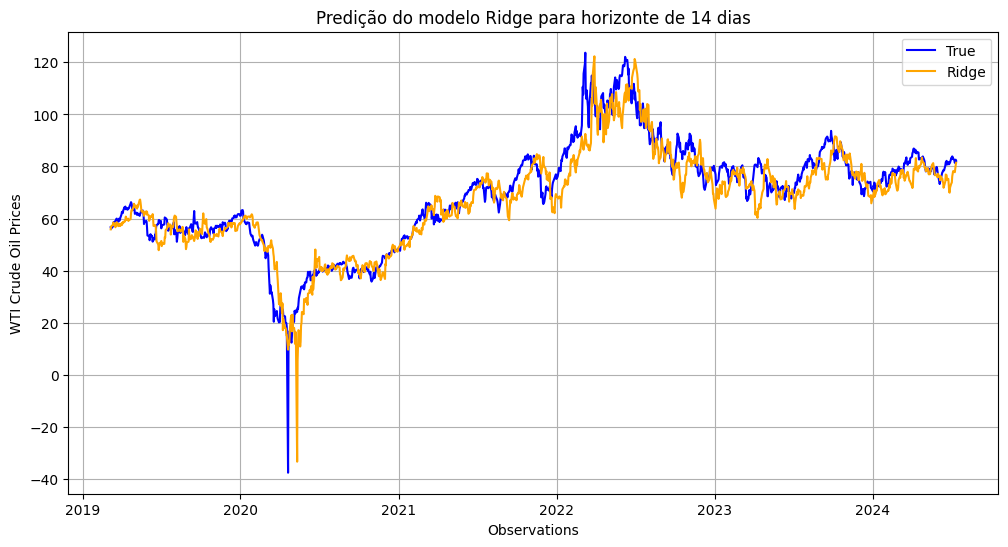

Modelo: Lasso - Tamanho de y_pred: 1344


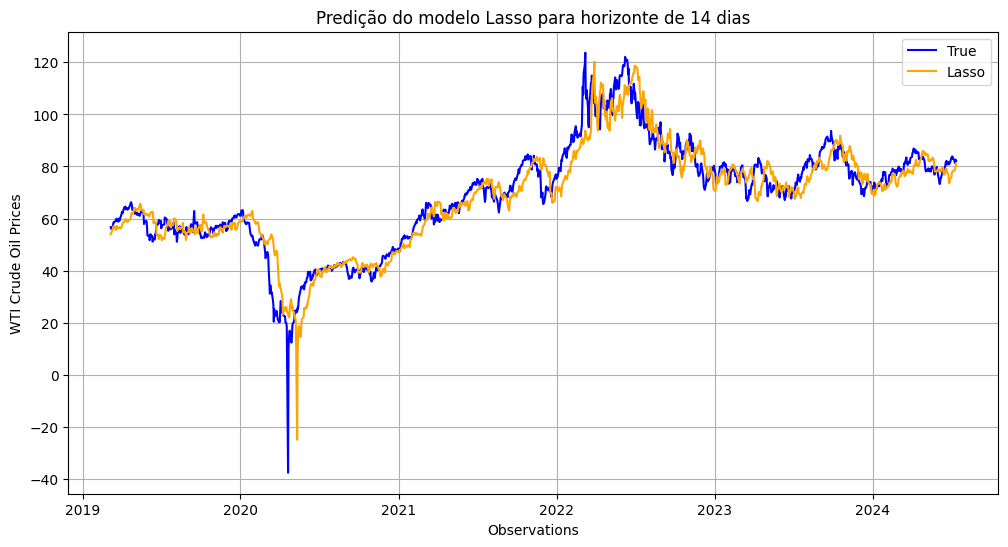

Modelo: SVR - Tamanho de y_pred: 1344


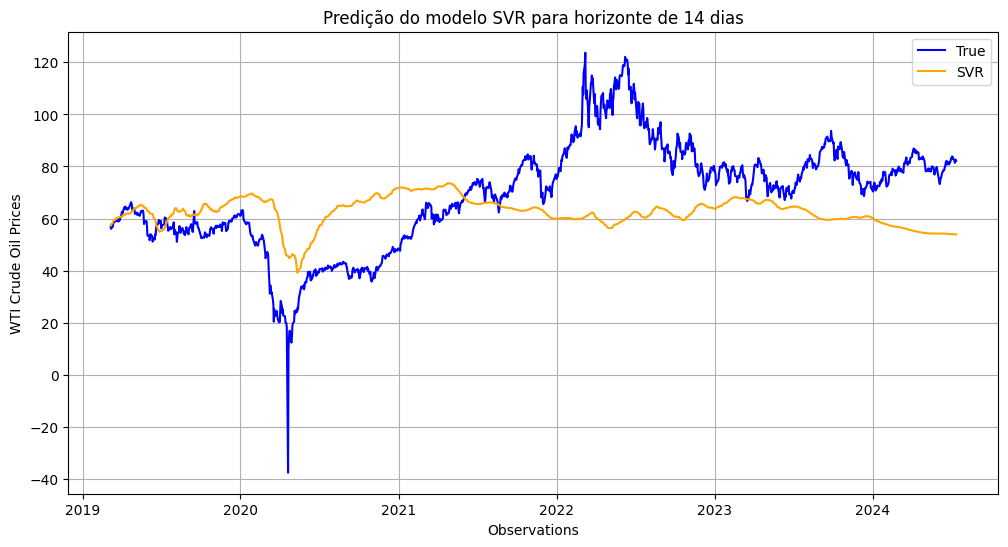

Horizonte: 15 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


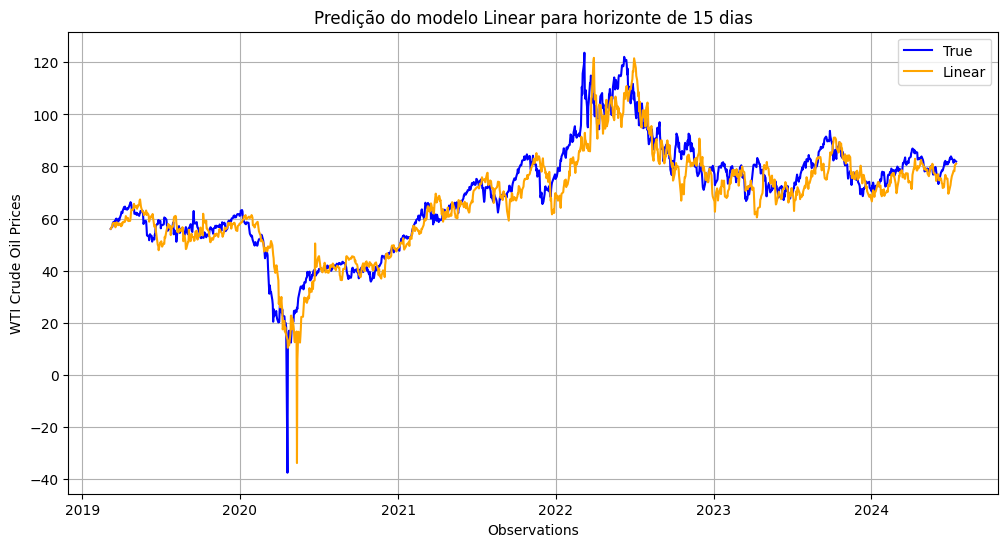

Modelo: Ridge - Tamanho de y_pred: 1344


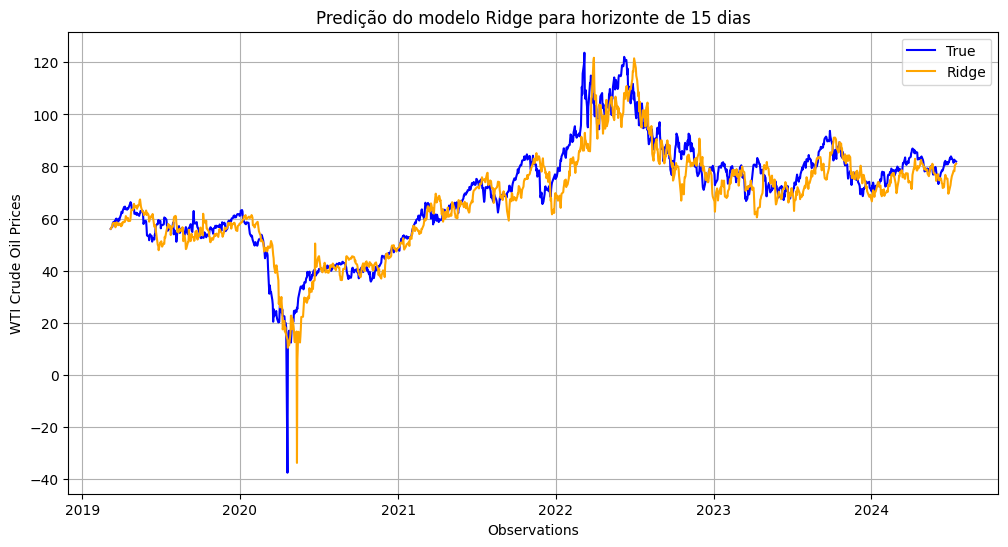

Modelo: Lasso - Tamanho de y_pred: 1344


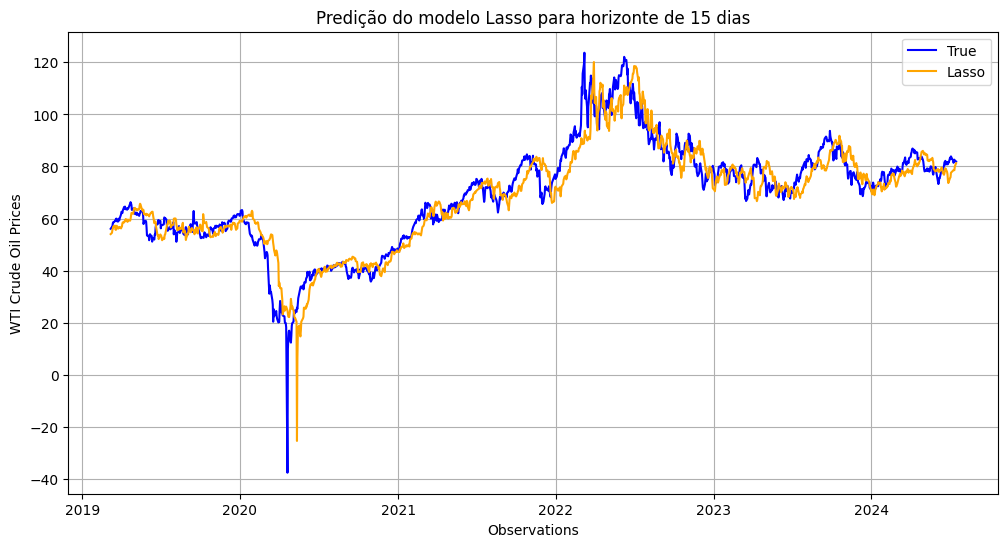

Modelo: SVR - Tamanho de y_pred: 1344


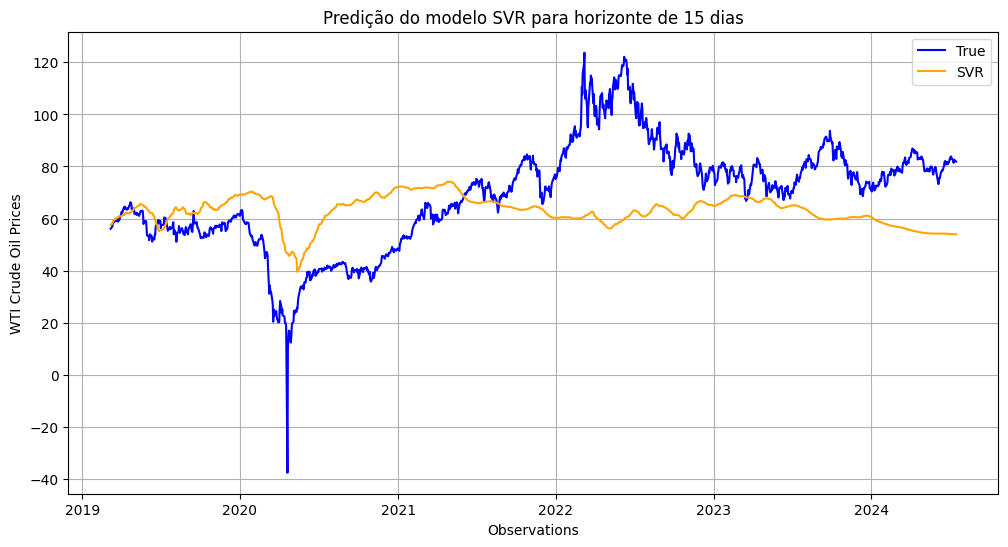

In [218]:
# Plotar previsões vs valores reais para cada modelo e horizonte com valores desescalados
for horizon in yht.keys():  # Agora estamos lidando com 10 horizontes
    X = Xht
    y_test = yht[horizon]  # Obtém o y_test correto para cada horizonte
    print(f"Horizonte: {horizon} - Tamanho de y_test: {len(y_test)}")  # Adicionando print para y_test
    for name in models.keys():
        y_pred = results[horizon][name]["y_pred"]
        dt_x = Ht[horizon]
        
        print(f"Modelo: {name} - Tamanho de y_pred: {len(y_pred)}")  # Adicionando print para y_pred
        
        # Ajustar os tamanhos para garantir compatibilidade
        min_len = min(len(y_test), len(y_pred))
        y_test_aligned = y_test[-min_len:]
        y_pred_aligned = y_pred[-min_len:]
        
        plot_predictions(y_test_aligned, y_pred_aligned, name, horizon, Ht[horizon])

# Modelos horizontes -> predição mensal

In [219]:
# filter best models
best_models = {}
for h, hdict in results.items():
    for name, mdict in hdict.items():
        if "is_best" in mdict:
            best_models[h] = mdict["model"]
[id(m) for m in best_models.values()]

[128447567862928,
 128447552817136,
 128447555279296,
 128447555278720,
 128447554234848,
 128447518193072,
 128447518189712,
 128447554379760,
 128447554083408,
 128447554090224,
 128447554086240,
 128447554091712,
 128447554082832,
 128447554091616,
 128447553177824,
 128447553177056]

In [221]:
xx, yy, dt = create_features_and_targets_for_month(src_df, pd.Timestamp('2024-05-20'), window_size=30, target_column=config["target_col"])
xx, yy, dt

/home/dasilva/workspace/lamelas/smart_fuel_acquisitons/data.py:129: UserWarning: Expected date range is different from fetched data. The first different dates are 2024-05-01 00:00:00 vs. 2024-04-30 00:00:00.
  warnings.warn(f'Expected date range is different from fetched data. The first different dates are {expected} vs. {fetched}.')
/home/dasilva/workspace/lamelas/smart_fuel_acquisitons/data.py:148: UserWarning: Expected future date range is different from fetched data. The first different dates are 2024-05-27 00:00:00 vs. 2024-05-24 00:00:00.
  warnings.warn(f'Expected future date range is different from fetched data. The first different dates are {expected} vs. {fetched}.')


(array([[8.691000e+01, 5.204340e+03, 2.329750e+03, 2.747570e+01,
         1.083700e+00, 1.001416e+02],
        [8.643000e+01, 5.202390e+03, 2.339030e+03, 2.785050e+01,
         1.085900e+00, 1.004096e+02],
        [8.523000e+01, 5.209910e+03, 2.352780e+03, 2.815200e+01,
         1.085700e+00, 1.009363e+02],
        [8.621000e+01, 5.160640e+03, 2.334040e+03, 2.794810e+01,
         1.074300e+00, 1.005680e+02],
        [8.502000e+01, 5.199060e+03, 2.372520e+03, 2.844370e+01,
         1.072600e+00, 1.000732e+02],
        [8.566000e+01, 5.123410e+03, 2.344370e+03, 2.787730e+01,
         1.064300e+00, 9.934560e+01],
        [8.541000e+01, 5.061820e+03, 2.383340e+03, 2.887200e+01,
         1.062400e+00, 9.949500e+01],
        [8.536000e+01, 5.051410e+03, 2.382890e+03, 2.810700e+01,
         1.061900e+00, 9.997320e+01],
        [8.269000e+01, 5.022210e+03, 2.361020e+03, 2.822330e+01,
         1.067300e+00, 1.004001e+02],
        [8.273000e+01, 5.011120e+03, 2.379040e+03, 2.824460e+01,
        

In [223]:
eval_start_date = '2021-01-01'
eval_end_date = '2024-06-01'
eval_range = src_df.loc[eval_start_date:eval_end_date].index
# remove days after day X
eval_range = eval_range[eval_range.day < 20]

# group time index by year and month
wed_range = eval_range[eval_range.weekday == 2]

wed_df = pd.DataFrame(index=eval_range, data={'year': eval_range.year, 'month': eval_range.month})

range_business_days = pd.date_range(start=eval_start_date, end=eval_end_date, freq='B')


In [423]:
def day_to_month_prices(x: pd.Series):
    """
    Daily prices to monthly average price and also previous monthly average price.
    May loose days at the beginning of the series
    """
    avg = x.resample('ME').transform('mean')
    prev_avg = avg.resample("ME").last().shift(1).resample('D').bfill().dropna()

    start_date = prev_avg.index[0]
    end_date = avg.index[-1]

    avg = avg.loc[start_date:end_date]
    prev_avg = prev_avg.loc[avg.index]

    # change series name
    avg.name = 'Monthly Average'
    prev_avg.name = 'Previous Month Average'

    return avg, prev_avg

def get_nth_wed(start, end, n):
    dt_range = pd.date_range(start=start, end=end, freq='B')
    wed_mask = dt_range.weekday == 2
    wed_df = pd.DataFrame(index=dt_range[wed_mask], data={'year': dt_range.year[wed_mask], 'month': dt_range.month[wed_mask], 'day': dt_range.day[wed_mask]})
    return wed_df.groupby(['year', 'month']).nth(n).index

def filter_nth_wed(df, n):
    dt_index = get_nth_wed(df.index[0], df.index[-1], n)
    return df.loc[dt_index]

def create_decision_array(monthly_price, prev_monthly_price):
    '''
    pd.Series with timestamp index and monthly average price as values
    The decision is True if, 
    '''
    return monthly_price > prev_monthly_price

def simulate_decisions(decision: pd.Series, price_when_buying: pd.Series):
    """
    Each month we consume monthly_volume of oil.
    We can store fuel for 1 month.
    If decision is 1 (buy), we buy for the following month.
    If decision is 0, we do not buy for the follwing month.
    If there has been no purchase for the current month, we also buy for the current month.
    check if there has been any purchase for the current month.
    """
    
    bought_when = [None] * len(decision)
    bought_at_price = price_when_buying.copy()
    bought_at_price.iloc[:] = 0

    bought_at_price.iloc[0] = price_when_buying.iloc[0]
    bought_when[0] = 'this month'

    for i in range(0, len(decision)-1):
        # if this month has not been bought yet, buy
        if bought_at_price.iloc[i] == 0:
            bought_at_price.iloc[i] = price_when_buying.iloc[i]
            bought_when[i] = 'this month'
        
        # if decision is to buy, buy for next month 
        if decision.iloc[i] == 1:
            bought_at_price.iloc[i+1] = price_when_buying.iloc[i]
            bought_when[i+1] = 'last month'

    # check the last month, if it has not been bought in advance, buy
    if bought_at_price.iloc[-1] == 0:
        bought_at_price.iloc[-1] = price_when_buying.iloc[-1]
        bought_when[-1] = 'this month'


    return bought_at_price, pd.Series(bought_when, index=decision.index, name='bought_when')

In [330]:
avg, prev_avg = day_to_month_prices(src_df['WTI Crude Oil Prices'])

In [224]:
eval_start_date = '2021-01-01'
eval_end_date = '2024-06-01'
eval_range = src_df.loc[eval_start_date:eval_end_date].index

wed_mask = filtered_data.index.weekday == 2
test_mask = (filtered_data.index > '2020-01-01') & (filtered_data.index < '2024-06-01') & wed_mask

filtered_data[test_mask].groupby(['year', 'month']).nth(-2)

y_avg = src_df['WTI Crude Oil Prices'].resample('ME').transform('mean')
y_avg = y_avg.loc[eval_range]


y_avg_hat = []
valid_pred_days = []

y_avg_hat_dumb = []
for day in src_df.loc[eval_range].index:
    try:
        y_avg_hat_ = predict_month_avg(best_models, src_df, day, window_size=30, target_column=config["target_col"])
        y_avg_hat.append(y_avg_hat_)
        valid_pred_days.append(day)

        month_begins = day.replace(day=1)
        y_avg_hat_dumb_ = src_df.loc[month_begins:day]['WTI Crude Oil Prices'].mean()
        y_avg_hat_dumb.append(y_avg_hat_dumb_)
    except:
        continue

y_avg_df = pd.DataFrame(data={'y_avg': y_avg, 'y_avg_hat': y_avg_hat, "y_avg_dumb": y_avg_hat_dumb}, index=valid_pred_days)
y_avg_df

/home/dasilva/workspace/lamelas/smart_fuel_acquisitons/data.py:129: UserWarning: Expected date range is different from fetched data. The first different dates are 2021-01-01 00:00:00 vs. 2020-12-31 00:00:00.
  warnings.warn(f'Expected date range is different from fetched data. The first different dates are {expected} vs. {fetched}.')
/home/dasilva/workspace/lamelas/smart_fuel_acquisitons/data.py:148: UserWarning: Expected future date range is different from fetched data. The first different dates are 2021-01-18 00:00:00 vs. 2021-01-15 00:00:00.
  warnings.warn(f'Expected future date range is different from fetched data. The first different dates are {expected} vs. {fetched}.')
/home/dasilva/workspace/lamelas/smart_fuel_acquisitons/data.py:129: UserWarning: Expected date range is different from fetched data. The first different dates are 2021-01-01 00:00:00 vs. 2020-12-31 00:00:00.
  warnings.warn(f'Expected date range is different from fetched data. The first different dates are {expec

y_avg  y_avg_hat  y_avg_dumb
2021-01-11  52.102105  51.838828   50.583333
2021-01-12  52.102105  52.038585   50.958571
2021-01-13  52.102105  52.474800   51.202500
2021-01-14  52.102105  52.451411   51.465556
2021-01-15  52.102105  52.607484   51.555000
...               ...        ...         ...
2024-05-24  78.603333  78.203603   78.630000
2024-05-28  78.603333  78.434001   78.696667
2024-05-29  78.603333  78.769393   78.724737
2024-05-30  78.603333  78.718597   78.684000
2024-05-31  78.603333  78.572076   78.603333

[592 rows x 3 columns]

In [350]:
_, prev_avg = day_to_month_prices(src_df['WTI Crude Oil Prices'])
prev_avg = prev_avg.loc[y_avg_df.index]

y_avg_df["avg_prev"] = prev_avg
y_avg_df["y_decision"] = create_decision_array(y_avg_df['y_avg'], prev_avg)
y_avg_df["y_hat_decision"] = create_decision_array(y_avg_df['y_avg_hat'], prev_avg)
y_avg_df["y_dumb_decision"] = create_decision_array(y_avg_df['y_avg_dumb'], prev_avg)

y_avg_df

y_avg  y_avg_hat  y_avg_dumb  y_decision  y_hat_decision  \
2021-01-11  52.102105  51.838828   50.583333        True            True   
2021-01-12  52.102105  52.038585   50.958571        True            True   
2021-01-13  52.102105  52.474800   51.202500        True            True   
2021-01-14  52.102105  52.451411   51.465556        True            True   
2021-01-15  52.102105  52.607484   51.555000        True            True   
...               ...        ...         ...         ...             ...   
2024-05-24  78.603333  78.203603   78.630000       False           False   
2024-05-28  78.603333  78.434001   78.696667       False           False   
2024-05-29  78.603333  78.769393   78.724737       False           False   
2024-05-30  78.603333  78.718597   78.684000       False           False   
2024-05-31  78.603333  78.572076   78.603333       False           False   

            y_dumb_decision   avg_prev  
2021-01-11             True  47.068182  
2021-01-12             True  47.068182  
2021-01-13             True  47.068182  
2021-01-14             True  47.068182  
2021-01-15             True  47.068182  
...                     ...        ...  
2024-05-24            False  84.394091  
2024-05-28            False  84.394091  
2024-05-29            False  84.394091  
2024-05-30            False  84.394091  
2024-05-31            False  84.394091  

[592 rows x 7 columns]

In [225]:
dumb_error = mean_squared_error(y_avg_df['y_avg'], y_avg_df['y_avg_dumb'])
dumb_error

np.float64(1.9768913535018102)

In [226]:
pred_error = mean_squared_error(y_avg_df['y_avg'], y_avg_df['y_avg_hat'])
pred_error

np.float64(1.8672868642428384)

In [365]:
# accuracy for the predictive model and the dumb model
print("Dumb prediction model accuracy:", (y_avg_df['y_decision'] == y_avg_df['y_dumb_decision']).mean())
print("Predictive model accuracy:", (y_avg_df['y_decision'] == y_avg_df['y_hat_decision']).mean())

Dumb prediction model accuracy: 0.964527027027027
Predictive model accuracy: 0.9763513513513513


In [366]:
y_avg_wed_df = filter_nth_wed(y_avg_df, -1)
# compute errors
print("Dumb prediction model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_dumb']))
print("Predictive model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_hat']))

# accuracy for the predictive model and the dumb model
print("Dumb prediction model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_dumb_decision']).mean())
print("Predictive model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_hat_decision']).mean())

Dumb prediction model error: 0.18097823055758538
Predictive model error: 0.10035410411453365
Dumb prediction model accuracy: 1.0
Predictive model accuracy: 1.0


In [414]:
y_avg_wed_df = filter_nth_wed(y_avg_df, -2)
# compute errors
print("Dumb prediction model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_dumb']))
print("Predictive model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_hat']))

# accuracy for the predictive model and the dumb model
print("Dumb prediction model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_dumb_decision']).mean())
print("Predictive model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_hat_decision']).mean())

Dumb prediction model error: 1.3367333700106332
Predictive model error: 0.8650317222613508
Dumb prediction model accuracy: 0.975609756097561
Predictive model accuracy: 0.975609756097561


In [413]:
y_avg_wed_df = filter_nth_wed(y_avg_df, -3)
# compute errors
print("Dumb prediction model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_dumb']))
print("Predictive model error:", mean_squared_error(y_avg_wed_df['y_avg'], y_avg_wed_df['y_avg_hat']))

# accuracy for the predictive model and the dumb model
print("Dumb prediction model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_dumb_decision']).mean())
print("Predictive model accuracy:", (y_avg_wed_df['y_decision'] == y_avg_wed_df['y_hat_decision']).mean())

Dumb prediction model error: 4.3989879763799244
Predictive model error: 5.758031605218322
Dumb prediction model accuracy: 0.926829268292683
Predictive model accuracy: 0.9024390243902439


In [417]:
(y_avg_wed_df['y_decision'] != y_avg_wed_df['y_dumb_decision']).sum()

np.int64(1)

In [424]:
y_avg_wed_df = filter_nth_wed(y_avg_df, -3)

best_scenario, best_when = simulate_decisions(y_avg_wed_df["y_decision"], y_avg_wed_df["avg_prev"])
pred_scenario, pred_when = simulate_decisions(y_avg_wed_df["y_hat_decision"], y_avg_wed_df["avg_prev"])
dumb_scenario, dumb_when = simulate_decisions(y_avg_wed_df["y_dumb_decision"], y_avg_wed_df["avg_prev"])
dumb_dumb_scenario = y_avg_wed_df["avg_prev"]
dumb_dumb_when = pd.Series(['this month'] * len(y_avg_wed_df), index=y_avg_wed_df.index, name='bought_when')

scenarios_df = pd.DataFrame(data={'best': best_scenario, 'pred': pred_scenario, 'dumb': dumb_scenario, 'dumb_dumb': dumb_dumb_scenario}, index=y_avg_wed_df.index)
# add bought when
scenarios_df['best_when'] = best_when
scenarios_df['pred_when'] = pred_when
scenarios_df['dumb_when'] = dumb_when
scenarios_df['dumb_dumb_when'] = dumb_dumb_when
scenarios_df

best        pred        dumb   dumb_dumb   best_when  \
2021-01-13   47.068182   47.068182   47.068182   47.068182  this month   
2021-02-10   47.068182   47.068182   47.068182   52.102105  last month   
2021-03-17   52.102105   52.102105   52.102105   59.061053  last month   
2021-04-14   59.061053   59.061053   59.061053   62.357391  last month   
2021-05-12   61.703810   61.703810   61.703810   61.703810  this month   
2021-06-16   61.703810   61.703810   61.703810   65.157000  last month   
2021-07-14   65.157000   65.157000   65.157000   71.352727  last month   
2021-08-11   71.352727   71.352727   71.352727   72.430476  last month   
2021-09-15   67.711364   67.711364   67.711364   67.711364  this month   
2021-10-13   67.711364   67.711364   67.711364   71.544762  last month   
2021-11-10   71.544762   71.544762   71.544762   81.222857  last month   
2021-12-15   78.653810   81.222857   81.222857   78.653810  this month   
2022-01-12   71.690000   71.690000   71.690000   71.690000  this month   
2022-02-09   71.690000   71.690000   71.690000   82.979000  last month   
2022-03-16   82.979000   82.979000   82.979000   91.628947  last month   
2022-04-13   91.628947   91.628947   91.628947  108.262174  last month   
2022-05-11  101.640500  101.640500  101.640500  101.640500  this month   
2022-06-15  101.640500  109.259524  101.640500  109.259524  last month   
2022-07-13  109.259524  109.259524  109.259524  114.339048  last month   
2022-08-17   99.384500   99.384500   99.384500   99.384500  this month   
2022-09-14   91.482609   91.482609   91.482609   91.482609  this month   
2022-10-12   83.801905   83.801905   83.801905   83.801905  this month   
2022-11-16   83.801905   83.801905   83.801905   87.030952  last month   
2022-12-14   84.385714   87.030952   87.030952   84.385714  this month   
2023-01-11   76.518095   76.518095   76.518095   76.518095  this month   
2023-02-08   76.518095   78.164000   78.164000   78.164000  last month   
2023-03-15   76.860526   76.860526   76.860526   76.860526  this month   
2023-04-12   73.372609   73.372609   73.372609   73.372609  this month   
2023-05-17   73.372609   73.372609   73.372609   79.438421  last month   
2023-06-14   71.620909   71.620909   71.620909   71.620909  this month   
2023-07-12   70.274286   70.274286   70.274286   70.274286  this month   
2023-08-16   70.274286   70.274286   70.274286   76.034500  last month   
2023-09-13   76.034500   76.034500   76.034500   81.320870  last month   
2023-10-11   81.320870   81.320870   81.320870   89.430500  last month   
2023-11-15   85.466818   85.466818   85.466818   85.466818  this month   
2023-12-13   77.376667   77.376667   77.376667   77.376667  this month   
2024-01-17   71.942105   71.942105   71.942105   71.942105  this month   
2024-02-14   71.942105   71.942105   71.942105   73.860952  last month   
2024-03-13   73.860952   73.860952   73.860952   76.610000  last month   
2024-04-10   76.610000   76.610000   76.610000   80.405000  last month   
2024-05-15   80.405000   80.405000   80.405000   84.394091  last month   

             pred_when   dumb_when dumb_dumb_when  
2021-01-13  this month  this month     this month  
2021-02-10  last month  last month     this month  
2021-03-17  last month  last month     this month  
2021-04-14  last month  last month     this month  
2021-05-12  this month  this month     this month  
2021-06-16  last month  last month     this month  
2021-07-14  last month  last month     this month  
2021-08-11  last month  last month     this month  
2021-09-15  this month  this month     this month  
2021-10-13  last month  last month     this month  
2021-11-10  last month  last month     this month  
2021-12-15  last month  last month     this month  
2022-01-12  this month  this month     this month  
2022-02-09  last month  last month     this month  
2022-03-16  last month  last month     this month  
2022-04-13  last month  last month     this month  
2022-05-11  this month  t

In [436]:
- (scenarios_df["dumb_dumb"].sum() - scenarios_df[["best", "pred", "dumb", "dumb_dumb"]].sum()) / scenarios_df["dumb_dumb"].sum() * 100

best        -4.054746
pred        -3.607766
dumb        -3.842969
dumb_dumb   -0.000000
dtype: float64

In [65]:
import sklearn

In [66]:
isinstance(best_models[1], sklearn.base.RegressorMixin)

True

In [62]:
best_models[0]
# get base class of model class
best_models[0].__class__.__bases__

(sklearn.utils._metadata_requests._RoutingNotSupportedMixin,
 sklearn.base.RegressorMixin,
 sklearn.base.BaseEstimator)

In [44]:
src_df.loc["2024-05-01":"2024-05-19"].sum()

WTI Crude Oil Prices      945.4900
S&P500                  62561.4800
Gold                    28131.8300
Silver                    339.3238
EUR/USD                    12.9540
EUR/RUB                  1186.0821
dtype: float64

In [40]:
src_df.loc["2024-05-01":"2024-05-19"].mean()

WTI Crude Oil Prices      78.790833
S&P500                  5213.456667
Gold                    2344.319167
Silver                    28.276983
EUR/USD                    1.079500
EUR/RUB                   98.840175
dtype: float64

In [99]:
src_df.loc["2024-05-28"]

WTI Crude Oil Prices      79.8300
S&P500                  5306.0400
Gold                    2361.3100
Silver                    32.1045
EUR/USD                    1.0857
EUR/RUB                   96.2621
Name: 2024-05-28 00:00:00, dtype: float64

In [102]:
predict_month_avg(best_models, src_df, "2024-05-28", 30, config["target_col"])

/home/dasilva/workspace/lamelas/smart_fuel_acquisitons/data.py:127: UserWarning: Expected date range is different from fetched data. The first different dates are 2024-05-27 00:00:00 vs. 2024-05-24 00:00:00.
  warnings.warn(f'Expected date range is different from fetched data. The first different dates are {expected} vs. {fetched}.')


np.float64(78.47942407603547)

In [91]:
# Função para prever preços usando múltiplos horizontes temporais a partir do dia 20
def make_predictions_for_remaining_days(models: dict, scaled_data, start_index, window_size=30, max_horizon=10):
    """
    inputs:
        - models: nested dict with models for each horizon
            { horizon int:
                { model_name str: 
                    {   model: model,
                        RMSE: rmse,
                        MSE: mse,
                        MAPE: mape,
                        R²: r2,
                        y_pred: y_pred,
                        is_best: bool (default False)
                    }
                }
            }
        - scaled_data: scaled data
        - start_index: index to start predictions
        
        
    """
    predictions = []
    for horizon in range(1, max_horizon + 1):
        if start_index + horizon - 1 >= len(scaled_data):
            break
        # Ajustar o tamanho da janela de acordo com o horizonte
        X_input = scaled_data[start_index - window_size + horizon:start_index + horizon].flatten()
        X_input = X_input.reshape(1, -1)  # Garantir que X_input seja 2D

        # Garantir que a entrada tenha o número correto de features
        if X_input.shape[1] != model.n_features_in_:
            # Preencher com valores reais do último dia se faltar features
            last_real_day = scaled_data[start_index - 1][:model.n_features_in_ - X_input.shape[1]]
            X_input = np.concatenate([X_input.flatten(), last_real_day]).reshape(1, -1)

        prediction = model.predict(X_input)[0]
        predictions.append(prediction)
    return predictions

# "Dumb" model vs pred

## Linear Regression

Agora já não temos o problema das 180 features, em que o modelo atribuía às variáveis independentes (S&P500, Gold, Silver, EURRUB e EURUSD) os valores do último dia disponível, ou seja, no dia 21 ainda tínhamos os dados reais disponíveis (dia 20), mas dia 22 atribuíamos a essas variáveis os mesmos valores de dia 20, até ao final do mês. Agora a partir do dia 20 de cada mês, uma vez que temos dez horizontes disponíveis, vamos usar o nº de horizontes necessários para prever o preço do WTI Crude Oil até ao final de cada mês. Posteriormente, calculamos a média do preço do WTI nesse mês e comparamos com a média do mês anterior.

In [ ]:
# Função para calcular os custos usando o modelo "Dumb" e o modelo "Previsto"
def calculate_costs(model, scaled_data, window_size=30, max_horizon=10):
    dumb_total_cost = 0
    pred_total_cost = 0
    last_month_avg = None
    already_bought_months = set()

    for i in range(window_size, len(scaled_data), 30):  # Assumindo 30 dias por mês para simplificação
        # Calcular o índice de início e fim do mês
        month_start_index = i
        month_end_index = min(i + 30, len(scaled_data))

        # Calcular a média do mês anterior
        if last_month_avg is None:
            last_month_avg = np.mean(scaled_data[month_start_index - 30:month_start_index, 0])

        # Modelo Dumb: comprar combustível para o mês atual ao preço do mês anterior
        dumb_total_cost += last_month_avg

        # Modelo Previsto: prever os preços dos dias restantes no mês e calcular a média
        predictions = make_predictions_for_remaining_days(
            model, scaled_data, month_start_index + 19, window_size=window_size, max_horizon=max_horizon)

        # Combinar os dados reais até o dia 20 com as previsões
        full_month_data = np.concatenate([scaled_data[month_start_index:month_start_index + 20, 0], predictions])
        current_month_avg = np.mean(full_month_data)

        # Decisão de compra com base nas regras definidas
        current_month = (month_start_index // 30) + 1
        if current_month_avg > last_month_avg:
            # Comprar combustível para o mês atual e para o mês seguinte
            if current_month not in already_bought_months:
                pred_total_cost += last_month_avg  # Custo do mês atual
                already_bought_months.add(current_month)
            if current_month + 1 not in already_bought_months:
                pred_total_cost += last_month_avg  # Custo do mês seguinte
                already_bought_months.add(current_month + 1)
        else:
            if current_month not in already_bought_months:
                pred_total_cost += last_month_avg
                already_bought_months.add(current_month)

        # Atualizar a média do mês anterior
        last_month_avg = np.mean(scaled_data[month_start_index:month_end_index, 0])

    return dumb_total_cost, pred_total_cost

In [95]:
filtered_data

WTI Crude Oil Prices   S&P500     Gold   Silver  EUR/USD  EUR/RUB
Date                                                                         
1994-01-04                 14.67   466.89   393.85   5.2400   1.1246   1.1088
1994-01-05                 15.34   467.55   391.20   5.0900   1.1252   1.1154
1994-01-06                 15.42   467.12   388.90   5.1200   1.1252   1.1189
1994-01-07                 15.32   469.90   387.10   5.0100   1.1293   1.1148
1994-01-10                 14.67   475.27   384.60   5.0400   1.1269   1.1305
...                          ...      ...      ...      ...      ...      ...
2024-07-08                 82.33  5572.85  2359.13  30.7634   1.0824  95.1604
2024-07-09                 81.41  5576.98  2364.09  30.8020   1.0813  95.5021
2024-07-11                 82.62  5584.54  2415.48  31.4640   1.0868  95.1059
2024-07-12                 82.21  5615.35  2411.43  30.7885   1.0907  95.7118
2024-07-15                 81.91  5631.22  2422.27  30.6769   1.0894  96.2973

[7639 rows x 6 columns]

In [ ]:
# Aplicar o modelo Linear Regression para fazer previsões e calcular os custos
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
dumb_total_cost, pred_total_cost = calculate_costs(
    linear_reg_model, scaled_data, window_size=30, max_horizon=10)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model: {dumb_total_cost:.2f}")
print(f"Total cost with predicted model: {pred_total_cost:.2f}")

Total cost with dumb model: 128.33
Total cost with predicted model: 125.89


In [ ]:
# Função para fazer a inversão do scaling
def inverse_transform(scaler, data, y_data):
    data_reshaped = np.concatenate((y_data.reshape(-1, 1), data), axis=1)
    data_descaled = scaler.inverse_transform(data_reshaped)
    return data_descaled[:, 0]

In [ ]:
# Função para calcular os custos, agora utilizando os valores reais (desescalados)
def calculate_costs(model, scaled_data, window_size=30, max_horizon=10):
    dumb_total_cost = 0
    pred_total_cost = 0
    already_bought_month = set()

    for i in range(window_size, len(scaled_data), 30):  # Assumindo 30 dias por mês para simplificação
        month_start_index = i
        month_end_index = min(i + 30, len(scaled_data))

        # Calcular a média do mês anterior em valores reais
        last_month_avg_scaled = np.mean(scaled_data[month_start_index-30:month_start_index, 0])
        last_month_avg = inverse_transform(scaler, np.zeros((1, scaled_data.shape[1] - 1)), np.array([last_month_avg_scaled]))

        # Modelo Dumb: comprar combustível para o mês atual ao preço do mês anterior
        dumb_total_cost += last_month_avg[0]

        # Modelo Previsto: prever os preços dos dias restantes no mês e calcular a média
        predictions = make_predictions_for_remaining_days(
            model, scaled_data, month_start_index + 19, window_size=window_size, max_horizon=max_horizon)

        # Combinar os dados reais até o dia 20 com as previsões e desescalar
        full_month_data_scaled = np.concatenate([scaled_data[month_start_index:month_start_index + 20, 0], predictions])
        full_month_data = inverse_transform(scaler, np.zeros((full_month_data_scaled.shape[0], scaled_data.shape[1] - 1)), full_month_data_scaled)

        current_month_avg = np.mean(full_month_data)

        # Verificar se o combustível do mês atual já foi comprado no mês anterior
        current_month = (month_start_index // 30) + 1
        if current_month not in already_bought_month:
            if current_month_avg > last_month_avg:
                # Comprar combustível para o mês atual e para o mês seguinte
                pred_total_cost += last_month_avg[0]  # Mês atual
                pred_total_cost += last_month_avg[0]  # Mês seguinte
                already_bought_month.add(current_month + 1)
            else:
                # Comprar apenas para o mês atual
                pred_total_cost += last_month_avg[0]

    return dumb_total_cost, pred_total_cost

In [ ]:
# Calcular os custos agora usando os valores reais
dumb_total_cost, pred_total_cost = calculate_costs(
    linear_reg_model, scaled_data, window_size=30, max_horizon=10)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model: {dumb_total_cost:.2f}")
print(f"Total cost with predicted model: {pred_total_cost:.2f}")

Total cost with dumb model: 13916.25
Total cost with predicted model: 13643.52


## Ridge

In [ ]:
# Treinar o modelo Ridge Regression
ridge_model = Ridge()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
ridge_model.fit(X_train, y_train)

Ridge()

In [ ]:
# Aplicar o modelo Ridge Regression para calcular os custos
dumb_total_cost_ridge, pred_total_cost_ridge = calculate_costs(
    ridge_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Ridge Regression): {dumb_total_cost_ridge:.2f}")
print(f"Total cost with predicted model (Ridge Regression): {pred_total_cost_ridge:.2f}")

Total cost with dumb model (Ridge Regression): 13916.25
Total cost with predicted model (Ridge Regression): 13637.53


## Lasso

In [ ]:
# Treinar o modelo Lasso Regression
lasso_model = Lasso(alpha=0.01)  # Usando um alpha mais baixo para o Lasso
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.01)

In [ ]:
# Aplicar o modelo Lasso Regression para calcular os custos
dumb_total_cost_lasso, pred_total_cost_lasso = calculate_costs(
    lasso_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Lasso Regression): {dumb_total_cost_lasso:.2f}")
print(f"Total cost with predicted model (Lasso Regression): {pred_total_cost_lasso:.2f}")

Total cost with dumb model (Lasso Regression): 13916.25
Total cost with predicted model (Lasso Regression): 13698.73


## Elastic Net

In [ ]:
# Treinar o modelo Elastic Net Regression
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5)  # Usando alpha baixo e l1_ratio de 0.5
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.01)

In [ ]:
# Aplicar o modelo Elastic Net Regression para calcular os custos
dumb_total_cost_elastic_net, pred_total_cost_elastic_net = calculate_costs(
    elastic_net_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Elastic Net Regression): {dumb_total_cost_elastic_net:.2f}")
print(f"Total cost with predicted model (Elastic Net Regression): {pred_total_cost_elastic_net:.2f}")

Total cost with dumb model (Elastic Net Regression): 13916.25
Total cost with predicted model (Elastic Net Regression): 13654.70


## Random Forest Regression

In [ ]:
random_forest_model = RandomForestRegressor()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Aplicar o modelo Random Forest para calcular os custos
dumb_total_cost_rf, pred_total_cost_rf = calculate_costs(
    random_forest_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Random Forest): {dumb_total_cost_rf:.2f}")
print(f"Total cost with predicted model (Random Forest): {pred_total_cost_rf:.2f}")

Total cost with dumb model (Random Forest): 13916.25
Total cost with predicted model (Random Forest): 13648.49


## XGBoost

In [ ]:
# Treinar o modelo XGBoost Regression
xgboost_model = XGBRegressor()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Aplicar o modelo XGBoost Regression para calcular os custos
dumb_total_cost_xgboost, pred_total_cost_xgboost = calculate_costs(
    xgboost_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (XGBoost Regression): {dumb_total_cost_xgboost:.2f}")
print(f"Total cost with predicted model (XGBoost Regression): {pred_total_cost_xgboost:.2f}")

Total cost with dumb model (XGBoost Regression): 13916.25
Total cost with predicted model (XGBoost Regression): 13649.67


## SVR

In [ ]:
# Treinar o modelo SVR
svr_model = SVR(kernel='rbf')
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
svr_model.fit(X_train, y_train)

SVR()

In [ ]:
# Aplicar o modelo SVR para calcular os custos
dumb_total_cost_svr, pred_total_cost_svr = calculate_costs(
    svr_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (SVR): {dumb_total_cost_svr:.2f}")
print(f"Total cost with predicted model (SVR): {pred_total_cost_svr:.2f}")

Total cost with dumb model (SVR): 13916.25
Total cost with predicted model (SVR): 13689.16


## Resultados

In [ ]:
# Dicionário com os resultados de todos os modelos
resultados = {
    "Modelo": [
        "Linear Regression",
        "Ridge Regression",
        "Lasso Regression",
        "Elastic Net Regression",
        "Random Forest Regression",
        "XGBoost Regression",
        "SVR"
    ],
    "Total Cost - Dumb Model": [
        dumb_total_cost, 
        dumb_total_cost_ridge, 
        dumb_total_cost_lasso, 
        dumb_total_cost_elastic_net, 
        dumb_total_cost_rf, 
        dumb_total_cost_xgboost, 
        dumb_total_cost_svr
    ],
    "Total Cost - Predicted Model": [
        pred_total_cost, 
        pred_total_cost_ridge, 
        pred_total_cost_lasso, 
        pred_total_cost_elastic_net, 
        pred_total_cost_rf, 
        pred_total_cost_xgboost, 
        pred_total_cost_svr
    ]
}

In [ ]:
# Criar um DataFrame com os resultados
df_resultados = pd.DataFrame(resultados)

In [ ]:
# Calcular a melhoria percentual
df_resultados["Improvement (%)"] = ((df_resultados["Total Cost - Dumb Model"] - df_resultados["Total Cost - Predicted Model"]) / df_resultados["Total Cost - Dumb Model"]) * 100

In [ ]:
# Ordenar o DataFrame pela coluna "Improvement (%)" em ordem decrescente
df_resultados_sorted = df_resultados.sort_values(by="Improvement (%)", ascending=False)

In [ ]:
# Redefinir os índices para que eles fiquem na ordem correta
df_resultados_sorted.reset_index(drop=True, inplace=True)

In [ ]:
# Ajustar a exibição da tabela
print(tabulate(df_resultados_sorted, headers="keys", tablefmt="fancy_grid", numalign="right", stralign="center"))

╒════╤══════════════════════════╤═══════════════════════════╤════════════════════════════════╤═══════════════════╕
│    │          Modelo          │   Total Cost - Dumb Model │   Total Cost - Predicted Model │   Improvement (%) │
╞════╪══════════════════════════╪═══════════════════════════╪════════════════════════════════╪═══════════════════╡
│  0 │     Ridge Regression     │                   13916.3 │                        13637.5 │           2.00286 │
├────┼──────────────────────────┼───────────────────────────┼────────────────────────────────┼───────────────────┤
│  1 │    Linear Regression     │                   13916.3 │                        13643.5 │           1.95982 │
├────┼──────────────────────────┼───────────────────────────┼────────────────────────────────┼───────────────────┤
│  2 │ Random Forest Regression │                   13916.3 │                        13648.5 │           1.92407 │
├────┼──────────────────────────┼───────────────────────────┼───────────────────

Olhando para o modelo Ridge, que foi o modelo que obteve melhores previsões, vemos que o improvement foi de aproximadamente 2%. Tendo em conta os valores apresentados pela DAT de gastos com combustível, entre os anos de 2025 a 2028, temos um valor estimado de 175.414.759,95€. Ou seja, uma melhoria de 2% significaria uma poupança de 3.508.295,2€ ao longo desses 4 anos. 

Se quisermos olhar apenas para o ano de 2025, o valor máximo contratualizado foi pouco mais de 38M€, pelo que um improvement de 2% representa uma poupança de quase 800k.

# Nova tentativa de aplicação do modelo de regressão

Desta vez, tentou fazer-se apenas com os dados de teste. A aplicabilidade do modelo no exemplo de cima estava a ter resultados demasiado elevados para estar a calcular apenas dados de teste, ou seja, estaria a calcular o dumb_bought_sum e o pred_bought_sum para os dados de treino e de teste.

In [ ]:
# Função para dividir os dados em treino e teste novamente
def split_data_for_testing(scaled_data, test_size=0.2):
    split_index = int(len(scaled_data) * (1 - test_size))  # Índice onde começa o teste
    return scaled_data[split_index:], split_index  # Retorna o conjunto de teste e o índice

In [ ]:
# Dividir o conjunto de dados novamente para obter apenas os dados de teste
scaled_data_test, test_start_index = split_data_for_testing(scaled_data, test_size=0.2)

In [ ]:
# Função para calcular os custos apenas no período de teste
def calculate_costs_for_test_only(model, scaled_data, start_index, window_size=30, max_horizon=10):
    dumb_total_cost = 0
    pred_total_cost = 0
    already_bought_month = set()

    for i in range(start_index, len(scaled_data), 30):  # Assumindo 30 dias por mês para simplificação
        month_start_index = i
        month_end_index = min(i + 30, len(scaled_data))

        # Calcular a média do mês anterior em valores reais
        last_month_avg_scaled = np.mean(scaled_data[month_start_index-30:month_start_index, 0])
        last_month_avg = inverse_transform(scaler, np.zeros((1, scaled_data.shape[1] - 1)), np.array([last_month_avg_scaled]))

        # Modelo Dumb: comprar combustível para o mês atual ao preço do mês anterior
        dumb_total_cost += last_month_avg[0]

        # Modelo Previsto: prever os preços dos dias restantes no mês e calcular a média
        predictions = make_predictions_for_remaining_days(
            model, scaled_data, month_start_index + 19, window_size=window_size, max_horizon=max_horizon)

        # Combinar os dados reais até o dia 20 com as previsões e desescalar
        full_month_data_scaled = np.concatenate([scaled_data[month_start_index:month_start_index + 20, 0], predictions])
        full_month_data = inverse_transform(scaler, np.zeros((full_month_data_scaled.shape[0], scaled_data.shape[1] - 1)), full_month_data_scaled)

        current_month_avg = np.mean(full_month_data)

        # Verificar se o combustível do mês atual já foi comprado no mês anterior
        current_month = (month_start_index // 30) + 1
        if current_month not in already_bought_month:
            if current_month_avg > last_month_avg:
                # Comprar combustível para o mês atual e para o mês seguinte
                pred_total_cost += last_month_avg[0]  # Mês atual
                pred_total_cost += last_month_avg[0]  # Mês seguinte
                already_bought_month.add(current_month + 1)
            else:
                # Comprar apenas para o mês atual
                pred_total_cost += last_month_avg[0]

    return dumb_total_cost, pred_total_cost

## Linear Regression

In [ ]:
# Calcular os custos apenas para o período de teste
dumb_total_cost_test, pred_total_cost_test = calculate_costs_for_test_only(
    linear_reg_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Test Only): {dumb_total_cost_test:.2f}")
print(f"Total cost with predicted model (Test Only): {pred_total_cost_test:.2f}")

Total cost with dumb model (Test Only): 3458.78
Total cost with predicted model (Test Only): 3366.54


In [ ]:
# Armazenar os resultados
dumb_bought_sum = dumb_total_cost_test
pred_bought_sum = pred_total_cost_test

In [ ]:
# Exibir as somas totais
print(f"Dumb Model Bought Sum (Test Period): {dumb_bought_sum:.2f}")
print(f"Predicted Model Bought Sum (Test Period): {pred_bought_sum:.2f}")

Dumb Model Bought Sum (Test Period): 3458.78
Predicted Model Bought Sum (Test Period): 3366.54


## Ridge

In [ ]:
# Treinar o modelo Ridge Regression
ridge_model = Ridge()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
ridge_model.fit(X_train, y_train)

Ridge()

In [ ]:
# Calcular os custos apenas para o período de teste usando Ridge Regression
dumb_total_cost_ridge_test, pred_total_cost_ridge_test = calculate_costs_for_test_only(
    ridge_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para Ridge Regression
print(f"Total cost with dumb model (Ridge Regression - Test Only): {dumb_total_cost_ridge_test:.2f}")
print(f"Total cost with predicted model (Ridge Regression - Test Only): {pred_total_cost_ridge_test:.2f}")

Total cost with dumb model (Ridge Regression - Test Only): 3458.78
Total cost with predicted model (Ridge Regression - Test Only): 3446.17


In [ ]:
# Armazenar os resultados para Ridge Regression
dumb_bought_sum_ridge = dumb_total_cost_ridge_test
pred_bought_sum_ridge = pred_total_cost_ridge_test

In [ ]:
# Exibir as somas totais para Ridge Regression
print(f"Dumb Model Bought Sum (Ridge Regression - Test Period): {dumb_bought_sum_ridge:.2f}")
print(f"Predicted Model Bought Sum (Ridge Regression - Test Period): {pred_bought_sum_ridge:.2f}")

Dumb Model Bought Sum (Ridge Regression - Test Period): 3458.78
Predicted Model Bought Sum (Ridge Regression - Test Period): 3446.17


## Lasso

In [ ]:
# Treinar o modelo Lasso Regression
lasso_model = Lasso(alpha=0.01)  # Usando um alpha mais baixo para o Lasso
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.01)

In [ ]:
# Calcular os custos apenas para o período de teste usando Lasso Regression
dumb_total_cost_lasso_test, pred_total_cost_lasso_test = calculate_costs_for_test_only(
    lasso_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para Lasso Regression
print(f"Total cost with dumb model (Lasso Regression - Test Only): {dumb_total_cost_lasso_test:.2f}")
print(f"Total cost with predicted model (Lasso Regression - Test Only): {pred_total_cost_lasso_test:.2f}")

Total cost with dumb model (Lasso Regression - Test Only): 3458.78
Total cost with predicted model (Lasso Regression - Test Only): 3367.82


In [ ]:
# Armazenar os resultados para Lasso Regression
dumb_bought_sum_lasso = dumb_total_cost_lasso_test
pred_bought_sum_lasso = pred_total_cost_lasso_test

In [ ]:
# Exibir as somas totais para Lasso Regression
print(f"Dumb Model Bought Sum (Lasso Regression - Test Period): {dumb_bought_sum_lasso:.2f}")
print(f"Predicted Model Bought Sum (Lasso Regression - Test Period): {pred_bought_sum_lasso:.2f}")

Dumb Model Bought Sum (Lasso Regression - Test Period): 3458.78
Predicted Model Bought Sum (Lasso Regression - Test Period): 3367.82


## Elastic Net

In [ ]:
# Treinar o modelo Elastic Net Regression
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5)  # Usando alpha baixo e l1_ratio de 0.5
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.01)

In [ ]:
# Imprimir previsões para Elastic Net Regression para verificação
y_pred_elastic_net = elastic_net_model.predict(X_test)
print(f"Elastic Net Predictions: {y_pred_elastic_net[:5]}")  # Exibir as primeiras 5 previsões para inspeção

Elastic Net Predictions: [0.55662506 0.5559751  0.55670438 0.5571769  0.5586519 ]


In [ ]:
# Calcular os custos apenas para o período de teste usando Elastic Net Regression
dumb_total_cost_elastic_net_test, pred_total_cost_elastic_net_test = calculate_costs_for_test_only(
    elastic_net_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para Elastic Net Regression
print(f"Total cost with dumb model (Elastic Net Regression - Test Only): {dumb_total_cost_elastic_net_test:.2f}")
print(f"Total cost with predicted model (Elastic Net Regression - Test Only): {pred_total_cost_elastic_net_test:.2f}")

Total cost with dumb model (Elastic Net Regression - Test Only): 3458.78
Total cost with predicted model (Elastic Net Regression - Test Only): 3366.25


In [ ]:
# Armazenar os resultados para Elastic Net Regression
dumb_bought_sum_elastic_net = dumb_total_cost_elastic_net_test
pred_bought_sum_elastic_net = pred_total_cost_elastic_net_test

In [ ]:
# Exibir as somas totais para Elastic Net Regression
print(f"Dumb Model Bought Sum (Elastic Net Regression - Test Period): {dumb_bought_sum_elastic_net:.2f}")
print(f"Predicted Model Bought Sum (Elastic Net Regression - Test Period): {pred_bought_sum_elastic_net:.2f}")

Dumb Model Bought Sum (Elastic Net Regression - Test Period): 3458.78
Predicted Model Bought Sum (Elastic Net Regression - Test Period): 3366.25


## Random Forest Regression

In [ ]:
# Treinar o modelo Random Forest Regression
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [ ]:
# Imprimir previsões para Random Forest para verificação
y_pred_random_forest = random_forest_model.predict(X_test)
print(f"Random Forest Predictions: {y_pred_random_forest[:5]}")

Random Forest Predictions: [0.57228069 0.56018728 0.57609381 0.57544046 0.59209913]


In [ ]:
# Calcular os custos apenas para o período de teste usando Random Forest
dumb_total_cost_rf_test, pred_total_cost_rf_test = calculate_costs_for_test_only(
    random_forest_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para Random Forest
print(f"Total cost with dumb model (Random Forest - Test Only): {dumb_total_cost_rf_test:.2f}")
print(f"Total cost with predicted model (Random Forest - Test Only): {pred_total_cost_rf_test:.2f}")

Total cost with dumb model (Random Forest - Test Only): 3458.78
Total cost with predicted model (Random Forest - Test Only): 3446.17


In [ ]:
# Armazenar os resultados para Random Forest
dumb_bought_sum_rf = dumb_total_cost_rf_test
pred_bought_sum_rf = pred_total_cost_rf_test

In [ ]:
# Exibir as somas totais para Random Forest
print(f"Dumb Model Bought Sum (Random Forest - Test Period): {dumb_bought_sum_rf:.2f}")
print(f"Predicted Model Bought Sum (Random Forest - Test Period): {pred_bought_sum_rf:.2f}")

Dumb Model Bought Sum (Random Forest - Test Period): 3458.78
Predicted Model Bought Sum (Random Forest - Test Period): 3446.17


## XGBoost

In [ ]:
# Treinar o modelo XGBoost Regression
xgboost_model = XGBRegressor()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Calcular os custos apenas para o período de teste usando XGBoost
dumb_total_cost_xgboost_test, pred_total_cost_xgboost_test = calculate_costs_for_test_only(
    xgboost_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para XGBoost
print(f"Total cost with dumb model (XGBoost Regression - Test Only): {dumb_total_cost_xgboost_test:.2f}")
print(f"Total cost with predicted model (XGBoost Regression - Test Only): {pred_total_cost_xgboost_test:.2f}")

Total cost with dumb model (XGBoost Regression - Test Only): 3458.78
Total cost with predicted model (XGBoost Regression - Test Only): 3367.59


In [ ]:
# Armazenar os resultados para XGBoost
dumb_bought_sum_xgboost = dumb_total_cost_xgboost_test
pred_bought_sum_xgboost = pred_total_cost_xgboost_test

In [ ]:
# Exibir as somas totais para XGBoost
print(f"Dumb Model Bought Sum (XGBoost Regression - Test Period): {dumb_bought_sum_xgboost:.2f}")
print(f"Predicted Model Bought Sum (XGBoost Regression - Test Period): {pred_bought_sum_xgboost:.2f}")

Dumb Model Bought Sum (XGBoost Regression - Test Period): 3458.78
Predicted Model Bought Sum (XGBoost Regression - Test Period): 3367.59


## SVR

In [ ]:
# Treinar o modelo SVR
svr_model = SVR(kernel='rbf')
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
svr_model.fit(X_train, y_train)

SVR()

In [ ]:
# Calcular os custos apenas para o período de teste usando SVR
dumb_total_cost_svr_test, pred_total_cost_svr_test = calculate_costs_for_test_only(
    svr_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para SVR
print(f"Total cost with dumb model (SVR - Test Only): {dumb_total_cost_svr_test:.2f}")
print(f"Total cost with predicted model (SVR - Test Only): {pred_total_cost_svr_test:.2f}")

Total cost with dumb model (SVR - Test Only): 3458.78
Total cost with predicted model (SVR - Test Only): 3381.10


In [ ]:
# Armazenar os resultados para SVR
dumb_bought_sum_svr = dumb_total_cost_svr_test
pred_bought_sum_svr = pred_total_cost_svr_test

In [ ]:
# Exibir as somas totais para SVR
print(f"Dumb Model Bought Sum (SVR - Test Period): {dumb_bought_sum_svr:.2f}")
print(f"Predicted Model Bought Sum (SVR - Test Period): {pred_bought_sum_svr:.2f}")

Dumb Model Bought Sum (SVR - Test Period): 3458.78
Predicted Model Bought Sum (SVR - Test Period): 3381.10


## Resultados numa tabela

In [ ]:
# Dicionário com os resultados de todos os modelos após a análise do período de teste
resultados_test = {
    "Modelo": [
        "Linear Regression",
        "Ridge Regression",
        "Lasso Regression",
        "Elastic Net Regression",
        "Random Forest Regression",
        "XGBoost Regression",
        "SVR"
    ],
    "Total Cost - Dumb Model": [
        dumb_total_cost_test, 
        dumb_total_cost_ridge_test, 
        dumb_total_cost_lasso_test, 
        dumb_total_cost_elastic_net_test, 
        dumb_total_cost_rf_test, 
        dumb_total_cost_xgboost_test, 
        dumb_total_cost_svr_test
    ],
    "Total Cost - Predicted Model": [
        pred_total_cost_test, 
        pred_total_cost_ridge_test, 
        pred_total_cost_lasso_test, 
        pred_total_cost_elastic_net_test, 
        pred_total_cost_rf_test, 
        pred_total_cost_xgboost_test, 
        pred_total_cost_svr_test
    ]
}

In [ ]:
# Criar um DataFrame com os resultados
df_resultados_test = pd.DataFrame(resultados_test)

In [ ]:
# Calcular a melhoria percentual
df_resultados_test["Improvement (%)"] = ((df_resultados_test["Total Cost - Dumb Model"] - df_resultados_test["Total Cost - Predicted Model"]) / df_resultados_test["Total Cost - Dumb Model"]) * 100

In [ ]:
# Ordenar o DataFrame pela coluna "Improvement (%)" em ordem decrescente
df_resultados_test_sorted = df_resultados_test.sort_values(by="Improvement (%)", ascending=False)

In [ ]:
# Redefinir os índices para que eles fiquem na ordem correta
df_resultados_test_sorted.reset_index(drop=True, inplace=True)

In [ ]:
# Ajustar a exibição da tabela
print(tabulate(df_resultados_test_sorted, headers="keys", tablefmt="fancy_grid", numalign="right", stralign="center"))

╒════╤══════════════════════════╤═══════════════════════════╤════════════════════════════════╤═══════════════════╕
│    │          Modelo          │   Total Cost - Dumb Model │   Total Cost - Predicted Model │   Improvement (%) │
╞════╪══════════════════════════╪═══════════════════════════╪════════════════════════════════╪═══════════════════╡
│  0 │  Elastic Net Regression  │                   3458.78 │                        3366.25 │           2.67516 │
├────┼──────────────────────────┼───────────────────────────┼────────────────────────────────┼───────────────────┤
│  1 │    Linear Regression     │                   3458.78 │                        3366.54 │           2.66675 │
├────┼──────────────────────────┼───────────────────────────┼────────────────────────────────┼───────────────────┤
│  2 │    XGBoost Regression    │                   3458.78 │                        3367.59 │           2.63654 │
├────┼──────────────────────────┼───────────────────────────┼───────────────────

Uma coisa que não está a ser considerada nas condições das previsões do "dumb" model e do pred model, é o facto de podermos adquirir combustível apenas para o mês seguinte. Ou seja, imaginemos que perguntamos ao modelo se o combustível do mês atual já foi adquirido no mês anterior. Caso essa resposta seja afirmativa e a média do mês atual seja maior que a do mês anterior, eu devo adquirir o combustível do mês seguinte. O que se fez até agora foi verificar essa condição para não duplicarmos as compras, mas ao mesmo tempo, ou se comprava só o mês atual ou o mês atual mais o mês seguinte, esquecendo-nos que podemos comprar só o mês seguinte.

# Dashboard - "dumb" vs pred 

In [ ]:
import plotly.graph_objs as go
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
from datetime import datetime

In [ ]:
# Inicializar o segundo app do Dash
app2 = Dash(__name__)

In [ ]:
# Configurações de anos, meses e modelos
years = list(range(2018, 2025))  # Anos do período de teste
months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
model_names = [
    "Linear Regression", "Ridge Regression", "Lasso Regression",
    "Elastic Net Regression", "Random Forest Regression",
    "XGBoost Regression", "SVR"
]

In [ ]:
# Função para calcular a média cumulativa até o dia 20 do mês atual
def calculate_cumulative_average(data, year, month):
    month_index = months.index(month) + 1
    filtered_data = data[(data.index.year == year) & (data.index.month == month_index)]
    if not filtered_data.empty:
        cumulative_average = filtered_data[:20].mean()[0]  # Média até o dia 20
        return cumulative_average
    return None

In [ ]:
# Função para calcular a média do mês anterior
def calculate_previous_month_average(data, year, month):
    month_index = months.index(month)
    if month_index == 0:  # Se for janeiro
        prev_year = year - 1
        prev_month_index = 12  # Dezembro
    else:
        prev_year = year
        prev_month_index = month_index

    filtered_data = data[(data.index.year == prev_year) & (data.index.month == prev_month_index)]
    if not filtered_data.empty:
        previous_month_average = filtered_data.mean()[0]
        return previous_month_average
    return None

In [ ]:
# Função para verificar se o combustível do mês atual já foi adquirido
def check_if_fuel_bought(already_bought_months, current_month):
    if current_month in already_bought_months:
        return "O combustível do mês atual já foi adquirido no mês anterior."
    else:
        return "O combustível do mês atual ainda não foi adquirido."

In [ ]:
# Layout do Dash
app2.layout = html.Div([
    html.H1("Dashboard de Aquisição de Combustível"),
    dcc.Dropdown(
        id='model-dropdown',
        options=[{'label': model, 'value': model} for model in model_names],
        value=model_names[0]  # Modelo inicial selecionado
    ),
    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': str(year), 'value': year} for year in years],
        value=years[0]  # Ano inicial selecionado
    ),
    dcc.Dropdown(
        id='month-dropdown',
        options=[{'label': month, 'value': month} for month in months],
        value=months[0]  # Mês inicial selecionado
    ),
    html.Div(id='output-info', style={'margin-top': '20px', 'font-weight': 'bold'}),
    html.Button('Calcular Média do Mês Atual', id='calculate-button', n_clicks=0),
    html.Div(id='output-average', style={'margin-top': '20px', 'font-weight': 'bold'})
])

In [ ]:
# Callback para atualizar as informações iniciais do dashboard
@app2.callback(
    Output('output-info', 'children'),
    [Input('model-dropdown', 'value'),
     Input('year-dropdown', 'value'),
     Input('month-dropdown', 'value')]
)
def update_initial_info(selected_model, selected_year, selected_month):
    # Calcular médias
    previous_month_avg = calculate_previous_month_average(scaled_data_test, selected_year, selected_month)
    cumulative_avg = calculate_cumulative_average(scaled_data_test, selected_year, selected_month)

    if previous_month_avg is None or cumulative_avg is None:
        return "Dados insuficientes para calcular as médias."

    # Verificar se o combustível do mês atual já foi adquirido
    current_month = (selected_year - 2018) * 12 + months.index(selected_month) + 1
    acquisition_message = check_if_fuel_bought(already_bought_months, current_month)

    # Exibir as médias calculadas e a mensagem sobre aquisição
    return [
        f"Média do Mês Anterior: {previous_month_avg:.2f}",
        html.Br(),
        f"Média Cumulativa do Mês Atual até o Dia 20: {cumulative_avg:.2f}",
        html.Br(),
        acquisition_message
    ]

In [ ]:
# Callback para calcular e exibir a média do mês atual após clicar no botão
@app2.callback(
    Output('output-average', 'children'),
    [Input('calculate-button', 'n_clicks')],
    [Input('model-dropdown', 'value'),
     Input('year-dropdown', 'value'),
     Input('month-dropdown', 'value')]
)
def calculate_current_month_average(n_clicks, selected_model, selected_year, selected_month):
    if n_clicks > 0:
        # Calcular a média do mês atual após o dia 20
        current_month_avg = calculate_cumulative_average(scaled_data_test, selected_year, selected_month)
        
        if current_month_avg is None:
            return "Dados insuficientes para calcular a média do mês atual."

        # Determinar se deve comprar apenas para o mês atual ou também para o próximo
        previous_month_avg = calculate_previous_month_average(scaled_data_test, selected_year, selected_month)
        if current_month_avg > previous_month_avg:
            return "Comprar combustível para o mês atual e para o mês seguinte."
        else:
            return "Comprar combustível apenas para o mês atual."

In [ ]:
# Rodar o app no modo inline do Jupyter Notebook em uma porta diferente
app2.run_server(mode='inline', port=8051)

O objetivo deste dashboard será aproximar o trabalho à realidade operacional da DAT, permitindo ter acesso aos dados do WTI Crude Oil e saber, depois de selecionar o modelo, ano e mês, qual foi a média do mês anterior, assim como calcular a média do mês atual.

Depois de fazer isto, deverá aparecer a comparação dos dois valores, indicando à pessoa que está a usar o dashboard que, como a média deste mês será maior que a do mês anterior, deverá comprar combustível para este mês e para o próximo.

No entanto, antes de isto acontecer deveria aparecer uma mensagem a indicar se o combustível deste mês já foi adquirido no mês anterior. Caso já tenha sido adquirido, se a média do mês atual for maior que a do mês anterior devo apenas adquirir o combustível do mês seguinte. Caso ainda não tenha sido adquirido, devo obrigatoriamente adquirir combustível para o mês atual e, se a média for maior que a do mês anterior, posso fazê lo para o mês seguinte também.

Por forma a simplificar tudo, deixando essas opções a cargo do utilizador do dashboard, poderíamos apenas deixar visível a média do mês anterior e qual é a previsão para a média do mês atual. Posteriormente, poderia ser emitida uma mensagem a dizer que a média do mês atual será maior ou menor que a do mês anterior, e pôr a verde caso fosse maior e a vermelho caso fosse menor, indicando que será melhor ou pior adquirir mais combustível, respetivamente.